# INTRO

## Notebook for applying Data Assimilation on modern data (Based on Caldarescu et al., 2021 data from Gulf of Panama)

### Assemble data in the proxy domain using offline (block update) assimilation instead of point-by-point
### Assemble data in SST (D47), SAT (D47), SSS (d18Oc) and precipitation domain (SSS data as measurements, not modelled)

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assistant Professor Vrije Universiteit Amsterdam

**References used in coding**

*Data assimiliation*
- Steiger, N.J., Hakim, G.J., Steig, E.J., Battisti, D.S., Roe, G.H., 2014. Assimilation of Time-Averaged Pseudoproxies for Climate Reconstruction. Journal of Climate 27, 426–441. https://doi.org/10.1175/JCLI-D-12-00693.1
- Hakim, G.J., Emile-Geay, J., Steig, E.J., Noone, D., Anderson, D.M., Tardif, R., Steiger, N., Perkins, W.A., 2016. The last millennium climate reanalysis project: Framework and first results. Journal of Geophysical Research: Atmospheres 121, 6745–6764. https://doi.org/10.1002/2016JD024751
- King, J., Tierney, J., Osman, M., Judd, E.J., Anchukaitis, K.J., 2023. DASH: a MATLAB toolbox for paleoclimate data assimilation. Geoscientific Model Development 16, 5653–5683. https://doi.org/10.5194/gmd-16-5653-2023
- Judd, E.J., Tierney, J.E., Lunt, D.J., Montañez, I.P., Huber, B.T., Wing, S.L., Valdes, P.J., 2024. A 485-million-year history of Earth’s surface temperature. Science 385, eadk3705. https://doi.org/10.1126/science.adk3705

*Data sources*
- Caldarescu, D. E., Sadatzki, H., Andersson, C., Schäfer, P., Fortunato, H., and Meckler, A. N.: Clumped isotope thermometry in bivalve shells: A tool for reconstructing seasonal upwelling, Geochimica et Cosmochimica Acta, 294, 174–191, https://doi.org/10.1016/j.gca.2020.11.019, 2021.
- Gutiérrez, J.M., R.G. Jones, G.T. Narisma, L.M. Alves, M. Amjad, I.V.Gorodetskaya, M. Grose, N.A.B. Klutse, S. Krakovska, J. Li, D.Martínez-Castro, L.O. Mearns, S.H. Mernild, T. Ngo-Duc, B. van den Hurk, and J.-H. Yoon, 2021: Atlas. In Climate Change 2021: The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change [Masson-Delmotte, V., P. Zhai, et al. (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, pp. 1927–2058, doi:10.1017/9781009157896.021. Interactive Atlas available from http://interactive-atlas.ipcc.ch/
- Iturbide, M., Fernández, J., Gutiérrez, J.M. et al. Implementation of FAIR principles in the IPCC: the WGI AR6 Atlas repository. Sci Data 9, 629 (2022). https://doi.org/10.1038/s41597-022-01739-y
- Boutin, J.; Vergely, J.-L.; Koehler, J.; Rouffi, F.; Reul, N. (2019): ESA Sea Surface Salinity Climate Change Initiative (Sea_Surface_Salinity_cci): Weekly Sea Surface Salinity product v1.8. Centre for Environmental Data Analysis, date of citation. https://catalogue.ceda.ac.uk/uuid/e5666094722c4ca787e323a9585b0a92
- SST Monitoring - Physical Monitoring | Smithsonian Tropical Research Institute, Physical Monitoring, [URL](https://striresearch.si.edu/physical-monitoring/sst-monitoring/)


*Calibration equations*
- Graniero, L. E., Grossman, E. L., Robbins, J., Morales, J., Thompson, R., and O’Dea, A.: Conus Shell δ13C values as proxies for δ13CDIC in tropical waters, Palaeogeography, Palaeoclimatology, Palaeoecology, 472, 119–127, https://doi.org/10.1016/j.palaeo.2017.02.007, 2017.
- Daëron, M. and Vermeesch, P.: Omnivariant generalized least squares regression: Theory, geochronological applications, and making the case for reconciled Δ47 calibrations, Chemical Geology, 121881, https://doi.org/10.1016/j.chemgeo.2023.121881, 2023.
- Grossman, E. L. and Ku, T.-L.: Oxygen and carbon isotope fractionation in biogenic aragonite: temperature effects, Chemical Geology: Isotope Geoscience section, 59, 59–74, 1986.
- Gonfiantini, R., Stichler, W., and Rozanski, K.: Standards and intercomparison materials distributed by the International Atomic Energy Agency for stable isotope measurements, 1995.
- Dettman, D. L., Reische, A. K., and Lohmann, K. C.: Controls on the stable isotope composition of seasonal growth bands in aragonitic fresh-water bivalves (Unionidae), Geochimica et Cosmochimica Acta, 63, 1049–1057, 1999.

## Load packages

In [92]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.package for confidence intervals
from sklearn.preprocessing import StandardScaler # Import the package for standardizing data
import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023; https://github.com/mdaeron/D47calib)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
import seaborn as sns # The 'seaborn' package is used to make our plots look nicer (e.g. enable heatmaps)
import warnings # The 'warnings' package is used to suppress warnings that might occur during the calculations
%matplotlib inline

# PRIOR - MONTHLY
## Load monthly SST model data

In [93]:
# Load model SST data as prior and show data structure
IPCC_Atlas_SST = pd.read_csv('Modern case/SSTdat.csv')  # Load the data into Python and in the Jupyter environment.
# Pivot the data to have months as columns and grid cells (lat, lon) as rows
IPCC_Atlas_SST = IPCC_Atlas_SST.pivot(index=['lat', 'lon'], columns='month', values='tos').reset_index()
# Rename months to two-letter codes
month_mapping = {
    'January': 'ja', 'February': 'fb', 'March': 'mr', 'April': 'ar', 'May': 'my', 
    'June': 'jn', 'July': 'jl', 'August': 'ag', 'September': 'sp', 'October': 'ot', 
    'November': 'nv', 'December': 'dc'
}
IPCC_Atlas_SST.rename(columns=month_mapping, inplace=True) # Rename the columns to two-letter codes for months
IPCC_Atlas_SST.head()

month  lat   lon         ar         ag         dc         fb         ja  \
0      7.5 -81.5  27.870666  28.807864  28.234173  27.020926  27.569698   
1      7.5 -80.5  26.808416  27.472491  28.242612  26.442010  27.180057   
2      7.5 -79.5  26.814397  28.957019  28.453653  26.170235  27.295458   
3      7.5 -78.5  26.891758  29.054418  28.537700  26.116582  27.303514   
4      7.5 -77.5        NaN        NaN        NaN        NaN        NaN   

month         jl         jn         mr         my         nv         ot  \
0      28.706740  28.716516  27.074181  28.717969  28.279754  28.346880   
1      27.630609  27.446476  26.412426  27.232879  28.372525  27.958568   
2      28.806538  28.734703  26.018813  28.156229  28.510441  28.605194   
3      28.938615  28.816935  26.014780  28.164300  28.650586  28.788851   
4            NaN        NaN        NaN        NaN        NaN        NaN   

month         sp  
0      28.698233  
1      27.736655  
2      28.915533  
3      29.053953  
4            NaN

## Load monthly SAT model data

In [94]:
# Load model SAT data as prior and show data structure
IPCC_Atlas_SAT = pd.read_csv('Modern case/SATdat.csv')  # Load the data into Python and in the Jupyter environment.
# Pivot the data to have months as columns and grid cells (lat, lon) as rows
IPCC_Atlas_SAT = IPCC_Atlas_SAT.pivot(index=['lat', 'lon'], columns='month', values='tas').reset_index()
# Rename months to two-letter codes
month_mapping = {
    'January': 'ja', 'February': 'fb', 'March': 'mr', 'April': 'ar', 'May': 'my', 
    'June': 'jn', 'July': 'jl', 'August': 'ag', 'September': 'sp', 'October': 'ot', 
    'November': 'nv', 'December': 'dc'
}
IPCC_Atlas_SAT.rename(columns=month_mapping, inplace=True) # Rename the columns to two-letter codes for months
IPCC_Atlas_SAT.head()

month  lat   lon         ar         ag         dc         fb         ja  \
0      7.5 -81.5  27.583176  26.552208  26.558420  26.835735  26.682741   
1      7.5 -80.5  27.275017  26.536266  26.511211  26.583742  26.550386   
2      7.5 -79.5  27.001470  26.600628  26.552113  26.399340  26.497887   
3      7.5 -78.5  26.625885  26.183826  26.066435  26.162770  26.128641   
4      7.5 -77.5  26.058582  25.183080  24.992147  25.759280  25.274055   

month         jl         jn         mr         my         nv         ot  \
0      26.458174  26.592540  27.186361  27.313580  26.218864  26.229807   
1      26.459099  26.570900  26.928097  27.066269  26.204203  26.266203   
2      26.529715  26.607323  26.664957  26.917267  26.256363  26.311296   
3      26.111752  26.153196  26.438007  26.403248  25.779915  25.811575   
4      25.143060  25.183006  26.192318  25.495410  24.729294  24.765930   

month         sp  
0      26.476027  
1      26.487984  
2      26.543280  
3      26.081343  
4      25.051905

## Load monthly SSS model outcomes (HadGEM3-GC31-LL 1995-2014)

In [95]:
# Load HadGEM3 SSS data as prior and show data structure
HadGEM3_SSS = pd.read_csv('Modern case/HadGEM3_SSS_ROI_Panama.csv')  # Load the data into Python and in the Jupyter environment.
# Convert 'timeseries' column to datetime
HadGEM3_SSS['date'] = pd.to_datetime(HadGEM3_SSS['date'], format='%Y-%m-%d')
# Rename longitude and latitude columns to 'lon' and 'lat'
HadGEM3_SSS = HadGEM3_SSS.rename(columns={'longitude': 'lon', 'latitude': 'lat'})

# Extract month as two-letter code
month_abbr = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']
HadGEM3_SSS['month'] = HadGEM3_SSS['date'].dt.month.apply(lambda x: month_abbr[x-1])

# Group by lat, lon, and month, then calculate the mean salinity for each group
HadGEM3_SSS = HadGEM3_SSS.groupby(['lat', 'lon', 'month'], as_index=False)['SSS'].mean()

# Pivot to make one column per month, keeping all data
HadGEM3_SSS = HadGEM3_SSS.pivot(index=['lat', 'lon'], columns='month', values='SSS').reset_index()

# Round latitudes to nearest whole value and subtract 0.5 to align with model grid
HadGEM3_SSS['lat'] = HadGEM3_SSS['lat'].round().astype(int) - 0.5

HadGEM3_SSS.head()

month  lat   lon         ag         ar         dc         fb         ja  \
0      7.5 -84.5  30.189136  31.977873  31.473394  30.929856  30.345405   
1      7.5 -83.5  29.721171  32.084429  30.293614  30.814989  29.829491   
2      7.5 -82.5  29.425948  32.328173  29.279388  30.813826  29.614315   
3      7.5 -81.5  29.718203  32.912211  29.224964  31.114077  29.523134   
4      7.5 -80.5  28.278848  33.240089  28.165424  32.267726  30.310458   

month         jl         jn         mr         my         nv         ot  \
0      30.069491  30.195029  31.414025  32.039624  30.546265  29.788526   
1      30.040615  29.755975  31.457839  31.915529  30.029132  29.261298   
2      29.724405  29.525366  31.731921  31.874593  29.038743  28.927378   
3      29.884337  29.375634  32.313844  31.924800  28.856813  28.677410   
4      29.069918  28.696457  32.986556  31.064224  28.199434  27.682365   

month         sp  
0      29.800602  
1      29.054229  
2      28.785658  
3      28.918779  
4      27.385693

## Load monthly precipitation data

In [96]:
# Load model precip data as prior and show data structure
IPCC_Atlas_precip = pd.read_csv('Modern case/precipdat.csv')  # Load the data into Python and in the Jupyter environment.
# Pivot the data to have months as columns and grid cells (lat, lon) as rows
IPCC_Atlas_precip = IPCC_Atlas_precip.pivot(index=['lat', 'lon'], columns='month', values='pr').reset_index()
# Rename months to two-letter codes
month_mapping = {
    'January': 'ja', 'February': 'fb', 'March': 'mr', 'April': 'ar', 'May': 'my', 
    'June': 'jn', 'July': 'jl', 'August': 'ag', 'September': 'sp', 'October': 'ot', 
    'November': 'nv', 'December': 'dc'
}
IPCC_Atlas_precip.rename(columns=month_mapping, inplace=True) # Rename the columns to two-letter codes for months
IPCC_Atlas_precip.head()

month  lat   lon        ar         ag        dc        fb        ja  \
0      7.5 -81.5  1.689385  12.423080  2.590541  0.387124  0.582265   
1      7.5 -80.5  1.779216  12.493553  2.881293  0.449284  0.714600   
2      7.5 -79.5  2.001780  12.659093  3.562033  0.458198  0.814399   
3      7.5 -78.5  2.500152  13.219075  4.115735  0.685854  1.062848   
4      7.5 -77.5  3.386591  13.334969  4.033405  0.920459  1.207844   

month         jl         jn        mr        my        nv         ot  \
0      12.162777  11.670250  0.545877  6.474045  7.746123  11.768444   
1      12.262433  11.679930  0.586808  6.634595  7.909942  11.458197   
2      12.203677  11.351872  0.630577  7.039908  9.019142  12.075278   
3      12.568253  11.503000  0.875989  7.622621  9.605698  12.277294   
4      12.501793  11.494451  1.238471  8.514819  9.458278  12.520760   

month         sp  
0      12.815062  
1      12.675345  
2      12.758909  
3      13.266212  
4      13.403852

## Combine SST, SAT, SSS and precipitation data by lat and lon

In [97]:
# Merge the datasets of SST, SAT, SSS, and precipitation, force suffixes to be added to the column names
IPCC_Atlas = pd.merge(
    IPCC_Atlas_SST.rename(columns={c: c + '_SST' for c in IPCC_Atlas_SST.columns if c not in ['lat', 'lon']}),
    IPCC_Atlas_SAT.rename(columns={c: c + '_SAT' for c in IPCC_Atlas_SAT.columns if c not in ['lat', 'lon']}),
    on=['lat', 'lon'],
    how='outer'
)

IPCC_Atlas = pd.merge(
    IPCC_Atlas,
    HadGEM3_SSS.rename(columns={c: c + '_SSS' for c in HadGEM3_SSS.columns if c not in ['lat', 'lon']}),
    on=['lat', 'lon'],
    how='outer'
)

IPCC_Atlas = pd.merge(
    IPCC_Atlas,
    IPCC_Atlas_precip.rename(columns={c: c + '_precip' for c in IPCC_Atlas_precip.columns if c not in ['lat', 'lon']}),
    on=['lat', 'lon'],
    how='outer'
)

# Display the combined dataset
IPCC_Atlas.head()

month  lat   lon     ar_SST     ag_SST     dc_SST     fb_SST     ja_SST  \
0      7.5 -84.5        NaN        NaN        NaN        NaN        NaN   
1      7.5 -83.5        NaN        NaN        NaN        NaN        NaN   
2      7.5 -82.5        NaN        NaN        NaN        NaN        NaN   
3      7.5 -81.5  27.870666  28.807864  28.234173  27.020926  27.569698   
4      7.5 -80.5  26.808416  27.472491  28.242612  26.442010  27.180057   

month     jl_SST     jn_SST     mr_SST  ...  dc_precip  fb_precip  ja_precip  \
0            NaN        NaN        NaN  ...        NaN        NaN        NaN   
1            NaN        NaN        NaN  ...        NaN        NaN        NaN   
2            NaN        NaN        NaN  ...        NaN        NaN        NaN   
3      28.706740  28.716516  27.074181  ...   2.590541   0.387124   0.582265   
4      27.630609  27.446476  26.412426  ...   2.881293   0.449284   0.714600   

month  jl_precip  jn_precip  mr_precip  my_precip  nv_precip  ot_precip  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1            NaN        NaN        NaN        NaN        NaN        NaN   
2            NaN        NaN        NaN        NaN        NaN        NaN   
3      12.162777   11.67025   0.545877   6.474045   7.746123  11.768444   
4      12.262433   11.67993   0.586808   6.634595   7.909942  11.458197   

month  sp_precip  
0            NaN  
1            NaN  
2            NaN  
3      12.815062  
4      12.675345  

[5 rows x 50 columns]

## Calculate the monthly prior for model SST, SAT, SSS and precipitation values

In [98]:
# Create list of month names
months = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

# Prior SST, SAT, SSS & precipitation estimates from climate models (mean)
mu_prior_SAT_monthly = np.array(IPCC_Atlas[[f"{month}_SAT" for month in months]].mean(axis=0, skipna=True))
mu_prior_SST_monthly = np.array(IPCC_Atlas[[f"{month}_SST" for month in months]].mean(axis=0, skipna=True))
mu_prior_SSS_monthly = np.array(IPCC_Atlas[[f"{month}_SSS" for month in months]].mean(axis=0, skipna=True))
mu_prior_precip_monthly = np.array(IPCC_Atlas[[f"{month}_precip" for month in months]].mean(axis=0, skipna=True))

# Covariance between months in prior SST, SAT, SSS, and precip estimates from climate models (covariance matrix)
cov_prior_SAT_monthly = np.cov(IPCC_Atlas[[f"{month}_SAT" for month in months]].dropna(), rowvar=False)
cov_prior_SST_monthly = np.cov(IPCC_Atlas[[f"{month}_SST" for month in months]].dropna(), rowvar=False)
cov_prior_SSS_monthly = np.cov(IPCC_Atlas[[f"{month}_SSS" for month in months]].dropna(), rowvar=False)
cov_prior_precip_monthly = np.cov(IPCC_Atlas[[f"{month}_precip" for month in months]].dropna(), rowvar=False)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_monthly_original, cov_prior_SAT_monthly_original = mu_prior_SAT_monthly.copy(), cov_prior_SAT_monthly.copy()
mu_prior_SST_monthly_original, cov_prior_SST_monthly_original = mu_prior_SST_monthly.copy(), cov_prior_SST_monthly.copy()
mu_prior_SSS_monthly_original, cov_prior_SSS_monthly_original = mu_prior_SSS_monthly.copy(), cov_prior_SSS_monthly.copy()
mu_prior_precip_monthly_original, cov_prior_precip_monthly_original = mu_prior_precip_monthly.copy(), cov_prior_precip_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_monthly = np.sqrt(np.diag(cov_prior_SAT_monthly))
std_prior_SST_monthly = np.sqrt(np.diag(cov_prior_SST_monthly))
std_prior_SSS_monthly = np.sqrt(np.diag(cov_prior_SSS_monthly))
std_prior_precip_monthly = np.sqrt(np.diag(cov_prior_precip_monthly))

print("SAT Monthly Means:", mu_prior_SAT_monthly)
print("SAT Monthly Std Devs:", std_prior_SAT_monthly)
print("SST Monthly Means:", mu_prior_SST_monthly)
print("SST Monthly Std Devs:", std_prior_SST_monthly)
print("SSS Monthly Means:", mu_prior_SSS_monthly)
print("SSS Monthly Std Devs:", std_prior_SSS_monthly)
print("Precip Monthly Means:", mu_prior_precip_monthly)
print("Precip Monthly Std Devs:", std_prior_precip_monthly)

SAT Monthly Means: [26.19674833 26.2856926  26.61780667 26.9355932  26.83360707 26.53449047
 26.469068   26.5685366  26.55148913 26.3253362  26.23056327 26.30819593]
SAT Monthly Std Devs: [0.47312434 0.41409864 0.41961986 0.45581423 0.52380544 0.58817398
 0.60908107 0.63073153 0.65805864 0.67241717 0.66092167 0.57625065]
SST Monthly Means: [27.44732929 26.77931444 26.66707259 27.07042812 27.81826605 28.38219858
 28.62096962 28.7972226  29.09194208 29.15567638 28.99711452 28.42136266]
SST Monthly Std Devs: [0.38677244 0.81134486 1.05313182 1.09679318 1.00268654 0.70288835
 0.47347404 0.48010207 0.46942236 0.53116255 0.47287623 0.36093464]
SSS Monthly Means: [32.9342162  33.62086235 34.05787824 34.33567287 33.89529622 32.50127564
 32.15152274 32.05213394 31.54662009 31.37093452 31.85204499 32.38620964]
SSS Monthly Std Devs: [2.75280482 2.29538948 2.0329931  1.88701351 2.35053874 3.0075095
 2.69062003 2.87471767 3.03645453 2.85139432 2.7804909  2.98121591]
Precip Monthly Means: [ 0.953264

## Plot the monthly priors for all model values

[Text(1, 0, 'January'),
 Text(2, 0, 'February'),
 Text(3, 0, 'March'),
 Text(4, 0, 'April'),
 Text(5, 0, 'May'),
 Text(6, 0, 'June'),
 Text(7, 0, 'July'),
 Text(8, 0, 'August'),
 Text(9, 0, 'September'),
 Text(10, 0, 'October'),
 Text(11, 0, 'November'),
 Text(12, 0, 'December')]

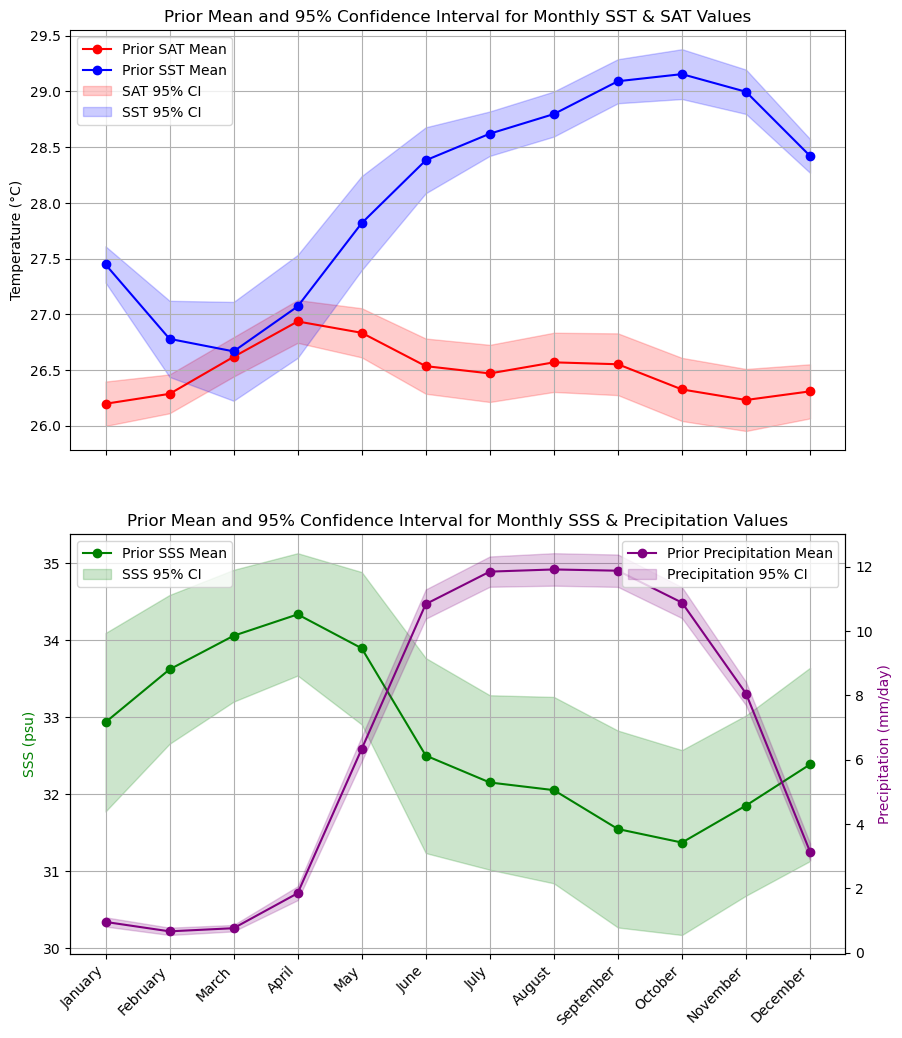

In [99]:
# Set dimensions of data
n_gridcells_monthly = len(IPCC_Atlas["lat"])  # Find the total number of models (use monthly data because monthly data has this column duplicated 3 times)

# Create a monthly scale for the x-axis
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']  # List full month names
months_scale = np.arange(len(months)) + 1  # Create monthly scale

# Create the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Panel 1: Plot the prior distribution for SST and SAT
axes[0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o', color='r')
axes[0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o', color='b')

# Add 95% confidence intervals for SAT
axes[0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='r', label='SAT 95% CI'
)

# Add 95% confidence intervals for SST
axes[0].fill_between(
    months_scale,
    mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='b', label='SST 95% CI'
)

axes[0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST & SAT Values')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True)

# Panel 2: Plot the prior distribution for SSS and precipitation
axes[1].plot(months_scale, mu_prior_SSS_monthly, label='Prior SSS Mean', marker='o', color='g')
ax2 = axes[1].twinx()  # Create a secondary y-axis for precipitation
ax2.plot(months_scale, mu_prior_precip_monthly, label='Prior Precipitation Mean', marker='o', color='purple')

# Add 95% confidence intervals for SSS
axes[1].fill_between(
    months_scale,
    mu_prior_SSS_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SSS_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='g', label='SSS 95% CI'
)

# Add 95% confidence intervals for precipitation
ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_precip_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='purple', label='Precipitation 95% CI'
)

axes[1].set_ylabel('SSS (psu)', color='g')
ax2.set_ylabel('Precipitation (mm/day)', color='purple')
axes[1].set_title('Prior Mean and 95% Confidence Interval for Monthly SSS & Precipitation Values')
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1].grid(True)

# Update the x-axis with month names
axes[1].set_xticks(months_scale)
axes[1].set_xticklabels(month_names, rotation=45, ha="right")

### Convert SST and SAT model data to D47 domain using the regression by Daëron and Vermeesch (2023) and propagate uncertainty in the calibration

In [100]:
# Apply T47()-function from the D47calib package to all SST columns
# Identify the SST and SAT columns separately
SST_columns = [col for col in IPCC_Atlas.columns if col.endswith('_SST')]
SAT_columns = [col for col in IPCC_Atlas.columns if col.endswith('_SAT')]

# Apply the conversion function to the SST and SAT columns and add new columns for D47 and D47_SE
for col in SST_columns:
    base_col_name = col.replace('_SST', '') # Remove the '_SST' suffix from the column name
    IPCC_Atlas[f'{base_col_name}_SST_D47'], IPCC_Atlas[f'{base_col_name}_SST_D47_SE'] = zip(*IPCC_Atlas[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column
for col in SAT_columns:
    base_col_name = col.replace('_SAT', '') # Remove the '_SST' suffix from the column name
    IPCC_Atlas[f'{base_col_name}_SAT_D47'], IPCC_Atlas[f'{base_col_name}_SAT_D47_SE'] = zip(*IPCC_Atlas[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column

# Display the combined data with D47 and D47_SE columns
D47_columns = [col for col in IPCC_Atlas.columns if col.endswith('_D47')]
D47_se_columns = [col for col in IPCC_Atlas.columns if '_D47_SE' in col]
print("D47 values for all grid cells:\n", IPCC_Atlas[D47_columns].head())
print("Calibration standard errors for all grid cells:\n", IPCC_Atlas[D47_se_columns].head())

D47 values for all grid cells:
 month  ar_SST_D47  ag_SST_D47  dc_SST_D47  fb_SST_D47  ja_SST_D47  jl_SST_D47  \
0             NaN         NaN         NaN         NaN         NaN         NaN   
1             NaN         NaN         NaN         NaN         NaN         NaN   
2             NaN         NaN         NaN         NaN         NaN         NaN   
3        0.584869    0.582139    0.583807    0.587368    0.585752    0.582432   
4        0.587996    0.586037    0.583782    0.589082    0.586898    0.585573   

month  jn_SST_D47  mr_SST_D47  my_SST_D47  nv_SST_D47  ...  dc_SAT_D47  \
0             NaN         NaN         NaN         NaN  ...         NaN   
1             NaN         NaN         NaN         NaN  ...         NaN   
2             NaN         NaN         NaN         NaN  ...         NaN   
3        0.582404    0.587211    0.582399    0.583674  ...    0.588737   
4        0.586114    0.589170    0.586742    0.583404  ...    0.588877   

month  fb_SAT_D47  ja_SAT_D47  jl_SA

### Estimate seawater oxygen isotope value from salinity based on modern Gulf of Panama d18Ow-salinity relationship by Graniero et al. (2017; rainy season)

In [101]:
# Apply the d18Ow-SSS function from Graniero et al. (2017) to all SSS columns
# Identify the SSS columns
SSS_columns = [col for col in IPCC_Atlas.columns if col.endswith('_SSS')]

# Apply the conversion function to the SSS columns and add new columns for d18Ow and d18Ow_SE
for col in SSS_columns:
    base_col_name = col.replace('_SSS', '')  # Remove the '_SSS' suffix from the column name
    IPCC_Atlas[f'{base_col_name}_SSS_d18Ow'] = IPCC_Atlas[col].apply(
        lambda x: -7.89 + 0.23 * x if not pd.isna(x) else np.nan  # Calculate d18Ow
    )

# Display the combined data with d18Ow and d18Ow_SE columns
d18Ow_columns = [col for col in IPCC_Atlas.columns if col.endswith('_d18Ow')]
print("d18Ow values for all model outcomes:\n", IPCC_Atlas[d18Ow_columns].head())

d18Ow values for all model outcomes:
 month  ag_SSS_d18Ow  ar_SSS_d18Ow  dc_SSS_d18Ow  fb_SSS_d18Ow  ja_SSS_d18Ow  \
0         -0.946499     -0.535089     -0.651119     -0.776133     -0.910557   
1         -1.054131     -0.510581     -0.922469     -0.802553     -1.029217   
2         -1.122032     -0.454520     -1.155741     -0.802820     -1.078707   
3         -1.054813     -0.320192     -1.168258     -0.733762     -1.099679   
4         -1.385865     -0.244780     -1.411953     -0.468423     -0.918595   

month  jl_SSS_d18Ow  jn_SSS_d18Ow  mr_SSS_d18Ow  my_SSS_d18Ow  nv_SSS_d18Ow  \
0         -0.974017     -0.945143     -0.664774     -0.520886     -0.864359   
1         -0.980658     -1.046126     -0.654697     -0.549428     -0.983300   
2         -1.053387     -1.099166     -0.591658     -0.558844     -1.211089   
3         -1.016603     -1.133604     -0.457816     -0.547296     -1.252933   
4         -1.203919     -1.289815     -0.303092     -0.745229     -1.404130   

month  ot_SS

### Calculate carbonate oxygen isotope value from SST and seawater oxygen isotope data using Grossman and Ku (1986) with the VPDB-VSMOW scale correction by Gonfiantini et al. (1995) and Dettman et al. (1999)

In [102]:
# Iterate over each model and calculate d18Oc values
for index, row in IPCC_Atlas.iterrows():
    # Iterate over each month
    for month in months:
        SST = row[f"{month}_SST"]
        d18Ow = row[f"{month}_SSS_d18Ow"]
        if not pd.isna(SST) and not pd.isna(d18Ow):
            d18Oc = (20.6 - SST) / 4.34 + (d18Ow - 0.27)
        else:
            d18Oc = np.nan
        # Add the calculated d18Oc value to the DataFrame
        IPCC_Atlas.loc[index, f"{month}_d18Oc"] = d18Oc

# Display the updated DataFrame
IPCC_Atlas.head()


month  lat   lon     ar_SST     ag_SST     dc_SST     fb_SST     ja_SST  \
0      7.5 -84.5        NaN        NaN        NaN        NaN        NaN   
1      7.5 -83.5        NaN        NaN        NaN        NaN        NaN   
2      7.5 -82.5        NaN        NaN        NaN        NaN        NaN   
3      7.5 -81.5  27.870666  28.807864  28.234173  27.020926  27.569698   
4      7.5 -80.5  26.808416  27.472491  28.242612  26.442010  27.180057   

month     jl_SST     jn_SST     mr_SST  ...  mr_d18Oc  ar_d18Oc  my_d18Oc  \
0            NaN        NaN        NaN  ...       NaN       NaN       NaN   
1            NaN        NaN        NaN  ...       NaN       NaN       NaN   
2            NaN        NaN        NaN  ...       NaN       NaN       NaN   
3      28.706740  28.716516  27.074181  ... -2.219563  -2.26546 -2.687796   
4      27.630609  27.446476  26.412426  ... -1.912361  -1.94529 -2.543542   

month  jn_d18Oc  jl_d18Oc  ag_d18Oc  sp_d18Oc  ot_d18Oc  nv_d18Oc  dc_d18Oc  
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
3     -3.273769 -3.154515 -3.216026 -3.374633 -3.349191 -3.292461 -3.197284  
4     -3.137344 -3.093875 -3.239388 -3.505681 -3.488579 -3.465035 -3.442923  

[5 rows x 122 columns]

### Calculate the monthly prior for model SST- and SAT-derived D47 values and SSS-derived seawater oxygen isotope values with propagated uncertainty

In [103]:
# Set the weights of the data based on the standard errors
weights_monthly_SST_D47 = 1 / IPCC_Atlas[[f"{month}_SST_D47_SE" for month in months]] ** 2
weights_monthly_SAT_D47 = 1 / IPCC_Atlas[[f"{month}_SAT_D47_SE" for month in months]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_monthly_SST_D47 to match the headers of the D47 matrix later for multiplication
weights_monthly_SST_D47.columns = [col.replace('_SST_D47_SE', '_SST_D47') for col in weights_monthly_SST_D47.columns]
weights_monthly_SAT_D47.columns = [col.replace('_SAT_D47_SE', '_SAT_D47') for col in weights_monthly_SAT_D47.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_SST_D47_monthly = np.array((IPCC_Atlas[[f"{month}_SST_D47" for month in months]] * weights_monthly_SST_D47).sum(axis = 0, skipna = True) / weights_monthly_SST_D47.sum(axis = 0, skipna = True)) # Calculate weighted monthly mean D47 values and convert to numpy array
mu_prior_SAT_D47_monthly = np.array((IPCC_Atlas[[f"{month}_SAT_D47" for month in months]] * weights_monthly_SAT_D47).sum(axis = 0, skipna = True) / weights_monthly_SAT_D47.sum(axis = 0, skipna = True)) # Calculate weighted monthly mean D47 values and convert to numpy array

# Calculate simple (unweighted) mean for monthly d18Ow values
mu_prior_SSS_d18Ow_monthly = np.array(IPCC_Atlas[[f"{month}_SSS_d18Ow" for month in months]].mean(axis=0, skipna=True))
mu_prior_d18Oc_monthly = np.array(IPCC_Atlas[[f"{month}_d18Oc" for month in months]].mean(axis=0, skipna=True))

# Decompose variance within and between model outcomes
model_variances_SST = IPCC_Atlas[[f"{month}_SST_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_SAT = IPCC_Atlas[[f"{month}_SAT_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_d18Ow = IPCC_Atlas[[f"{month}_SSS_d18Ow" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_d18Oc = IPCC_Atlas[[f"{month}_d18Oc" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances_SST = (IPCC_Atlas[[f"{month}_SST_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements
measurement_variances_SAT = (IPCC_Atlas[[f"{month}_SAT_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between months in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_monthly_SST = np.cov(IPCC_Atlas[[f"{month}_SST_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_SAT = np.cov(IPCC_Atlas[[f"{month}_SAT_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_d18Ow = np.cov(IPCC_Atlas[[f"{month}_SSS_d18Ow" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_d18Oc = np.cov(IPCC_Atlas[[f"{month}_d18Oc" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_D47_monthly = cov_raw_monthly_SST.copy() # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_SAT_D47_monthly = cov_raw_monthly_SAT.copy() # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_SST_D47_monthly, np.diagonal(cov_raw_monthly_SST) + measurement_variances_SST)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)
np.fill_diagonal(cov_prior_SAT_D47_monthly, np.diagonal(cov_raw_monthly_SAT) + measurement_variances_SAT)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SST_D47_monthly_original, cov_prior_SST_D47_monthly_original = mu_prior_SST_D47_monthly.copy(), cov_prior_SST_D47_monthly.copy()
mu_prior_SAT_D47_monthly_original, cov_prior_SAT_D47_monthly_original = mu_prior_SAT_D47_monthly.copy(), cov_prior_SAT_D47_monthly.copy()
mu_prior_SSS_d18Ow_monthly_original, cov_prior_SSS_d18Ow_monthly_original = mu_prior_SSS_d18Ow_monthly.copy(), cov_raw_monthly_d18Ow.copy()
mu_prior_d18Oc_monthly_original, cov_prior_d18Oc_monthly_original = mu_prior_d18Oc_monthly.copy(), cov_raw_monthly_d18Oc.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SST_D47_monthly = np.sqrt(np.diag(cov_prior_SST_D47_monthly))
std_prior_SAT_D47_monthly = np.sqrt(np.diag(cov_prior_SAT_D47_monthly))
std_prior_SSS_d18Ow_monthly = np.sqrt(np.diag(cov_raw_monthly_d18Ow))
std_prior_d18Oc_monthly = np.sqrt(np.diag(cov_raw_monthly_d18Oc))

# Print the results
print("Prior D47 estimates from SST in climate models (weighted mean):")
print(mu_prior_SST_D47_monthly)
print("Prior D47 estimates from SST in climate models (weighted covariance matrix):")
print(std_prior_SST_D47_monthly)
print("Prior D47 estimates from SAT in climate models (weighted mean):")
print(mu_prior_SAT_D47_monthly)
print("Prior D47 estimates from SAT in climate models (weighted covariance matrix):")
print(std_prior_SAT_D47_monthly)
print("Prior d18Ow estimates from SSS in climate models (weighted mean):")
print(mu_prior_SSS_d18Ow_monthly)
print("Prior d18Ow estimates from SSS in climate models (weighted covariance matrix):")
print(std_prior_SSS_d18Ow_monthly)
print("Prior d18Oc estimates from SST and d18Ow in climate models (weighted mean):")
print(mu_prior_d18Oc_monthly)
print("Prior d18Oc estimates from SST and d18Ow in climate models (weighted covariance matrix):")
print(std_prior_d18Oc_monthly)

Prior D47 estimates from SST in climate models (weighted mean):
[0.58611136 0.58807854 0.58840607 0.58721478 0.58502217 0.58337762
 0.5826824  0.58217063 0.58131734 0.58113373 0.58159202 0.58326221]
Prior D47 estimates from SST in climate models (weighted covariance matrix):
[0.00154225 0.00262358 0.0033056  0.00341755 0.00312591 0.00229783
 0.00172489 0.00174205 0.00171518 0.00185845 0.00171988 0.00147969]
Prior D47 estimates from SAT in climate models (weighted mean):
[0.58980992 0.58954575 0.58855954 0.5876189  0.58791991 0.58880551
 0.58899953 0.58870432 0.58875453 0.58942555 0.5897075  0.5894774 ]
Prior D47 estimates from SAT in climate models (weighted covariance matrix):
[0.0017582  0.00161882 0.00162767 0.00170748 0.0018731  0.00203748
 0.00209141 0.00214556 0.00221785 0.00226071 0.00223188 0.00201213]
Prior d18Ow estimates from SSS in climate models (weighted mean):
[-0.31513027 -0.15720166 -0.056688    0.00720476 -0.09408187 -0.4147066
 -0.49514977 -0.51800919 -0.63427738 -0.

### Plot the monthly prior for model SST- and SAT-derived D47 values, model SSS-derived carbonate d18O values and precipitation with propagated uncertainty

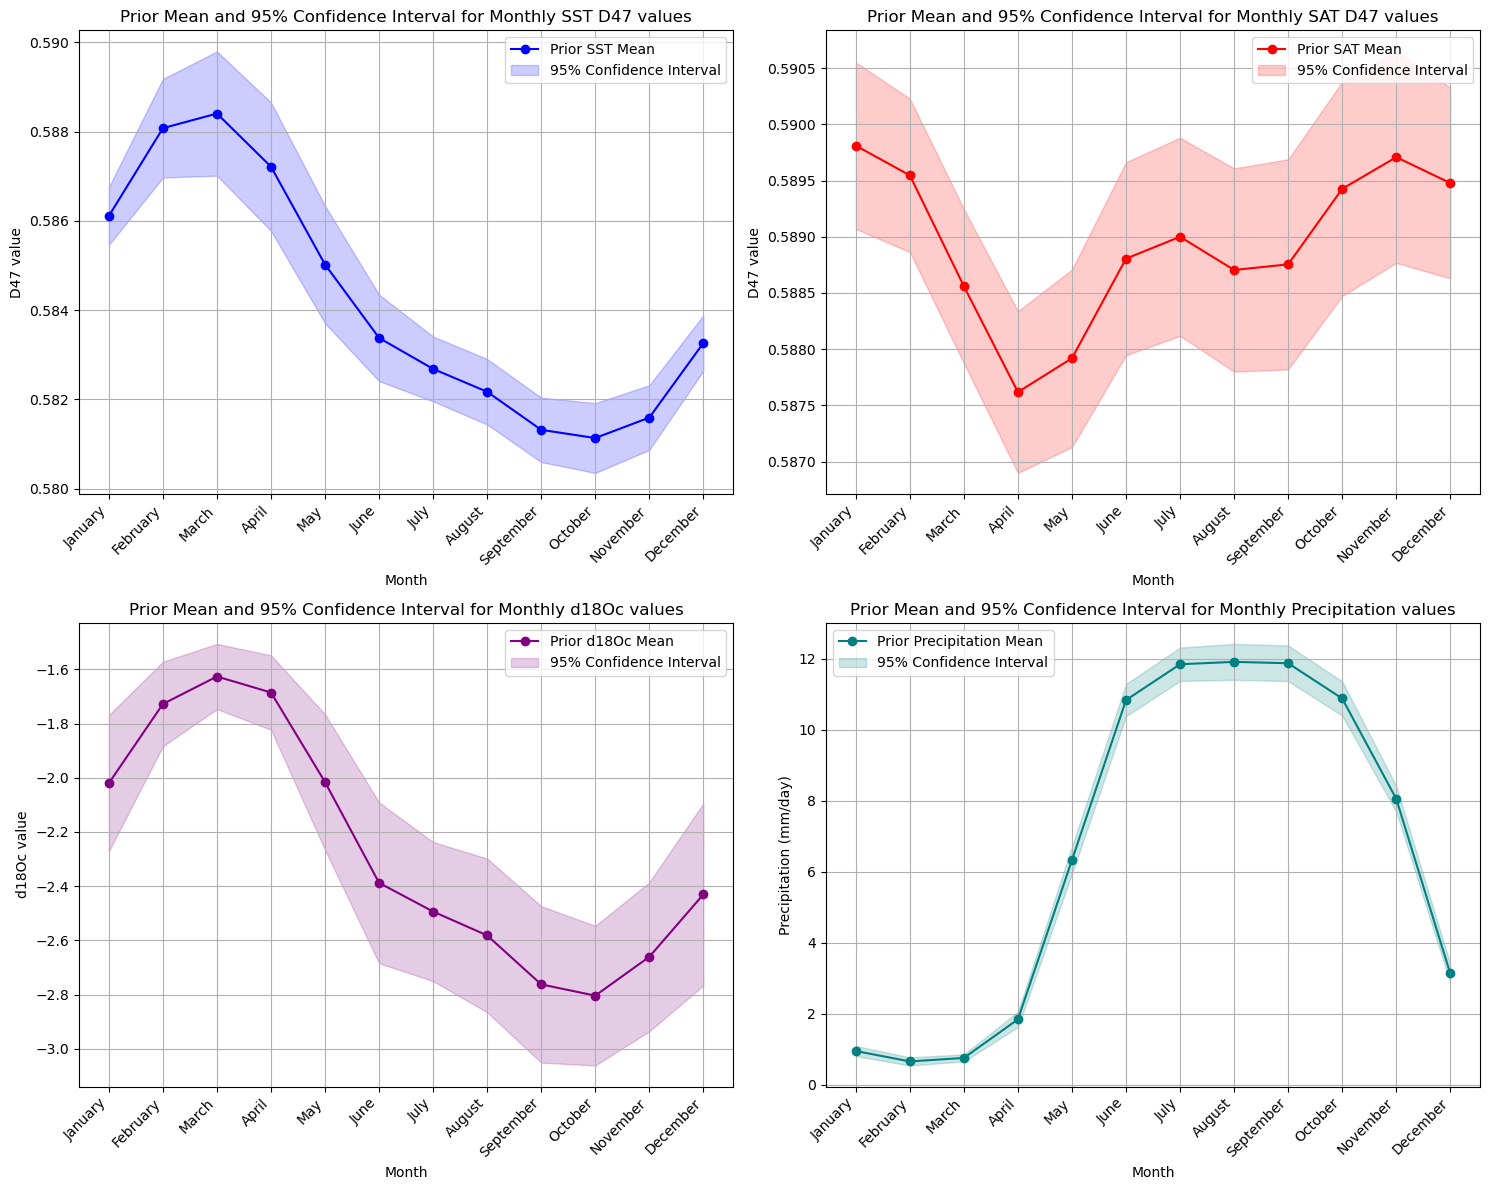

In [104]:
# Plot monthly prior distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Adjust the figure to have 2x2 grid

# Plot the prior distribution for SST
axes[0, 0].plot(months_scale, mu_prior_SST_D47_monthly, label='Prior SST Mean', color='b', marker='o')
axes[0, 0].fill_between(months_scale,
                        mu_prior_SST_D47_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_D47_monthly / np.sqrt(n_gridcells_monthly),
                        mu_prior_SST_D47_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_D47_monthly / np.sqrt(n_gridcells_monthly),
                        color='b', alpha=0.2, label='95% Confidence Interval')
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST D47 values')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('D47 value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot the prior distribution for SAT
axes[0, 1].plot(months_scale, mu_prior_SAT_D47_monthly, label='Prior SAT Mean', color='r', marker='o')
axes[0, 1].fill_between(months_scale,
                        mu_prior_SAT_D47_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_D47_monthly / np.sqrt(n_gridcells_monthly),
                        mu_prior_SAT_D47_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_D47_monthly / np.sqrt(n_gridcells_monthly),
                        color='r', alpha=0.2, label='95% Confidence Interval')
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Prior Mean and 95% Confidence Interval for Monthly SAT D47 values')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('D47 value')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot the prior distribution for d18Oc
axes[1, 0].plot(months_scale, mu_prior_d18Oc_monthly, label='Prior d18Oc Mean', color='purple', marker='o')
axes[1, 0].fill_between(months_scale,
                        mu_prior_d18Oc_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_d18Oc_monthly / np.sqrt(n_gridcells_monthly),
                        mu_prior_d18Oc_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_d18Oc_monthly / np.sqrt(n_gridcells_monthly),
                        color='purple', alpha=0.2, label='95% Confidence Interval')
axes[1, 0].set_xticks(months_scale)
axes[1, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 0].set_title('Prior Mean and 95% Confidence Interval for Monthly d18Oc values')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('d18Oc value')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot the prior distribution for precipitation
axes[1, 1].plot(months_scale, mu_prior_precip_monthly, label='Prior Precipitation Mean', color='teal', marker='o')
axes[1, 1].fill_between(months_scale,
                        mu_prior_precip_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
                        mu_prior_precip_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
                        color='teal', alpha=0.2, label='95% Confidence Interval')
axes[1, 1].set_xticks(months_scale)
axes[1, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 1].set_title('Prior Mean and 95% Confidence Interval for Monthly Precipitation values')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Precipitation (mm/day)')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Update the layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the monthly covariance matrix for D47 values of SST and SAT, d18Oc and precipitation

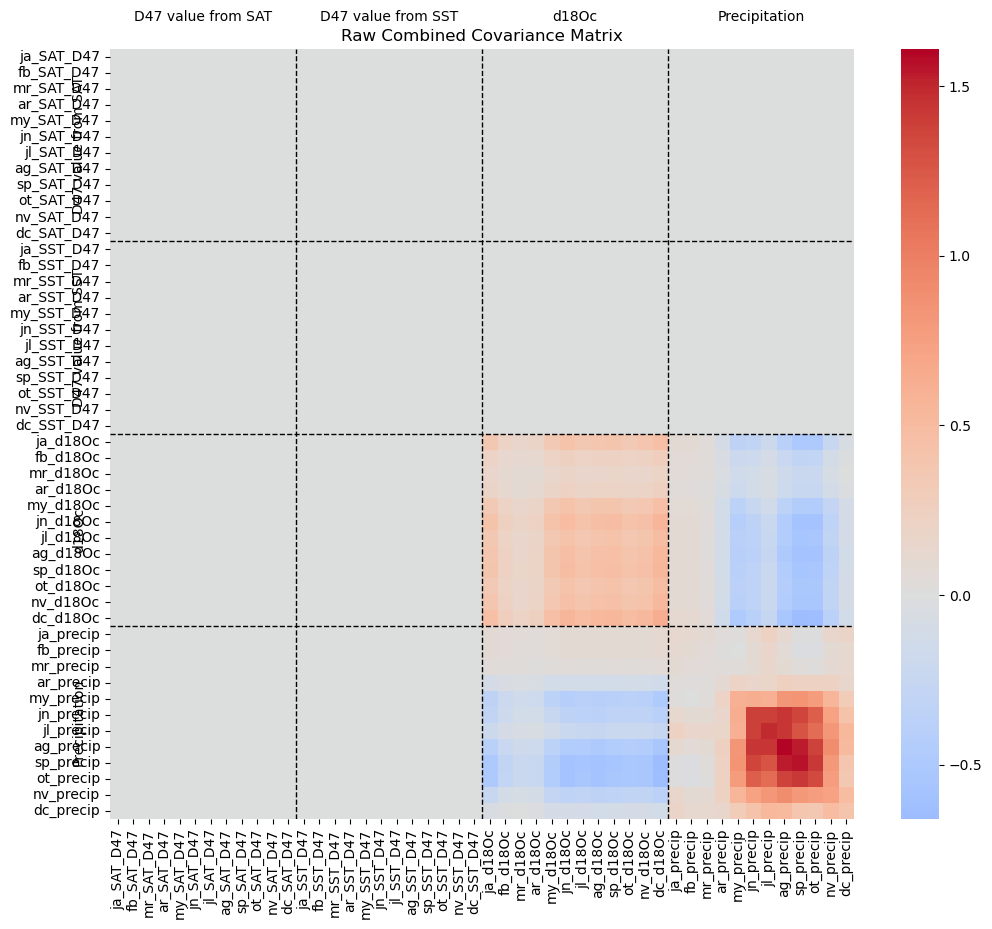

In [105]:
# Define column names for SAT, SST, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Extract the relevant columns for SAT, SST D47, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly = IPCC_Atlas[SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly = np.cov(combined_data_monthly.dropna(), rowvar=False)

# Plot the heatmap of the raw combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cov_combined_monthly,  # Use the raw covariance matrix
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly,
    yticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_monthly) / 2, -2, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, -2, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-2, len(SAT_D47_columns_monthly) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-2, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Raw Combined Covariance Matrix")
plt.show()

## Plot normalized monthly covariance matrix between D47 values of SST and SAT, d18Oc and precipitation

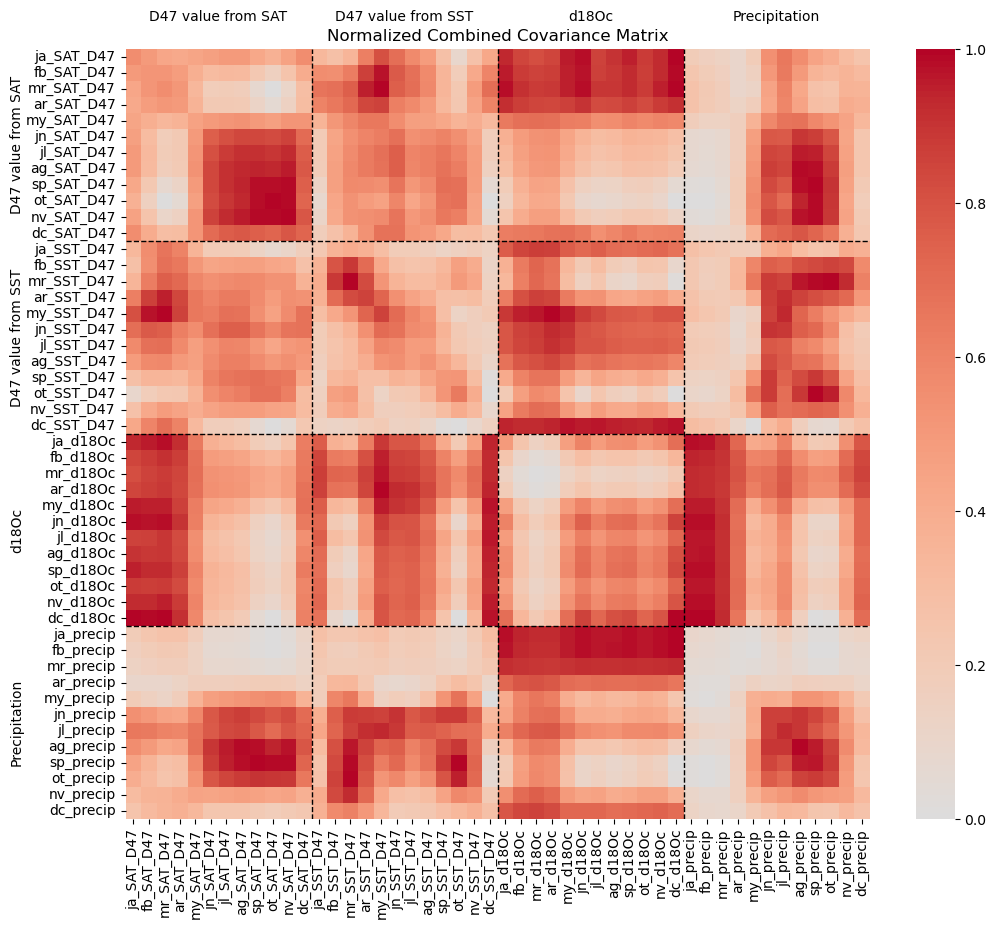

In [106]:
# Normalize each submatrix independently for better visualization
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

# Extract the relevant columns for SAT, SST D47, d18Oc, and precipitation
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]
d18Oc_columns_monthly = [f"{month}_d18Oc" for month in months]
precip_columns_monthly = [f"{month}_precip" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly = IPCC_Atlas[SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly = np.cov(combined_data_monthly.dropna(), rowvar=False)

# Extract the covariance matrices for SAT D47, SST D47, d18Oc, and precipitation
cov_SAT_D47_monthly = cov_combined_monthly[:len(months), :len(months)]
cov_SST_D47_monthly = cov_combined_monthly[len(months):2*len(months), len(months):2*len(months)]
cov_d18Oc_monthly = cov_combined_monthly[2*len(months):3*len(months), 2*len(months):3*len(months)]
cov_precip_monthly = cov_combined_monthly[3*len(months):, 3*len(months):]

# Extract the cross-covariance matrices
cross_cov_SAT_SST_D47_monthly = cov_combined_monthly[:len(months), len(months):2*len(months)]
cross_cov_SAT_d18Oc_monthly = cov_combined_monthly[:len(months), 2*len(months):3*len(months)]
cross_cov_SAT_precip_monthly = cov_combined_monthly[:len(months), 3*len(months):]
cross_cov_SST_d18Oc_monthly = cov_combined_monthly[len(months):2*len(months), 2*len(months):3*len(months)]
cross_cov_SST_precip_monthly = cov_combined_monthly[len(months):2*len(months), 3*len(months):]
cross_cov_d18Oc_precip_monthly = cov_combined_monthly[2*len(months):3*len(months), 3*len(months):]

# Normalize each submatrix
normalized_cov_SAT_D47_monthly = normalize_matrix(cov_SAT_D47_monthly)
normalized_cov_SST_D47_monthly = normalize_matrix(cov_SST_D47_monthly)
normalized_cov_d18Oc_monthly = normalize_matrix(cov_d18Oc_monthly)
normalized_cov_precip_monthly = normalize_matrix(cov_precip_monthly)

# Normalize each cross-covariance matrix
normalized_cross_cov_SAT_SST_D47_monthly = normalize_matrix(cross_cov_SAT_SST_D47_monthly)
normalized_cross_cov_SAT_d18Oc_monthly = normalize_matrix(cross_cov_SAT_d18Oc_monthly)
normalized_cross_cov_SAT_precip_monthly = normalize_matrix(cross_cov_SAT_precip_monthly)
normalized_cross_cov_SST_d18Oc_monthly = normalize_matrix(cross_cov_SST_d18Oc_monthly)
normalized_cross_cov_SST_precip_monthly = normalize_matrix(cross_cov_SST_precip_monthly)
normalized_cross_cov_d18Oc_precip_monthly = normalize_matrix(cross_cov_d18Oc_precip_monthly)

# Combine the normalized submatrices into a single normalized covariance matrix
normalized_cov_combined_monthly = np.block([
    [normalized_cov_SAT_D47_monthly, normalized_cross_cov_SAT_SST_D47_monthly, normalized_cross_cov_SAT_d18Oc_monthly, normalized_cross_cov_SAT_precip_monthly],
    [normalized_cross_cov_SAT_SST_D47_monthly.T, normalized_cov_SST_D47_monthly, normalized_cross_cov_SST_d18Oc_monthly, normalized_cross_cov_SST_precip_monthly],
    [normalized_cross_cov_SAT_d18Oc_monthly.T, normalized_cross_cov_SST_d18Oc_monthly.T, normalized_cov_d18Oc_monthly, normalized_cross_cov_d18Oc_precip_monthly],
    [normalized_cross_cov_SAT_precip_monthly.T, normalized_cross_cov_SST_precip_monthly.T, normalized_cross_cov_d18Oc_precip_monthly.T, normalized_cov_precip_monthly]
])

# Plot the heatmap of the normalized combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    normalized_cov_combined_monthly,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly,
    yticklabels=SAT_D47_columns_monthly + SST_D47_columns_monthly + d18Oc_columns_monthly + precip_columns_monthly
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_monthly) / 2, -2, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, -2, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-7, len(SAT_D47_columns_monthly) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-7, len(SAT_D47_columns_monthly) + len(SST_D47_columns_monthly) + len(d18Oc_columns_monthly) + len(precip_columns_monthly) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Normalized Combined Covariance Matrix")
plt.show()

## Create combined monthly state vector in D47 and d18Oc domain

In [107]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_monthly_combined = np.concatenate((mu_prior_SST_D47_monthly, mu_prior_SAT_D47_monthly, mu_prior_d18Oc_monthly, mu_prior_precip_monthly))

# Combine the covariance matrices of D47 values of SST and SAT, including the cross-covariance
cov_prior_monthly_combined = cov_combined_monthly.copy()

# PRIOR - SEASONAL

## Seasonal model data (convert the IPCC_Atlas data to seasonal means)

In [108]:
# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

# Stack monthly columns to create seasonal dataframes
# Initialize dictionaries to store seasonal data
IPCC_Atlas_seasonal_dict = {}

# Identify the columns to process (all except the modelname column)
columns_to_process = [col for col in IPCC_Atlas.columns if any(suffix in col for suffix in [
    '_SST', '_SAT', '_SST_D47', '_SST_D47_SE', '_SAT_D47', '_SAT_D47_SE',
    '_SSS', '_d18Oc', '_precip'
])]

# Process each season
for season, months in seasons.items():  # Iterate over the seasons and corresponding months
    for col in columns_to_process:  # Iterate over the columns to process
        base_col_name = col.split('_')[0]  # Extract the base column name
        suffix = '_'.join(col.split('_')[1:])  # Extract the suffix
        if base_col_name in months:  # Check if the column corresponds to the current season
            season_col_name = f"{season}_{suffix}"  # Create the new column name
            if season_col_name not in IPCC_Atlas_seasonal_dict:  # Check if the new column name already exists in the seasonal data
                IPCC_Atlas_seasonal_dict[season_col_name] = []  # If not, initialize a new column in the seasonal data means
            IPCC_Atlas_seasonal_dict[season_col_name].append(IPCC_Atlas[col])

# Combine the seasonal data into a single dataframe
IPCC_Atlas_seasonal = pd.DataFrame()
for season_col_name, data in IPCC_Atlas_seasonal_dict.items():
    # Concatenate the data for each season and reshape it properly
    concatenated_data = pd.concat(data, axis=0).reset_index(drop=True)
    IPCC_Atlas_seasonal[season_col_name] = concatenated_data

# Add model names
IPCC_Atlas_seasonal["lat"] = np.tile(IPCC_Atlas["lat"].values, 3)  # Repeat the model names for each season
IPCC_Atlas_seasonal["lon"] = np.tile(IPCC_Atlas["lon"].values, 3)  # Repeat the model names for each season

# Display the new seasonal DataFrame
D47_columns_seasonal = [col for col in IPCC_Atlas_seasonal.columns if col.endswith('_D47')]
D47_se_columns_seasonal = [col for col in IPCC_Atlas_seasonal.columns if '_D47_SE' in col]
SSS_columns_seasonal = [col for col in IPCC_Atlas_seasonal.columns if col.endswith('_SSS')]
d18Oc_columns_seasonal = [col for col in IPCC_Atlas_seasonal.columns if col.endswith('_d18Oc')]
precip_columns_seasonal = [col for col in IPCC_Atlas_seasonal.columns if col.endswith('_precip')]

print("Seasonal D47 values for all SST model outcomes:\n", IPCC_Atlas_seasonal[D47_columns_seasonal].head())
print("Calibration standard errors for all SST model outcomes:\n", IPCC_Atlas_seasonal[D47_se_columns_seasonal].head())
print("Seasonal SSS values for all model outcomes:\n", IPCC_Atlas_seasonal[SSS_columns_seasonal].head())
print("Seasonal d18Oc values for all model outcomes:\n", IPCC_Atlas_seasonal[d18Oc_columns_seasonal].head())
print("Seasonal precipitation values for all model outcomes:\n", IPCC_Atlas_seasonal[precip_columns_seasonal].head())

Seasonal D47 values for all SST model outcomes:
    winter_SST_D47  winter_SAT_D47  spring_SST_D47  spring_SAT_D47  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3        0.583807        0.588737        0.584869        0.585712   
4        0.583782        0.588877        0.587996        0.586618   

   summer_SST_D47  summer_SAT_D47  autumn_SST_D47  autumn_SAT_D47  
0             NaN             NaN             NaN             NaN  
1             NaN             NaN             NaN             NaN  
2             NaN             NaN             NaN             NaN  
3        0.582139        0.588755        0.583674        0.589746  
4        0.586037        0.588803        0.583404        0.589790  
Calibration standard errors for all SST model outcomes:
    winter_SST_D47_SE  winter_SAT_D47_SE  spring_SST_D47_SE  spring_SAT_

## Calculate the seasonal prior for model SST, SAT, SSS and precipitation with propagated uncertainty

In [109]:
# Prior estimates from climate models (mean)
mu_prior_SAT_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_SAT" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_SST_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_SST" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_SSS_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_SSS" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_precip_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_precip" for season in seasons]].mean(axis=0, skipna=True))

# Covariance between seasons in prior estimates from climate models (covariance matrix)
cov_prior_SAT_seasonal = np.cov(IPCC_Atlas_seasonal[[f"{season}_SAT" for season in seasons]].dropna(), rowvar=False)
cov_prior_SST_seasonal = np.cov(IPCC_Atlas_seasonal[[f"{season}_SST" for season in seasons]].dropna(), rowvar=False)
cov_prior_SSS_seasonal = np.cov(IPCC_Atlas_seasonal[[f"{season}_SSS" for season in seasons]].dropna(), rowvar=False)
cov_prior_precip_seasonal = np.cov(IPCC_Atlas_seasonal[[f"{season}_precip" for season in seasons]].dropna(), rowvar=False)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_seasonal_original, cov_prior_SAT_seasonal_original = mu_prior_SAT_seasonal.copy(), cov_prior_SAT_seasonal.copy()
mu_prior_SST_seasonal_original, cov_prior_SST_seasonal_original = mu_prior_SST_seasonal.copy(), cov_prior_SST_seasonal.copy()
mu_prior_SSS_seasonal_original, cov_prior_SSS_seasonal_original = mu_prior_SSS_seasonal.copy(), cov_prior_SSS_seasonal.copy()
mu_prior_precip_seasonal_original, cov_prior_precip_seasonal_original = mu_prior_precip_seasonal.copy(), cov_prior_precip_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal))
std_prior_SST_seasonal = np.sqrt(np.diag(cov_prior_SST_seasonal))
std_prior_SSS_seasonal = np.sqrt(np.diag(cov_prior_SSS_seasonal))
std_prior_precip_seasonal = np.sqrt(np.diag(cov_prior_precip_seasonal))

# Print the results
print("SAT Seasonal Means:", mu_prior_SAT_seasonal)
print("SAT Seasonal Std Devs:", std_prior_SAT_seasonal)
print("SST Seasonal Means:", mu_prior_SST_seasonal)
print("SST Seasonal Std Devs:", std_prior_SST_seasonal)
print("SSS Seasonal Means:", mu_prior_SSS_seasonal)
print("SSS Seasonal Std Devs:", std_prior_SSS_seasonal)
print("Precipitation Seasonal Means:", mu_prior_precip_seasonal)
print("Precipitation Seasonal Std Devs:", std_prior_precip_seasonal)

SAT Seasonal Means: [26.26354562 26.79566898 26.52403169 26.36912953]
SAT Seasonal Std Devs: [0.48353899 0.47684737 0.59702245 0.66270196]
SST Seasonal Means: [27.54933547 27.18525559 28.60013027 29.08157766]
SST Seasonal Std Devs: [0.87357802 1.13352575 0.5748445  0.48432974]
SSS Seasonal Means: [32.9804294  34.09628244 32.23497744 31.58986653]
SSS Seasonal Std Devs: [2.69635668 2.07310351 2.82074275 2.85149091]
Precipitation Seasonal Means: [ 1.5836546   2.97928946 11.53320424 10.27162417]
Precipitation Seasonal Std Devs: [1.19706106 2.51465787 1.21440914 1.94491224]


## Plot the seasonal prior for model SST, SAT, SSS and measured precipitation

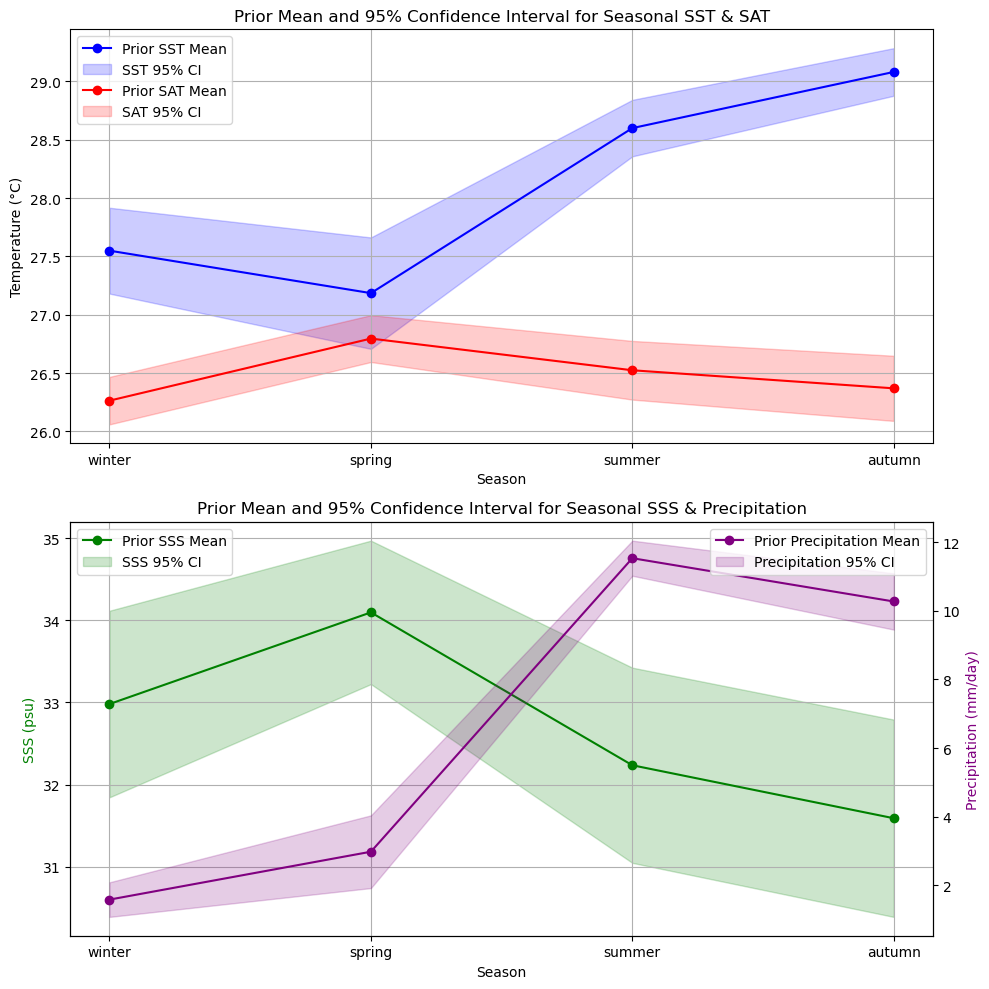

In [110]:
# Define the seasons, number of models, and scale for the x-axis
seasons = ["winter", "spring", "summer", "autumn"]
n_gridcells_seasonal = len(IPCC_Atlas["lat"])  # Find the total number of models
seasons_scale = np.arange(len(seasons)) + 1  # Create seasonal scale

# Create a 1x2 plotting grid
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Panel 1: Plot the prior distribution for SST and SAT
axes[0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o', color='b')
axes[0].fill_between(
    seasons_scale,
    mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='b', label='SST 95% CI'
)
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o', color='r')
axes[0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='r', label='SAT 95% CI'
)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST & SAT')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].legend()
axes[0].grid(True)

# Panel 2: Plot the prior distribution for SSS and precipitation
axes[1].plot(seasons_scale, mu_prior_SSS_seasonal, label='Prior SSS Mean', marker='o', color='g')
ax2 = axes[1].twinx()  # Create a secondary y-axis for precipitation
ax2.plot(seasons_scale, mu_prior_precip_seasonal, label='Prior Precipitation Mean', marker='o', color='purple')

# Add 95% confidence intervals for SSS
axes[1].fill_between(
    seasons_scale,
    mu_prior_SSS_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SSS_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SSS_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='g', label='SSS 95% CI'
)

# Add 95% confidence intervals for precipitation
ax2.fill_between(
    seasons_scale,
    mu_prior_precip_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_precip_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='purple', label='Precipitation 95% CI'
)

axes[1].set_title('Prior Mean and 95% Confidence Interval for Seasonal SSS & Precipitation')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('SSS (psu)', color='g')
ax2.set_ylabel('Precipitation (mm/day)', color='purple')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the seasonal prior for model SST and SAT-derived D47 values with propagated uncertainty

In [111]:
# Set the weights of the data based on the standard errors
weights_seasonal_SST_D47 = 1 / IPCC_Atlas_seasonal[[f"{season}_SST_D47_SE" for season in seasons]] ** 2
weights_seasonal_SAT_D47 = 1 / IPCC_Atlas_seasonal[[f"{season}_SAT_D47_SE" for season in seasons]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_seasonal to match the headers of the D47 matrix later for multiplication
weights_seasonal_SST_D47.columns = [col.replace('_SST_D47_SE', '_SST_D47') for col in weights_seasonal_SST_D47.columns]
weights_seasonal_SAT_D47.columns = [col.replace('_SAT_D47_SE', '_SAT_D47') for col in weights_seasonal_SAT_D47.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_SST_D47_seasonal = np.array((IPCC_Atlas_seasonal[[f"{season}_SST_D47" for season in seasons]] * weights_seasonal_SST_D47).sum(axis = 0, skipna = True) / weights_seasonal_SST_D47.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array
mu_prior_SAT_D47_seasonal = np.array((IPCC_Atlas_seasonal[[f"{season}_SAT_D47" for season in seasons]] * weights_seasonal_SAT_D47).sum(axis = 0, skipna = True) / weights_seasonal_SAT_D47.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array

# Calculate simple (unweighted) mean for monthly d18Oc values
mu_prior_d18Oc_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_d18Oc" for season in seasons]].mean(axis=0, skipna=True))
mu_prior_precip_seasonal = np.array(IPCC_Atlas_seasonal[[f"{season}_precip" for season in seasons]].mean(axis=0, skipna=True))

# Decompose variance within and between model outcomes
model_variances_SST_D47 = IPCC_Atlas_seasonal[[f"{season}_SST_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_SAT_D47 = IPCC_Atlas_seasonal[[f"{season}_SAT_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances_SST_D47 = (IPCC_Atlas_seasonal[[f"{season}_SST_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements
measurement_variances_SAT_D47 = (IPCC_Atlas_seasonal[[f"{season}_SAT_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between seasons in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_seasonal_SST_D47 = np.cov(IPCC_Atlas_seasonal[[f"{season}_SST_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_SAT_D47 = np.cov(IPCC_Atlas_seasonal[[f"{season}_SAT_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_d18Oc = np.cov(IPCC_Atlas_seasonal[[f"{season}_d18Oc" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_precip = np.cov(IPCC_Atlas_seasonal[[f"{season}_precip" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_D47_seasonal = cov_raw_seasonal_SST_D47.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_SAT_D47_seasonal = cov_raw_seasonal_SAT_D47.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_d18Oc_seasonal = cov_raw_seasonal_d18Oc.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_precip_seasonal = cov_raw_seasonal_precip.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_SST_D47_seasonal, np.diagonal(cov_raw_seasonal_SST_D47) + measurement_variances_SST_D47)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)
np.fill_diagonal(cov_prior_SAT_D47_seasonal, np.diagonal(cov_raw_seasonal_SAT_D47) + measurement_variances_SAT_D47)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SST_D47_seasonal_original, cov_prior_SST_D47_seasonal_original = mu_prior_SST_D47_seasonal.copy(), cov_prior_SST_D47_seasonal.copy()
mu_prior_SAT_D47_seasonal_original, cov_prior_SAT_D47_seasonal_original = mu_prior_SAT_D47_seasonal.copy(), cov_prior_SAT_D47_seasonal.copy()
mu_prior_d18Oc_seasonal_original, cov_prior_d18Oc_seasonal_original = mu_prior_d18Oc_seasonal.copy(), cov_raw_seasonal_d18Oc.copy()
mu_prior_precip_seasonal_original, cov_prior_precip_seasonal_original = mu_prior_precip_seasonal.copy(), cov_raw_seasonal_precip.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SST_D47_seasonal = np.sqrt(np.diag(cov_prior_SST_D47_seasonal))
std_prior_SAT_D47_seasonal = np.sqrt(np.diag(cov_prior_SAT_D47_seasonal))
std_prior_d18Oc_seasonal = np.sqrt(np.diag(cov_prior_d18Oc_seasonal))
std_prior_precip_seasonal = np.sqrt(np.diag(cov_prior_precip_seasonal))

print("mu_prior_SST_D47_seasonal:", mu_prior_SST_D47_seasonal)
print("std_prior_SST_D47_seasonal:", std_prior_SST_D47_seasonal)
print("mu_prior_SAT_D47_seasonal:", mu_prior_SAT_D47_seasonal)
print("std_prior_SAT_D47_seasonal:", std_prior_SAT_D47_seasonal)
print("mu_prior_d18Oc_seasonal:", mu_prior_d18Oc_seasonal)
print("std_prior_d18Oc_seasonal:", std_prior_d18Oc_seasonal)
print("mu_prior_precip_seasonal:", mu_prior_precip_seasonal)
print("std_prior_precip_seasonal:", std_prior_precip_seasonal)

mu_prior_SST_D47_seasonal: [0.58581025 0.58687706 0.58274323 0.58134767]
std_prior_SST_D47_seasonal: [0.00277616 0.00351338 0.00197095 0.00174785]
mu_prior_SAT_D47_seasonal: [0.58961097 0.58803244 0.58883642 0.58929545]
std_prior_SAT_D47_seasonal: [0.00178228 0.00175895 0.00205975 0.00223382]
mu_prior_d18Oc_seasonal: [-2.05926297 -1.77569652 -2.48786265 -2.74257046]
std_prior_d18Oc_seasonal: [0.66384694 0.44756316 0.64969896 0.63483524]
mu_prior_precip_seasonal: [ 1.5836546   2.97928946 11.53320424 10.27162417]
std_prior_precip_seasonal: [1.19706106 2.51465787 1.21440914 1.94491224]


## Plot the seasonal prior for model SST- and SAT-derived D47 values, d18Oc values and precipitation with propagated uncertainty

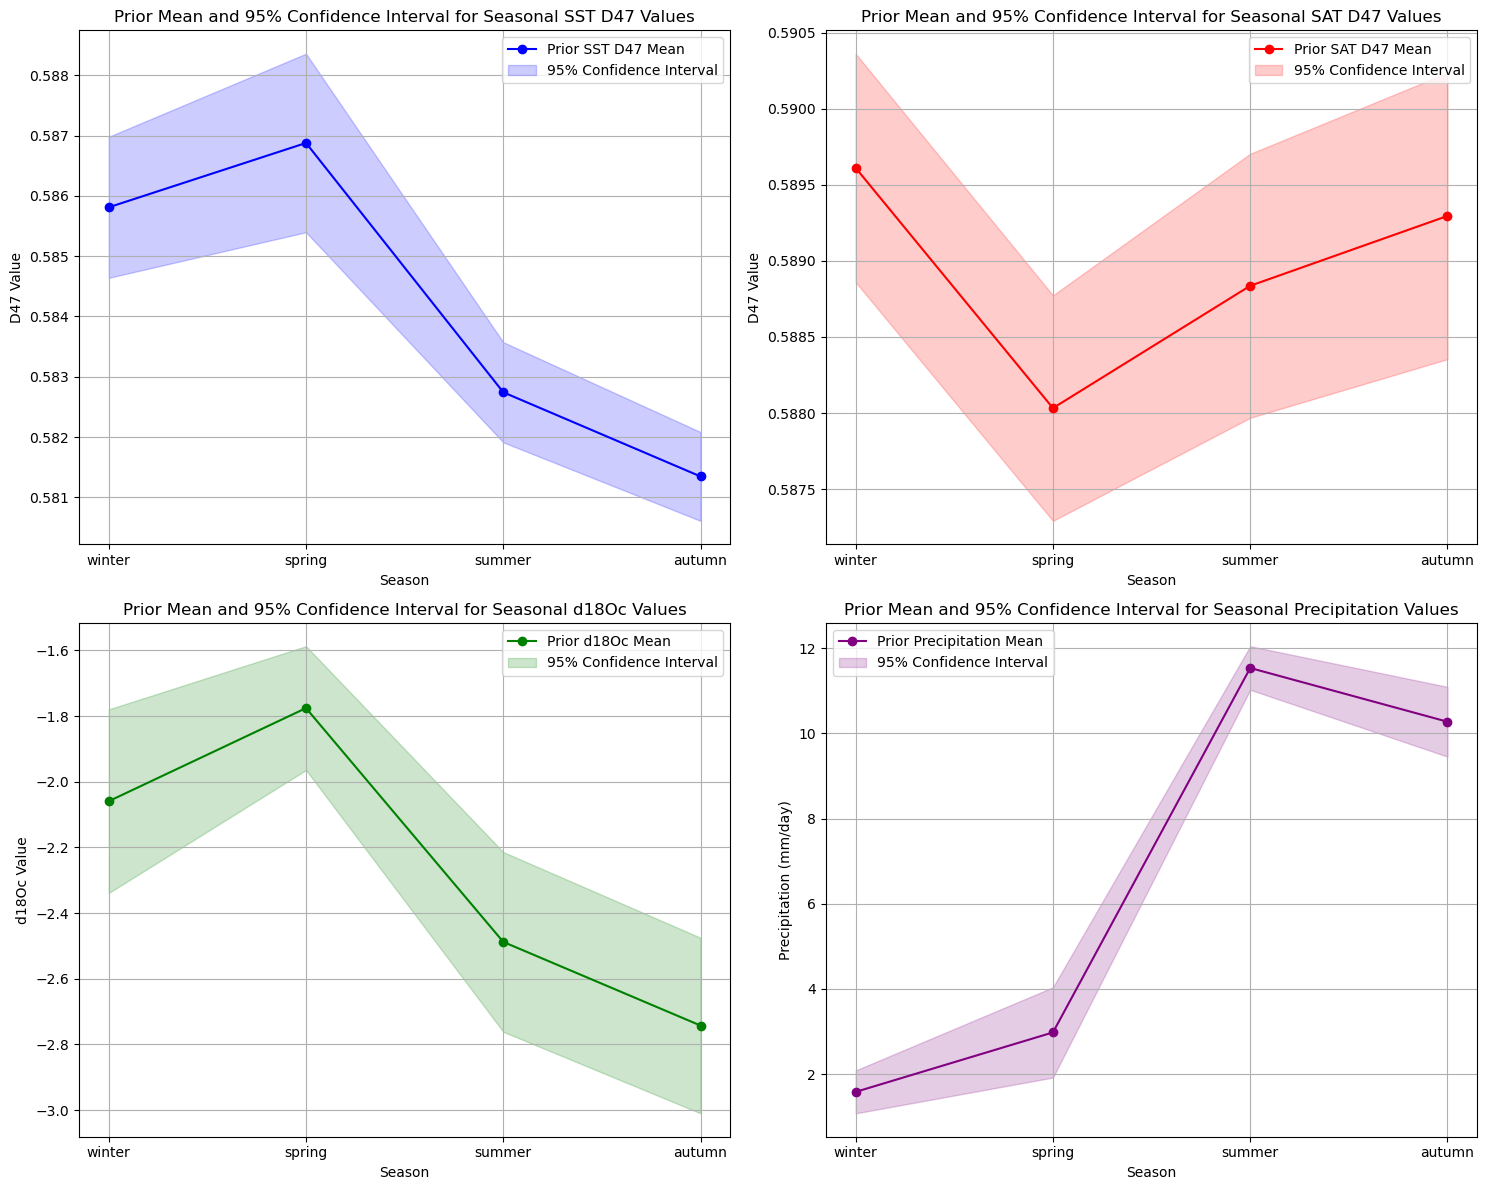

In [112]:
# Define the seasons, number of models, and scale for the x-axis
seasons = ["winter", "spring", "summer", "autumn"]
n_gridcells_seasonal = len(IPCC_Atlas["lat"])  # Find the total number of models (use monthly data because seasonal data has this column duplicated 3 times)
seasons_scale = np.arange(len(seasons)) + 1  # Create seasonal scale

# Create a 2x2 plotting grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Panel 1: Plot the prior distribution for SST D47 values
axes[0, 0].plot(seasons_scale, mu_prior_SST_D47_seasonal[:len(seasons)], label='Prior SST D47 Mean', marker='o', color='b')
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SST_D47_seasonal[:len(seasons)] - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_D47_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SST_D47_seasonal[:len(seasons)] + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_D47_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='b', label='95% Confidence Interval'
)
axes[0, 0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST D47 Values')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('D47 Value')
axes[0, 0].set_xticks(seasons_scale)
axes[0, 0].set_xticklabels(seasons)
axes[0, 0].legend()
axes[0, 0].grid(True)

# Panel 2: Plot the prior distribution for SAT D47 values
axes[0, 1].plot(seasons_scale, mu_prior_SAT_D47_seasonal[:len(seasons)], label='Prior SAT D47 Mean', marker='o', color='r')
axes[0, 1].fill_between(
    seasons_scale,
    mu_prior_SAT_D47_seasonal[:len(seasons)] - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_D47_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SAT_D47_seasonal[:len(seasons)] + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_D47_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='r', label='95% Confidence Interval'
)
axes[0, 1].set_title('Prior Mean and 95% Confidence Interval for Seasonal SAT D47 Values')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('D47 Value')
axes[0, 1].set_xticks(seasons_scale)
axes[0, 1].set_xticklabels(seasons)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Panel 3: Plot the prior distribution for d18Oc
axes[1, 0].plot(seasons_scale, mu_prior_d18Oc_seasonal, label='Prior d18Oc Mean', marker='o', color='g')
axes[1, 0].fill_between(
    seasons_scale,
    mu_prior_d18Oc_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_d18Oc_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_d18Oc_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_d18Oc_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='g', label='95% Confidence Interval'
)
axes[1, 0].set_title('Prior Mean and 95% Confidence Interval for Seasonal d18Oc Values')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('d18Oc Value')
axes[1, 0].set_xticks(seasons_scale)
axes[1, 0].set_xticklabels(seasons)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Panel 4: Plot the prior distribution for precipitation
axes[1, 1].plot(seasons_scale, mu_prior_precip_seasonal, label='Prior Precipitation Mean', marker='o', color='purple')
axes[1, 1].fill_between(
    seasons_scale,
    mu_prior_precip_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_precip_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, color='purple', label='95% Confidence Interval'
)
axes[1, 1].set_title('Prior Mean and 95% Confidence Interval for Seasonal Precipitation Values')
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Precipitation (mm/day)')
axes[1, 1].set_xticks(seasons_scale)
axes[1, 1].set_xticklabels(seasons)
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the seasonal covariance matrix for D47 values derived from SST and SAT values, d18Oc and precipitation

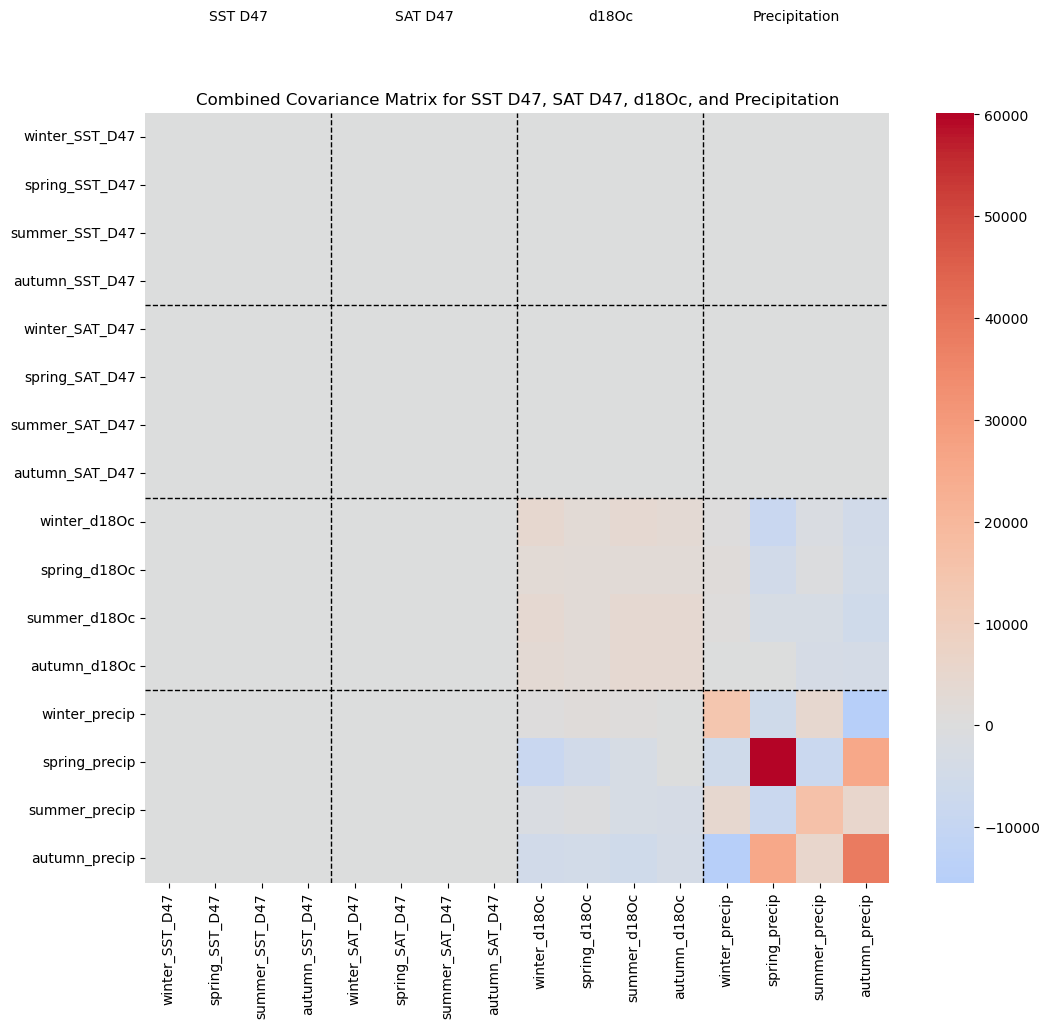

In [113]:
# Extract the relevant columns for SST, SAT D47, d18Oc, and precipitation
SST_D47_columns_seasonal = [f"{season}_SST_D47" for season in seasons]
SAT_D47_columns_seasonal = [f"{season}_SAT_D47" for season in seasons]
d18Oc_columns_seasonal = [f"{season}_d18Oc" for season in seasons]
precip_columns_seasonal = [f"{season}_precip" for season in seasons]

# Combine the relevant columns into a single dataframe
combined_data_seasonal = IPCC_Atlas_seasonal[
    SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
]

# Calculate the covariance matrix for the combined data
cov_combined_seasonal = np.cov(combined_data_seasonal.dropna(), rowvar=False)

# Extract the covariance matrices for each variable
cov_SST_D47_seasonal = cov_combined_seasonal[:len(seasons), :len(seasons)]
cov_SAT_D47_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), len(seasons):2*len(seasons)]
cov_d18Oc_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 2*len(seasons):3*len(seasons)]
cov_precip_seasonal = cov_combined_seasonal[3*len(seasons):, 3*len(seasons):]

# Extract the cross-covariance matrices
cross_cov_SST_SAT_D47_seasonal = cov_combined_seasonal[:len(seasons), len(seasons):2*len(seasons)]
cross_cov_SST_d18Oc_seasonal = cov_combined_seasonal[:len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SST_precip_seasonal = cov_combined_seasonal[:len(seasons), 3*len(seasons):]
cross_cov_SAT_d18Oc_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SAT_precip_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 3*len(seasons):]
cross_cov_d18Oc_precip_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 3*len(seasons):]

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    np.round(cov_combined_seasonal * 10**4, 1),  # Scale by 10^4 for better visualization and round values
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal,
    yticklabels=SST_D47_columns_seasonal + SAT_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
)

# Add titles to the axes per parameter
plt.axvline(x=len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SST_D47_columns_seasonal) / 2, -2, 'SST D47', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) / 2, -2, 'SAT D47', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, -2, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SST_D47_columns_seasonal) + len(SAT_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, -2, 'Precipitation', ha='center', va='center', fontsize=10)

plt.title("Combined Covariance Matrix for SST D47, SAT D47, d18Oc, and Precipitation")
plt.show()

## Plot normalized seasonal covariance matrix between D47 values of SST and SAT, d18Oc and precipitation

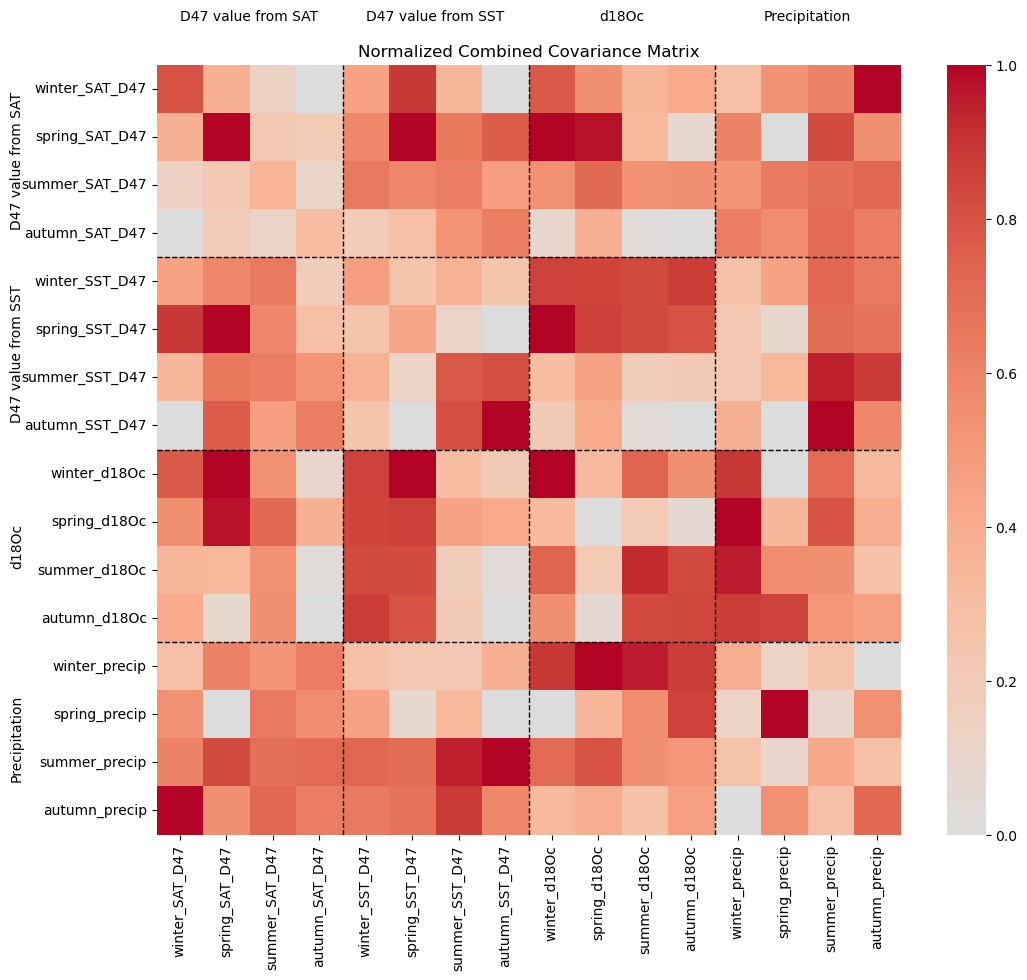

In [114]:
# Normalize each submatrix independently for better visualization
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

# Extract the covariance matrices for SAT D47, SST D47, d18Oc, and precipitation
cov_SAT_D47_seasonal = cov_combined_seasonal[:len(seasons), :len(seasons)]
cov_SST_D47_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), len(seasons):2*len(seasons)]
cov_d18Oc_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 2*len(seasons):3*len(seasons)]
cov_precip_seasonal = cov_combined_seasonal[3*len(seasons):, 3*len(seasons):]

# Extract the cross-covariance matrices
cross_cov_SAT_SST_D47_seasonal = cov_combined_seasonal[:len(seasons), len(seasons):2*len(seasons)]
cross_cov_SAT_d18Oc_seasonal = cov_combined_seasonal[:len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SAT_precip_seasonal = cov_combined_seasonal[:len(seasons), 3*len(seasons):]
cross_cov_SST_d18Oc_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 2*len(seasons):3*len(seasons)]
cross_cov_SST_precip_seasonal = cov_combined_seasonal[len(seasons):2*len(seasons), 3*len(seasons):]
cross_cov_d18Oc_precip_seasonal = cov_combined_seasonal[2*len(seasons):3*len(seasons), 3*len(seasons):]

# Normalize each submatrix
normalized_cov_SAT_D47_seasonal = normalize_matrix(cov_SAT_D47_seasonal)
normalized_cov_SST_D47_seasonal = normalize_matrix(cov_SST_D47_seasonal)
normalized_cov_d18Oc_seasonal = normalize_matrix(cov_d18Oc_seasonal)
normalized_cov_precip_seasonal = normalize_matrix(cov_precip_seasonal)

# Normalize each cross-covariance matrix
normalized_cross_cov_SAT_SST_D47_seasonal = normalize_matrix(cross_cov_SAT_SST_D47_seasonal)
normalized_cross_cov_SAT_d18Oc_seasonal = normalize_matrix(cross_cov_SAT_d18Oc_seasonal)
normalized_cross_cov_SAT_precip_seasonal = normalize_matrix(cross_cov_SAT_precip_seasonal)
normalized_cross_cov_SST_d18Oc_seasonal = normalize_matrix(cross_cov_SST_d18Oc_seasonal)
normalized_cross_cov_SST_precip_seasonal = normalize_matrix(cross_cov_SST_precip_seasonal)
normalized_cross_cov_d18Oc_precip_seasonal = normalize_matrix(cross_cov_d18Oc_precip_seasonal)

# Combine the normalized submatrices into a single normalized covariance matrix
normalized_cov_combined_seasonal = np.block([
    [normalized_cov_SAT_D47_seasonal, normalized_cross_cov_SAT_SST_D47_seasonal, normalized_cross_cov_SAT_d18Oc_seasonal, normalized_cross_cov_SAT_precip_seasonal],
    [normalized_cross_cov_SAT_SST_D47_seasonal.T, normalized_cov_SST_D47_seasonal, normalized_cross_cov_SST_d18Oc_seasonal, normalized_cross_cov_SST_precip_seasonal],
    [normalized_cross_cov_SAT_d18Oc_seasonal.T, normalized_cross_cov_SST_d18Oc_seasonal.T, normalized_cov_d18Oc_seasonal, normalized_cross_cov_d18Oc_precip_seasonal],
    [normalized_cross_cov_SAT_precip_seasonal.T, normalized_cross_cov_SST_precip_seasonal.T, normalized_cross_cov_d18Oc_precip_seasonal.T, normalized_cov_precip_seasonal]
])

# Plot the heatmap of the normalized combined covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    normalized_cov_combined_seasonal,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=SAT_D47_columns_seasonal + SST_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal,
    yticklabels=SAT_D47_columns_seasonal + SST_D47_columns_seasonal + d18Oc_columns_seasonal + precip_columns_seasonal
)

# Add titles to the axes per parameter
plt.axvline(x=len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

plt.axhline(y=len(SAT_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal), color='black', linestyle='--', linewidth=1)
plt.axhline(y=len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal), color='black', linestyle='--', linewidth=1)

# Add parameter labels
plt.text(len(SAT_D47_columns_seasonal) / 2, -1, 'D47 value from SAT', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) / 2, -1, 'D47 value from SST', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, -1, 'd18Oc', ha='center', va='center', fontsize=10)
plt.text(len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, -1, 'Precipitation', ha='center', va='center', fontsize=10)

plt.text(-3, len(SAT_D47_columns_seasonal) / 2, 'D47 value from SAT', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) / 2, 'D47 value from SST', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) / 2, 'd18Oc', ha='center', va='center', rotation=90, fontsize=10)
plt.text(-3, len(SAT_D47_columns_seasonal) + len(SST_D47_columns_seasonal) + len(d18Oc_columns_seasonal) + len(precip_columns_seasonal) / 2, 'Precipitation', ha='center', va='center', rotation=90, fontsize=10)

plt.title("Normalized Combined Covariance Matrix")
plt.show()

## Create combined seasonal state vector

In [115]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_seasonal_combined = np.concatenate((mu_prior_SST_D47_seasonal, mu_prior_SAT_D47_seasonal, mu_prior_d18Oc_seasonal, mu_prior_precip_seasonal))

# Combine the covariance matrices of D47 values of SST and SAT, d18Oc and precipitation including the cross-covariance
cov_prior_seasonal_combined = cov_combined_seasonal.copy()

# OBSERVATIONS
## Load clumped data for updating

### Monthly and seasonal data based on age model

In [116]:
# Load measurements and format them into a dictionary
# These are the actual individual D47 measurements and ShellChron outcomes and thus come with a time uncertainty which can be propagated.
Caldarescu_data = pd.read_csv('Modern case/Caldarescu_data.csv') # Load the data into Python and in the Jupyter environment.
Caldarescu_data_dict = Caldarescu_data.to_dict('records') # Convert to dictionary with column headers as keys

# Extract measurements and uncertainties from the dictionary, skipping missing values
D47_measurements_individual = [measurement["D47"] for measurement in Caldarescu_data_dict if not pd.isna(measurement["D47"])] # Extract the D47 values
d18Oc_measurements_individual = [measurement["Final_d18Ocarb_VPDB"] for measurement in Caldarescu_data_dict if not pd.isna(measurement["Final_d18Ocarb_VPDB"])] # Extract the d18Oc values
D47_measurement_uncertainties_individual = [measurement["D47_SD"] ** 2 for measurement in Caldarescu_data_dict if not pd.isna(measurement["D47"])] # Square the standard deviation to get the variance
d18Oc_measurement_uncertainties_individual = [measurement["d18O_SD"] ** 2 for measurement in Caldarescu_data_dict if not pd.isna(measurement["Final_d18Ocarb_VPDB"])] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_individual = np.array(D47_measurements_individual + d18Oc_measurements_individual).reshape(-1, 1)

# Convert estimated day of year to month (0-11) and season (0-3), set errors to 0
for record in Caldarescu_data_dict:
    doy = record.get("Estimated day of year", np.nan)
    if not pd.isna(doy):
        record["month_score"] = int(doy / 365 * 12) % 12  # month index 0-11
        record["season_score"] = int(doy / 365 * 4) % 4    # season index 0-3
    else:
        record["month_score"] = np.nan
        record["season_score"] = np.nan
    record["Month_err"] = 0
    record["Season_err"] = 0

# Print excerpt of the dictionary to check format
print(Caldarescu_data_dict[1])

{'SampName': 'M5_115', 'Specimen': 'M5', 'SampNum': 115, 'Time of year': 'Apr/Oct', 'Increment number': 2, 'Estimated date': '01/10/2005', 'Estimated day of year': 273.0, 'Final_d13Ccarb': -0.01, 'd13C_SD': 0.030214895, 'Final_d18Ocarb_VPDB': -4.32, 'd18O_SD': 0.059240652, 'D47rfac': 0.644, 'D47': 0.582, 'D47_SD': 0.039056165, 'month_score': 8, 'season_score': 2, 'Month_err': 0, 'Season_err': 0}


## Prepare measurement and observation matrices

In [117]:
# Create the observation matrix H for monthly data based on individual measurements
N_measurements = len(Z_individual)
H_monthly = np.zeros((N_measurements, len(mu_prior_monthly_combined)))

# Fill the first part of the observation matrix H with ones at the positions corresponding to the D47 measurements, ignoring NaN values
for i, measurement in enumerate([m for m in Caldarescu_data_dict if not pd.isna(m["D47"])]):
    time_index = int(measurement["month_score"])
    H_monthly[i, time_index] = 1  # Indexing the first set of columns (1:12) for SST_D47

# Fill the second part of the observation matrix H with ones at the positions corresponding to the d18Oc measurements, ignoring NaN values
for i, measurement in enumerate([m for m in Caldarescu_data_dict if not pd.isna(m["Final_d18Ocarb_VPDB"])]):
    time_index = int(measurement["month_score"])
    H_monthly[i + len(D47_measurements_individual), time_index + 24] = 1  # Indexing the third column block (25:36) for d18Oc

print(H_monthly)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Observations on seasonal scale

### Measurement matrix for seasonally aggregated D47 values

In [118]:
# Define the list of season names for integer indexing
season_names = ["winter", "spring", "summer", "autumn"]

# Initialize dictionaries to store aggregated measurements and uncertainties per season
D47_measurements_seasonal = {season: [] for season in season_names}
d18Oc_measurements_seasonal = {season: [] for season in season_names}
D47_measurement_uncertainties_seasonal = {season: [] for season in season_names}
d18Oc_measurement_uncertainties_seasonal = {season: [] for season in season_names}
print(D47_measurements_seasonal)

for measurement in Caldarescu_data_dict:
    if not pd.isna(measurement["D47"]):
        season_index = int(measurement["season_score"])
        D47_measurements_seasonal[season_names[season_index]].append(measurement["D47"])
        D47_measurement_uncertainties_seasonal[season_names[season_index]].append(measurement["D47_SD"] ** 2)
    if not pd.isna(measurement["Final_d18Ocarb_VPDB"]):
        season_index = int(measurement["season_score"])
        d18Oc_measurements_seasonal[season_names[season_index]].append(measurement["Final_d18Ocarb_VPDB"])
        d18Oc_measurement_uncertainties_seasonal[season_names[season_index]].append(measurement["d18O_SD"] ** 2)

# Calculate weighted mean and propagated uncertainty for each season
D47_aggregated_measurements_seasonal = []
d18Oc_aggregated_measurements_seasonal = []
D47_aggregated_uncertainties_seasonal = []
d18Oc_aggregated_uncertainties_seasonal = []

for season in season_names:
    if D47_measurements_seasonal[season]:
        weights = 1 / np.array(D47_measurement_uncertainties_seasonal[season])
        weighted_mean = np.sum(np.array(D47_measurements_seasonal[season]) * weights) / np.sum(weights)
        measurement_variance = np.var(D47_measurements_seasonal[season], ddof=1)
        propagated_uncertainty = np.sqrt(1 / np.sum(weights) + measurement_variance)
        propagated_standard_error = propagated_uncertainty / np.sqrt(len(D47_measurements_seasonal[season])) # Assemble D47 data as SE (optional)
        D47_aggregated_measurements_seasonal.append(weighted_mean)
        D47_aggregated_uncertainties_seasonal.append(propagated_uncertainty ** 2)
    if d18Oc_measurements_seasonal[season]:
        weights = 1 / np.array(d18Oc_measurement_uncertainties_seasonal[season])
        weighted_mean = np.sum(np.array(d18Oc_measurements_seasonal[season]) * weights) / np.sum(weights)
        measurement_variance = np.var(d18Oc_measurements_seasonal[season], ddof=1)
        propagated_uncertainty = np.sqrt(1 / np.sum(weights) + measurement_variance)
        d18Oc_aggregated_measurements_seasonal.append(weighted_mean)
        d18Oc_aggregated_uncertainties_seasonal.append(propagated_uncertainty ** 2)

# OPTIONAL: Lower boundary d18Oc varaince at 0.01 (equivalent to 0.1 per mil measuremetn uncertainty)
d18Oc_aggregated_uncertainties_seasonal = [max(uncertainty, 0.01) for uncertainty in d18Oc_aggregated_uncertainties_seasonal]

# Create the measurement matrix Z
Z_seasonal_aggregated = np.array(D47_aggregated_measurements_seasonal + d18Oc_aggregated_measurements_seasonal).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_seasonal_aggregated = np.diag(D47_aggregated_uncertainties_seasonal + d18Oc_aggregated_uncertainties_seasonal)  # Diagonal matrix of measurement uncertainties

print("Z_seasonal_aggregated:", Z_seasonal_aggregated)
print("R_seasonal_aggregated:", R_seasonal_aggregated)

{'winter': [], 'spring': [], 'summer': [], 'autumn': []}
Z_seasonal_aggregated: [[ 0.6203526 ]
 [ 0.60752459]
 [ 0.58873077]
 [ 0.60630233]
 [-1.66855491]
 [-2.19754098]
 [-4.05653846]
 [-2.77790698]]
R_seasonal_aggregated: [[2.25072127e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.33469318e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.07753232e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.88021380e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.22199900e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.46025638e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.0000000

### Observation matrix for seasonally aggregated D47 data

In [119]:
# Create the observation matrix H for seasonally aggregated data

# Define the number of seasons or months
num_seasons = 4

# Number of seasonally aggregated measurements
N_measurements_seasonal_aggregated = len(Z_seasonal_aggregated)
H_seasonal_aggregated = np.zeros((N_measurements_seasonal_aggregated, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(Z_seasonal_aggregated):
    if i < N_measurements_seasonal_aggregated // 2:
        time_index = i % num_seasons  # Ensure the index is within the range of seasons
        H_seasonal_aggregated[i, time_index] = 1
    else:
        time_index = i % num_seasons
        H_seasonal_aggregated[i, time_index + 8] = 1

print(H_seasonal_aggregated)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


## Observations on monthly scale

### Measurement matrix for monthly aggregated D47 values

In [120]:
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']  # List full month names

# Initialize dictionaries to store aggregated measurements and uncertainties per month
D47_measurements_monthly = {month: [] for month in month_names}
d18Oc_measurements_monthly = {month: [] for month in month_names}
D47_measurement_uncertainties_monthly = {month: [] for month in month_names}
d18Oc_measurement_uncertainties_monthly = {month: [] for month in month_names}

# Aggregate measurements and uncertainties per month
for measurement in Caldarescu_data_dict:
    if not pd.isna(measurement["D47"]):
        month_index = int(measurement["month_score"])
        D47_measurements_monthly[month_names[month_index]].append(measurement["D47"])
        D47_measurement_uncertainties_monthly[month_names[month_index]].append(measurement["D47_SD"] ** 2)
    if not pd.isna(measurement["Final_d18Ocarb_VPDB"]):
        month_index = int(measurement["month_score"])
        d18Oc_measurements_monthly[month_names[month_index]].append(measurement["Final_d18Ocarb_VPDB"])
        d18Oc_measurement_uncertainties_monthly[month_names[month_index]].append(measurement["d18O_SD"] ** 2)

# Calculate weighted mean and propagated uncertainty for each month
D47_aggregated_measurements_monthly = []
d18Oc_aggregated_measurements_monthly = []
D47_aggregated_uncertainties_monthly = []
d18Oc_aggregated_uncertainties_monthly = []

for month in month_names:
    if D47_measurements_monthly[month]:
        weights = 1 / np.array(D47_measurement_uncertainties_monthly[month])
        weighted_mean = np.sum(np.array(D47_measurements_monthly[month]) * weights) / np.sum(weights)
        measurement_variance = np.var(D47_measurements_monthly[month], ddof=1)
        propagated_uncertainty = np.sqrt(1 / np.sum(weights) + measurement_variance)
        propagated_standard_error = propagated_uncertainty / np.sqrt(len(D47_measurements_monthly[month]))  # Assemble D47 data as SE (optional)
        D47_aggregated_measurements_monthly.append(weighted_mean)
        D47_aggregated_uncertainties_monthly.append(propagated_uncertainty ** 2) # Assemble D47 data as SE
    if d18Oc_measurements_monthly[month]:
        weights = 1 / np.array(d18Oc_measurement_uncertainties_monthly[month])
        weighted_mean = np.sum(np.array(d18Oc_measurements_monthly[month]) * weights) / np.sum(weights)
        measurement_variance = np.var(d18Oc_measurements_monthly[month], ddof=1)
        propagated_uncertainty = np.sqrt(1 / np.sum(weights) + measurement_variance)
        d18Oc_aggregated_measurements_monthly.append(weighted_mean)
        d18Oc_aggregated_uncertainties_monthly.append(propagated_uncertainty ** 2)

# OPTIONAL: Lower boundary d18Oc varaince at 0.01 (equivalent to 0.1 per mil measuremetn uncertainty)
d18Oc_aggregated_uncertainties_monthly = [max(uncertainty, 0.01) for uncertainty in d18Oc_aggregated_uncertainties_monthly]

# Create the measurement matrix Z
Z_monthly_aggregated = np.array(D47_aggregated_measurements_monthly + d18Oc_aggregated_measurements_monthly).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_monthly_aggregated = np.diag(D47_aggregated_uncertainties_monthly + d18Oc_aggregated_uncertainties_monthly)  # Diagonal matrix of measurement uncertainties

print("Z_monthly_aggregated:", Z_monthly_aggregated)
print("R_monthly_aggregated:", R_monthly_aggregated)

Z_monthly_aggregated: [[ 0.60602128]
 [ 0.62462903]
 [ 0.62673437]
 [ 0.60375   ]
 [ 0.61565217]
 [ 0.5994    ]
 [ 0.594375  ]
 [ 0.58444444]
 [ 0.588     ]
 [ 0.61542857]
 [ 0.616375  ]
 [ 0.60114286]
 [-2.8387234 ]
 [-1.22677419]
 [-1.2371875 ]
 [-1.7525    ]
 [-2.16      ]
 [-3.53      ]
 [-3.66625   ]
 [-4.02333333]
 [-4.43666667]
 [-1.96142857]
 [-1.995     ]
 [-3.20571429]]
R_monthly_aggregated: [[2.09378060e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.79716801e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00

### Observation matrix for monthly aggregated D47 data

In [121]:
# Create the observation matrix H for monthly aggregated data

# Define the number of seasons or months
num_months = 12

# Number of monthly aggregated measurements
N_measurements_monthly_aggregated = len(Z_monthly_aggregated)
H_monthly_aggregated = np.zeros((N_measurements_monthly_aggregated, len(mu_prior_monthly_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(Z_monthly_aggregated):
    if i < N_measurements_monthly_aggregated // 2:
        time_index = i % num_months  # Ensure the index is within the range of months
        H_monthly_aggregated[i, time_index] = 1
    else:
        time_index = i % num_months
        H_monthly_aggregated[i, time_index + 24] = 1

print(H_monthly_aggregated)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# PLOT PRIOR AND LIKELIHOOD FOR MANUSCRIPT

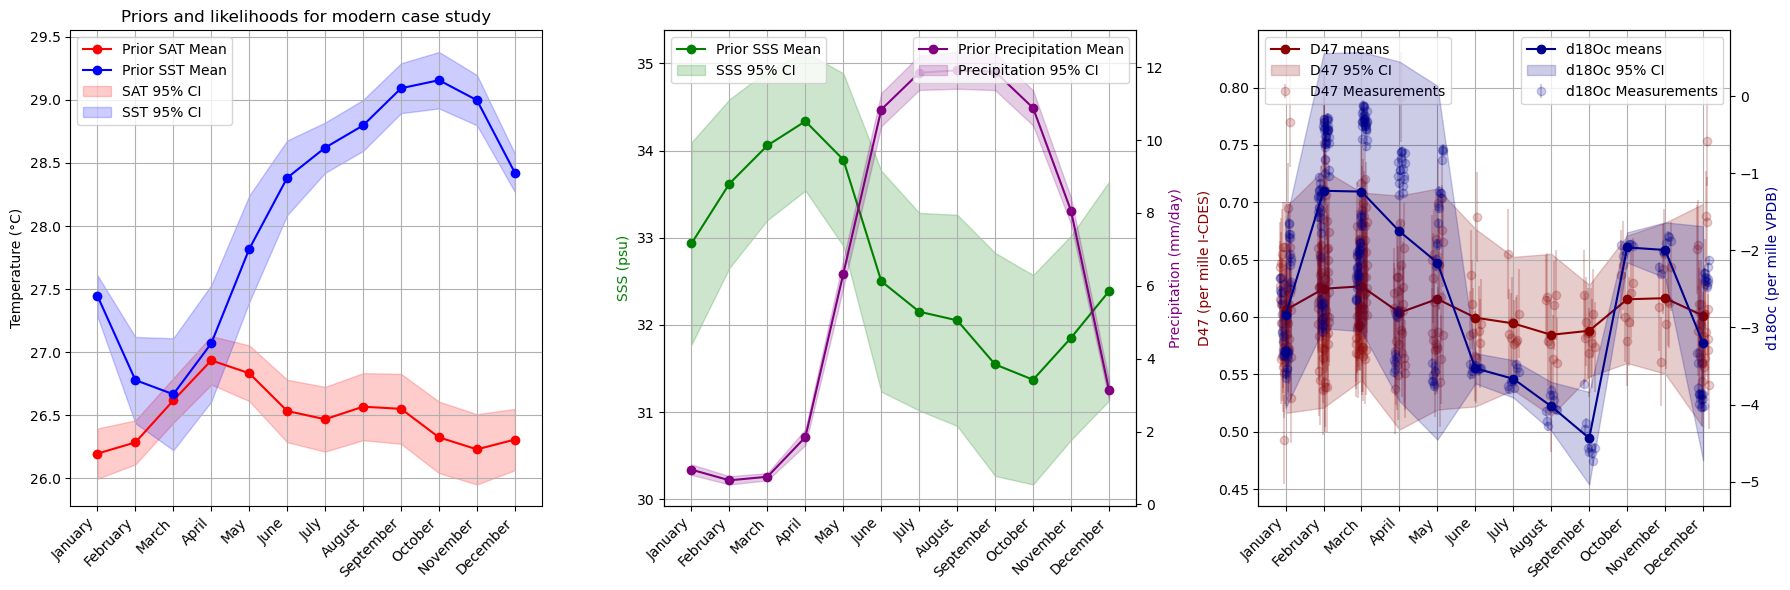

In [122]:
# Set dimensions of data
n_gridcells_monthly = len(IPCC_Atlas["lat"])  # Find the total number of models (use monthly data because monthly data has this column duplicated 3 times)

# Create list of month names
months = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

# Create a monthly scale for the x-axis
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']  # List full month names
months_scale = np.arange(len(months)) + 1  # Create monthly scale

# Create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Panel 1: Plot the prior distribution for SST and SAT
axes[0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o', color='r')
axes[0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o', color='b')

# Add 95% confidence intervals for SAT
axes[0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='r', label='SAT 95% CI'
)

# Add 95% confidence intervals for SST
axes[0].fill_between(
    months_scale,
    mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='b', label='SST 95% CI'
)

# axes[0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST & SAT Values')
axes[0].set_title('Priors and likelihoods for modern case study')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True)

# Panel 2: Plot the prior distribution for SSS and precipitation
axes[1].plot(months_scale, mu_prior_SSS_monthly, label='Prior SSS Mean', marker='o', color='g')
ax2 = axes[1].twinx()  # Create a secondary y-axis for precipitation
ax2.plot(months_scale, mu_prior_precip_monthly, label='Prior Precipitation Mean', marker='o', color='purple')

# Add 95% confidence intervals for SSS
axes[1].fill_between(
    months_scale,
    mu_prior_SSS_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SSS_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='g', label='SSS 95% CI'
)

# Add 95% confidence intervals for precipitation
ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_precip_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, color='purple', label='Precipitation 95% CI'
)

axes[1].set_ylabel('SSS (psu)', color='g')
ax2.set_ylabel('Precipitation (mm/day)', color='purple')
# axes[1].set_title('Prior Mean and 95% Confidence Interval for Monthly SSS & Precipitation Values')
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1].grid(True)

# Panel 3: Plot the likelihood distribution for D47 and d18Oc measurements
# Plot individual (non-aggregated) measurements with uncertainties
ax3 = axes[2].twinx()  # secondary y-axis for d18Oc

d47_label_done = False
d18_label_done = False

for i, month in enumerate(month_names):
    # D47 points for this month
    d47_vals = D47_measurements_monthly[month]
    d47_vars = D47_measurement_uncertainties_monthly[month]
    if d47_vals:
        x = months_scale[i] + (np.linspace(-0.15, 0.15, len(d47_vals)) if len(d47_vals) > 1 else [0])
        y = np.array(d47_vals)
        yerr = np.sqrt(np.array(d47_vars))
        axes[2].errorbar(x, y, yerr=yerr, fmt='o', color='darkred', alpha=0.2,
                         label='D47 Measurements' if not d47_label_done else None)
        d47_label_done = True

    # d18O points for this month
    d18_vals = d18Oc_measurements_monthly[month]
    d18_vars = d18Oc_measurement_uncertainties_monthly[month]
    if d18_vals:
        x2 = months_scale[i] + (np.linspace(-0.15, 0.15, len(d18_vals)) if len(d18_vals) > 1 else [0])
        y2 = np.array(d18_vals)
        y2err = np.sqrt(np.array(d18_vars))
        ax3.errorbar(x2, y2, yerr=y2err, fmt='o', color='darkblue', alpha=0.2,
                     label='d18Oc Measurements' if not d18_label_done else None)
        d18_label_done = True

# Plot aggregated measurements with uncertainties
axes[2].plot(months_scale, D47_aggregated_measurements_monthly, marker='o', label='D47 means', color='darkred')
ax3.plot(months_scale, d18Oc_aggregated_measurements_monthly, marker='o', label='d18Oc means', color='darkblue')

# Add 95% confidence intervals for D47 measurements
axes[2].fill_between(
    months_scale,
    np.array(D47_aggregated_measurements_monthly) - 1.96 * np.sqrt(D47_aggregated_uncertainties_monthly),
    np.array(D47_aggregated_measurements_monthly) + 1.96 * np.sqrt(D47_aggregated_uncertainties_monthly),
    alpha=0.2, color='darkred', label='D47 95% CI'
)

# Add 95% confidence intervals for d18Oc measurements
ax3.fill_between(
    months_scale,
    np.array(d18Oc_aggregated_measurements_monthly) - 1.96 * np.sqrt(d18Oc_aggregated_uncertainties_monthly),
    np.array(d18Oc_aggregated_measurements_monthly) + 1.96 * np.sqrt(d18Oc_aggregated_uncertainties_monthly),
    alpha=0.2, color='darkblue', label='d18Oc 95% CI'
)
axes[2].set_ylabel('D47 (per mille I-CDES)', color='darkred')
ax3.set_ylabel('d18Oc (per mille VPDB)', color='darkblue')
# axes[2].set_title('Aggregated Monthly D47 and d18Oc Measurements with Uncertainties')
axes[2].legend(loc='upper left')
ax3.legend(loc='upper right')
axes[2].grid(True)

# Update the x-axis with month names
axes[2].set_xticks(months_scale)
axes[0].set_xticklabels(month_names, rotation=45, ha="right")
axes[1].set_xticklabels(month_names, rotation=45, ha="right")
axes[2].set_xticklabels(month_names, rotation=45, ha="right")

# Set tight layout
plt.tight_layout()

# DEFINE UPDATING FUNCTIONS

## Create updating function (Kalman filter)
- Include updating of additional variables (SAT and precipitation) through cross-covariance with measured variables (D47_SST and d18Oc)
- Use block updating

Input:
- Prior means (mu_prior)
- Prior covariance matrix (P)
- Observation matrix (H)
- Measurement matrix (Z)
- Uncertainty matrix (R)

Output:
- Posterior means (mu_post)
- Posterior covariance matrix (P_post)

In [123]:
def kalman_update_block(
    mu_prior: np.ndarray,
    cov_prior: np.ndarray,
    Z: np.ndarray,
    R: np.ndarray,
    H: np.ndarray,
    debug_print: bool = False
):
    """
    Perform a Kalman update step for a block of observations.

    Parameters:
    mu_prior (np.ndarray): The prior mean vector.
    cov_prior (np.ndarray): The prior covariance matrix.
    Z (np.ndarray): The measurement matrix.
    R (np.ndarray): The measurement noise covariance matrix.
    H (np.ndarray): The observation matrix.
    debug_print (bool): If True, print debug statements.

    Returns:
    mu_posterior (np.ndarray): The posterior mean vector.
    cov_posterior (np.ndarray): The posterior covariance matrix.
    """
    if debug_print:
        # Print shapes of key variables for debugging
        print("Shape of cov_prior:", cov_prior.shape)
        print("Shape of H:", H.shape)
        print("Shape of R:", R.shape)
        print("Shape of mu_prior:", mu_prior.shape)
        print("Shape of Z:", Z.shape)

    # Compute the Kalman gain
    K = cov_prior @ H.T @ np.linalg.inv(H @ cov_prior @ H.T + R)
    if debug_print:
        print("Shape of K:", K.shape)
        print("K matrix:", K)

    # In-between steps for debugging
    Y_hat = H @ mu_prior  # Compute the predicted observation
    if debug_print:
        print("Shape of Y_hat:", Y_hat.shape)
    innovation = Z - Y_hat.reshape(-1, 1)  # Compute the innovation
    if debug_print:
        print("Shape of innovation:", innovation.shape)
    kalman_gain = K @ innovation  # Compute the Kalman gain
    if debug_print:
        print("Shape of kalman_gain:", kalman_gain.shape)

    # Update the posterior mean estimate
    mu_posterior = mu_prior + kalman_gain.flatten()

    # Update the posterior covariance estimate
    cov_posterior = cov_prior - K @ H @ cov_prior

    return mu_posterior, cov_posterior

## Create function to track the statistics of the likelihood (combining just the reconstruction data)

In [124]:
# Create function to keep track of the likelihood statistics and data

# Suppress FutureWarning
# warnings.simplefilter(action = 'ignore', category = FutureWarning)

def likelihood_statistics_multi(
    weighted_sum,
    effective_weights_total,
    n_update,
    data_library,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_names = ["Variable_name1", "Variable_name2"],
    Variable_names_SDs = ["Variable_name_SD1", "Variable_name_SD2"]
):
    """
    Incrementally updates the likelihood statistics for seasonal data.

    Parameters:
    - weighted_sum: list
        List tracking the mean times the effective weight for each time bin and variable.
    - effective_weights_total: list
        List tracking the sum of effective weights for each time bin and variable.
    - n_update: list
        List tracking the number of datapoints for each time bin and variable.
    - data_library: dict
        Dictionary tracking individual data points and their uncertainties.
    - measurement: dict
        A single measurement containing data on multiple variables.
    - timestamp: str
        Key in the measurement dictionary for the timestamp (0-based index).
    - timestamp_sd: float
        Standard deviation of uncertainty in the timestamp.
    - Variable_name: list of str
        Key in the measurement dictionary for the variables (e.g. d18Oc, D47).
    - Variable_name_SD: list of str
        Key in the measurement dictionary for the standard deviation on the variables (e.g. d18Oc, D47).
    """
    # Check if at least one combination of variable name and its SD is present in the measurement
    found = False
    for var_name, var_sd_name in zip(Variable_names, Variable_names_SDs):
        if var_name in measurement and var_sd_name in measurement:
            found = True
            break

    if timestamp in measurement and found:
        # Extract the time and data values from the measurement
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        # Loop through all variable/SD pairs
        for var_name, var_sd_name in zip(Variable_names, Variable_names_SDs):
            if var_name in measurement and var_sd_name in measurement:
                data_val = measurement[var_name]
                data_sd = measurement[var_sd_name]
                
                # Check if the data is valid
                if not np.isnan(data_val) and not np.isnan(data_sd):
                    # Calculate the weight (inverse of variance)
                    weight = 1 / (data_sd ** 2)

                    # Determine the number of bins
                    num_bins_seasonal = int(len(weighted_sum) / len(Variable_names))
                    # Ensure num_bins_seasonal is an integer
                    bin_indices = np.arange(num_bins_seasonal, dtype=np.float64)

                    # Calculate the probability density for each bin
                    if time_sd == 0:  # Catch cases where the time uncertainty is zero (or unknown)
                        probabilities = np.zeros(num_bins_seasonal, dtype=np.float64)
                        bin_index = int(time) % num_bins_seasonal  # Ensure the bin index is within range
                        probabilities[bin_index] = 1  # Set the probability to 1 for the correct bin
                    else:
                        probabilities = stats.norm.pdf(bin_indices, loc=time, scale=time_sd)  # For non-zero time uncertainty, use a normal distribution
                        probabilities /= probabilities.sum()  # Normalize to ensure the sum of probabilities is 1

                    for i, prob in enumerate(probabilities):  # Loop over all possible bin numbers in the probability vector
                        bin_index = i % num_bins_seasonal  # Wrap around to the first bin if it overflows

                        # Update the weighted sums and sample count
                        effective_weight = weight * prob
                        var_idx = Variable_names.index(var_name)  # Find the index of the variable
                        idx = int(var_idx * num_bins_seasonal + bin_index)  # Unique index for (variable, bin)
                        if weighted_sum[idx] is None:
                            weighted_sum[idx] = 0
                            effective_weights_total[idx] = 0
                        weighted_sum[idx] = weighted_sum[idx] + data_val * effective_weight
                        effective_weights_total[idx] = effective_weights_total[idx] + effective_weight

                    # Update n_update for the correct variable and bin
                    var_idx = Variable_names.index(var_name) # Find the index of the variable
                    n_update[var_idx * num_bins_seasonal + (int(time) % num_bins_seasonal)] += 1  # update sample number per bin and variable

                    # Track individual data points and their uncertainties
                    key = (var_name, int(time)) # Store individual data points in a dictionary with (variable, time) as key
                    if key not in data_library:
                        data_library[key] = []  # Initialize the list for a new (time, var_name) pair
                    data_library[key].append((time_sd, data_val, data_sd))
    return weighted_sum, effective_weights_total, n_update, data_library # Return the updated values

# EXECUTE UPDATING FUNCTIONS - SEASONAL

## Update seasonal prior with data preaggregated per season
* Assemble data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Use pre-aggregated D47 data on seasonal scale

In [125]:
# Update the seasonal prior with all measurements assigned to the seasons according to the DOY_rotated field
seasonal_aggregated_data = {} # Keep track of datapoints per season
n_update_seasonal_aggregated = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal_aggregated = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal_aggregated = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal_aggregated = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal_aggregated = np.concatenate([mu_prior_SST_D47_seasonal * 0, mu_prior_d18Oc_seasonal * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
var_names = ["D47", "Final_d18Ocarb_VPDB"] # List of variable names which are updated
var_SD_names = ["D47_SD", "d18O_SD"] # List of names of variable uncertainties which are updated

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal_aggregated, cov_post_seasonal_aggregated = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_seasonal_aggregated,
    R_seasonal_aggregated,
    H_seasonal_aggregated,
    debug_print = True
)

# Extract the updated mean values from the combined state vector
mu_post_SST_D47_seasonal_aggregated = mu_post_seasonal_aggregated[:len(mu_prior_SST_D47_seasonal)]
mu_post_SAT_D47_seasonal_aggregated = mu_post_seasonal_aggregated[len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal)]
mu_post_d18Oc_seasonal_aggregated = mu_post_seasonal_aggregated[2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal)]
mu_post_precip_seasonal_aggregated = mu_post_seasonal_aggregated[3*len(mu_prior_d18Oc_seasonal):]

# Extract the updated covariance matrices from the combined covariance matrix
cov_post_SST_D47_seasonal_aggregated = cov_post_seasonal_aggregated[:len(mu_prior_SST_D47_seasonal), :len(mu_prior_SST_D47_seasonal)]
cov_post_SAT_D47_seasonal_aggregated = cov_post_seasonal_aggregated[len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal), len(mu_prior_SST_D47_seasonal):2*len(mu_prior_SST_D47_seasonal)]
cov_post_d18Oc_seasonal_aggregated = cov_post_seasonal_aggregated[2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal), 2*len(mu_prior_SST_D47_seasonal):3*len(mu_prior_SST_D47_seasonal)]
cov_post_precip_seasonal_aggregated = cov_post_seasonal_aggregated[3*len(mu_prior_d18Oc_seasonal):, 3*len(mu_prior_d18Oc_seasonal):]

for measurement in Caldarescu_data_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_seasonal_aggregated, effective_weights_total_seasonal_aggregated, n_update_seasonal_aggregated, seasonal_aggregated_data = likelihood_statistics_multi(
        weighted_sum_seasonal_aggregated,
        effective_weights_total_seasonal_aggregated,
        n_update_seasonal_aggregated,
        seasonal_aggregated_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "Season_err",
        Variable_names = var_names,
        Variable_names_SDs = var_SD_names
    )

# Normalize the weighted_sum_seasonal_aggregated to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal_aggregated to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
num_vars = len(var_names)  # number of variables (e.g., D47, d18O)
num_bins_seasonal = int(len(weighted_sum_seasonal_aggregated) / num_vars)

for var_idx, var_name in enumerate(var_names):
    print(f"Results for variable: {var_name}")
    for bin_idx in range(num_bins_seasonal):
        idx = var_idx * num_bins_seasonal + bin_idx
        if effective_weights_total_seasonal_aggregated[idx] is not None and effective_weights_total_seasonal_aggregated[idx] != 0:
            mu_likelihood_seasonal_aggregated[idx] = weighted_sum_seasonal_aggregated[idx] / effective_weights_total_seasonal_aggregated[idx]
            std_likelihood_seasonal_aggregated[idx] = np.sqrt(1 / effective_weights_total_seasonal_aggregated[idx])
        print(f"  Bin {bin_idx + 1}:")
        print(f"    Weighted Average: {mu_likelihood_seasonal_aggregated[idx]}")
        print(f"    Aggregated Uncertainty: {std_likelihood_seasonal_aggregated[idx]}")
        print(f"    Number of Data Points: {n_update_seasonal_aggregated[idx]}")
    print()

print("Original Prior Mean SST-D47 Seasonal:\n", mu_prior_SST_D47_seasonal_original)
print("Original Prior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original)))
print("Updated Posterior Mean SST-D47 Seasonal:\n", mu_post_SST_D47_seasonal_aggregated)
print("Updated Posterior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SST_D47_seasonal_aggregated)))
print("Original Prior Mean SAT-D47 Seasonal:\n", mu_prior_SAT_D47_seasonal_original)
print("Original Prior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_D47_seasonal_original)))
print("Updated Posterior Mean SAT-D47 Seasonal:\n", mu_post_SAT_D47_seasonal_aggregated)
print("Updated Posterior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SAT_D47_seasonal_aggregated)))
print("Original Prior Mean d18Oc Seasonal:\n", mu_prior_d18Oc_seasonal_original)
print("Original Prior Standard Deviation d18Oc Seasonal:\n", np.sqrt(np.diag(cov_prior_d18Oc_seasonal_original)))
print("Updated Posterior Mean d18Oc Seasonal:\n", mu_post_d18Oc_seasonal_aggregated)
print("Updated Posterior Standard Deviation d18Oc Seasonal:\n", np.sqrt(np.diag(cov_post_d18Oc_seasonal_aggregated)))
print("Original Prior Mean precipitation Seasonal:\n", mu_prior_precip_seasonal_original)
print("Original Prior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_prior_precip_seasonal_original)))
print("Updated Posterior Mean precipitation Seasonal:\n", mu_post_precip_seasonal_aggregated)
print("Updated Posterior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)))

Shape of cov_prior: (16, 16)
Shape of H: (8, 16)
Shape of R: (8, 8)
Shape of mu_prior: (16,)
Shape of Z: (8, 1)
Shape of K: (16, 8)
K matrix: [[ 1.84060751e-03  9.18013106e-04  1.77882777e-03  1.76547910e-04
   1.66698760e-04 -2.47276644e-05 -6.45887021e-04 -6.47000437e-05]
 [ 9.52263156e-04  2.04067965e-03  2.25602564e-03  6.34614859e-04
   3.02088303e-04  1.95523348e-04 -6.13606448e-04 -3.97099372e-04]
 [ 5.59363401e-04  6.83905469e-04  3.20256444e-03  5.24714472e-04
  -4.42337555e-05  3.03658844e-05 -2.54373837e-04 -5.26495365e-05]
 [ 1.47485085e-04  5.11078555e-04  1.39395392e-03  7.43626698e-04
  -9.45181961e-05 -1.87943235e-05 -8.26065857e-04 -2.19030593e-04]
 [ 1.12653028e-04  2.07107454e-04  8.15484120e-04 -8.70870380e-05
   2.95001728e-05  3.68410363e-05  9.20966632e-05  6.03603900e-05]
 [ 4.54109654e-04  5.09751771e-04  6.64696187e-04 -5.42562369e-07
   1.03955503e-04  4.19511327e-05  6.71885589e-05  1.09884424e-06]
 [-9.75064244e-05  1.39677588e-04  5.79539930e-04 -2.7954567

### Plot seasonal posterior in D47 and d18O domain based on aggregated data

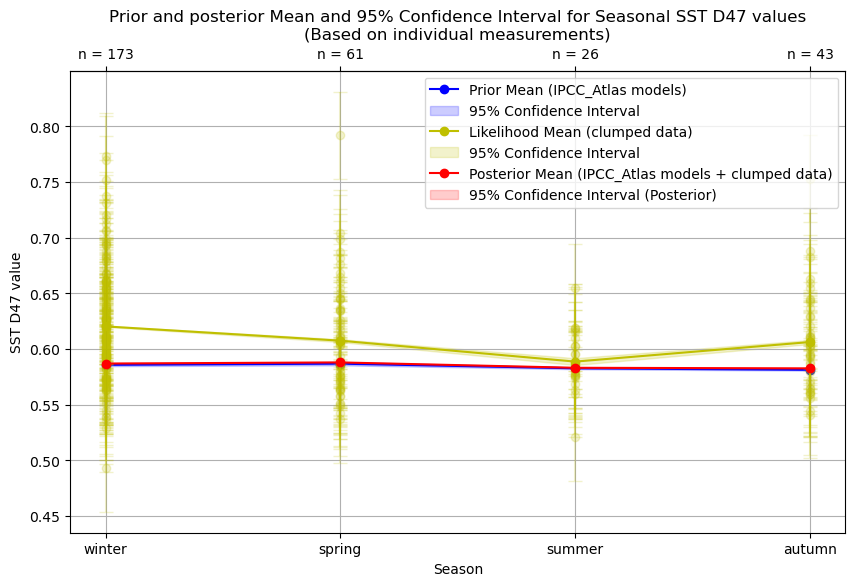

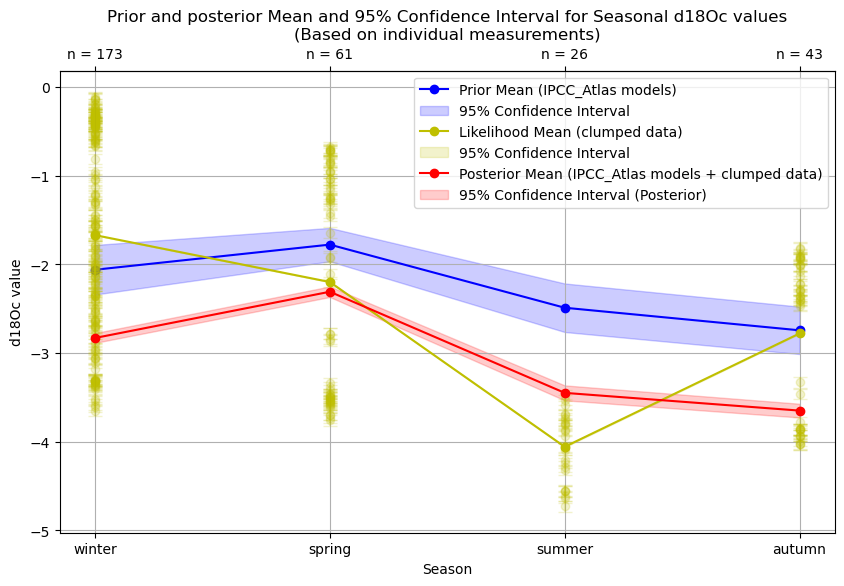

In [126]:
# --- D47 ---

# Plot the updated seasonal posterior for SST_D47
std_post_SST_D47_seasonal_aggregated = np.sqrt(np.diag(cov_post_SST_D47_seasonal_aggregated))
std_prior_SST_D47_seasonal_original = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original))
var_start_D47_seasonal = var_names.index("D47") * num_bins_seasonal # Determine the start index for the D47 variable
var_end_D47_seasonal = var_start_D47_seasonal + num_bins_seasonal # Determine the end index for the D47 variable
n_update_seasonal_aggregated_D47 = n_update_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal]  # Extract the number of updates for D47

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_original, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
plt.fill_between(
    seasons_scale,
    mu_prior_SST_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_D47_seasonal_original / np.sqrt(n_gridcells_seasonal),
    mu_prior_SST_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_D47_seasonal_original / np.sqrt(n_gridcells_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable to parse information from the likelihood statistics
plt.plot(seasons_scale, mu_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    seasons_scale,
    mu_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal] - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47) * std_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal] / np.sqrt(n_update_seasonal_aggregated_D47),
    mu_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal] + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47) * std_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal] / np.sqrt(n_update_seasonal_aggregated_D47),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Caldarescu_data_dict:
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47"], yerr=measurement["D47_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_aggregated_D47])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(seasons_scale, mu_post_SST_D47_seasonal_aggregated, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
plt.fill_between(
    seasons_scale,
    mu_post_SST_D47_seasonal_aggregated - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)) * std_post_SST_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    mu_post_SST_D47_seasonal_aggregated + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)) * std_post_SST_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal SST D47 values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('SST D47 value')
plt.legend()
plt.grid(True)
plt.show()

# ---d18Oc---

# Plot the updated seasonal posterior for d18Oc
std_post_d18Oc_seasonal_aggregated = np.sqrt(np.diag(cov_post_d18Oc_seasonal_aggregated))
std_prior_d18Oc_seasonal_original = np.sqrt(np.diag(cov_prior_d18Oc_seasonal_original))
var_start_d18Oc_seasonal = var_names.index("Final_d18Ocarb_VPDB") * num_bins_seasonal # Determine the start index for the d18Oc variable
var_end_d18Oc_seasonal = var_start_d18Oc_seasonal + num_bins_seasonal # Determine the end index for the d18Oc variable
n_update_seasonal_aggregated_d18Oc = n_update_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal]  # Extract the number of updates for d18Oc

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(seasons_scale, mu_prior_d18Oc_seasonal_original, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
plt.fill_between(
    seasons_scale,
    mu_prior_d18Oc_seasonal_original - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_d18Oc_seasonal_original / np.sqrt(n_gridcells_seasonal),
    mu_prior_d18Oc_seasonal_original + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_d18Oc_seasonal_original / np.sqrt(n_gridcells_seasonal),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable
plt.plot(seasons_scale, mu_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    seasons_scale,
    mu_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_d18Oc) * std_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] / np.sqrt(n_update_seasonal_aggregated_d18Oc),
    mu_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_d18Oc) * std_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] / np.sqrt(n_update_seasonal_aggregated_d18Oc),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Caldarescu_data_dict:
    plt.plot(int(measurement["season_score"]) + 1, measurement["Final_d18Ocarb_VPDB"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["Final_d18Ocarb_VPDB"], yerr=measurement["d18O_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_aggregated_d18Oc])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(seasons_scale, mu_post_d18Oc_seasonal_aggregated, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
plt.fill_between(
    seasons_scale,
    mu_post_d18Oc_seasonal_aggregated - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_d18Oc + n_gridcells_seasonal)) * std_post_d18Oc_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated_d18Oc + n_gridcells_seasonal),
    mu_post_d18Oc_seasonal_aggregated + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_d18Oc + n_gridcells_seasonal)) * std_post_d18Oc_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated_d18Oc + n_gridcells_seasonal),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal d18Oc values\n(Based on individual measurements)')
plt.xlabel('Season')
plt.ylabel('d18Oc value')
plt.legend()
plt.grid(True)
plt.show()

# EXECUTE UPDATING FUNCTIONS - MONTHLY

## Update monthly prior with data (preaggregated data per month)
* Data and model outcomes assembled per month
* Ignore sclero-dating uncertainty
* D47 data aggregated in monthly bins prior to assembly

In [127]:
# Update the seasonal prior with all measurements assigned to the seasons according to the DOY_rotated field
monthly_aggregated_data = {} # Keep track of datapoints per season
n_update_monthly_aggregated = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly_aggregated = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly_aggregated = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly_aggregated = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly_aggregated = np.concatenate([mu_prior_SST_D47_monthly * 0, mu_prior_d18Oc_monthly * 0]) # Vector to store temperature uncertainty per season for confidence interval plotting
var_names = ["D47", "Final_d18Ocarb_VPDB"] # List of variable names which are updated
var_SD_names = ["D47_SD", "d18O_SD"] # List of names of variable uncertainties which are updated

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_monthly_aggregated, cov_post_monthly_aggregated = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated,
    H_monthly_aggregated,
    debug_print = True
)

# Extract the updated mean values from the combined state vector
mu_post_SST_D47_monthly_aggregated = mu_post_monthly_aggregated[:len(mu_prior_SST_D47_monthly)]
mu_post_SAT_D47_monthly_aggregated = mu_post_monthly_aggregated[len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly)]
mu_post_d18Oc_monthly_aggregated = mu_post_monthly_aggregated[2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly)]
mu_post_precip_monthly_aggregated = mu_post_monthly_aggregated[3*len(mu_prior_d18Oc_monthly):]

# Extract the updated covariance matrices from the combined covariance matrix
cov_post_SST_D47_monthly_aggregated = cov_post_monthly_aggregated[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
cov_post_SAT_D47_monthly_aggregated = cov_post_monthly_aggregated[len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly), len(mu_prior_SST_D47_monthly):2*len(mu_prior_SST_D47_monthly)]
cov_post_d18Oc_monthly_aggregated = cov_post_monthly_aggregated[2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly), 2*len(mu_prior_SST_D47_monthly):3*len(mu_prior_SST_D47_monthly)]
cov_post_precip_monthly_aggregated = cov_post_monthly_aggregated[3*len(mu_prior_d18Oc_monthly):, 3*len(mu_prior_d18Oc_monthly):]

for measurement in Caldarescu_data_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_monthly_aggregated, effective_weights_total_monthly_aggregated, n_update_monthly_aggregated, monthly_aggregated_data = likelihood_statistics_multi(
        weighted_sum_monthly_aggregated,
        effective_weights_total_monthly_aggregated,
        n_update_monthly_aggregated,
        monthly_aggregated_data,
        measurement,
        timestamp = "month_score",
        timestamp_sd = "Month_err",
        Variable_names = var_names,
        Variable_names_SDs = var_SD_names
    )

# Normalize the weighted_sum_monthly_aggregated to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly_aggregated to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
num_vars = len(var_names)  # number of variables (e.g., D47, d18O)
num_bins_monthly = int(len(weighted_sum_monthly_aggregated) / num_vars)

for var_idx, var_name in enumerate(var_names):
    print(f"Results for variable: {var_name}")
    for bin_idx in range(num_bins_monthly):
        idx = var_idx * num_bins_monthly + bin_idx
        if effective_weights_total_monthly_aggregated[idx] is not None and effective_weights_total_monthly_aggregated[idx] != 0:
            mu_likelihood_monthly_aggregated[idx] = weighted_sum_monthly_aggregated[idx] / effective_weights_total_monthly_aggregated[idx]
            std_likelihood_monthly_aggregated[idx] = np.sqrt(1 / effective_weights_total_monthly_aggregated[idx])
        print(f"  Bin {bin_idx + 1}:")
        print(f"    Weighted Average: {mu_likelihood_monthly_aggregated[idx]}")
        print(f"    Aggregated Uncertainty: {std_likelihood_monthly_aggregated[idx]}")
        print(f"    Number of Data Points: {n_update_monthly_aggregated[idx]}")
    print()

print("Original Prior Mean SST-D47 Seasonal:\n", mu_prior_SST_D47_monthly_original)
print("Original Prior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SST_D47_monthly_original)))
print("Updated Posterior Mean SST-D47 Seasonal:\n", mu_post_SST_D47_monthly_aggregated)
print("Updated Posterior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated)))
print("Original Prior Mean SAT-D47 Seasonal:\n", mu_prior_SAT_D47_monthly_original)
print("Original Prior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_D47_monthly_original)))
print("Updated Posterior Mean SAT-D47 Seasonal:\n", mu_post_SAT_D47_monthly_aggregated)
print("Updated Posterior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SAT_D47_monthly_aggregated)))
print("Original Prior Mean d18Oc Seasonal:\n", mu_prior_d18Oc_monthly_original)
print("Original Prior Standard Deviation d18Oc Seasonal:\n", np.sqrt(np.diag(cov_prior_d18Oc_monthly_original)))
print("Updated Posterior Mean d18Oc Seasonal:\n", mu_post_d18Oc_monthly_aggregated)
print("Updated Posterior Standard Deviation d18Oc Seasonal:\n", np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated)))
print("Original Prior Mean precipitation Seasonal:\n", mu_prior_precip_monthly_original)
print("Original Prior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_prior_precip_monthly_original)))
print("Updated Posterior Mean precipitation Seasonal:\n", mu_post_precip_monthly_aggregated)
print("Updated Posterior Standard Deviation precipitation Seasonal:\n", np.sqrt(np.diag(cov_post_precip_monthly_aggregated)))

Shape of cov_prior: (48, 48)
Shape of H: (24, 48)
Shape of R: (24, 24)
Shape of mu_prior: (48,)
Shape of Z: (24, 1)
Shape of K: (48, 24)
K matrix: [[ 6.72498360e-04  4.53845434e-04  6.64726106e-04 ... -7.58886339e-04
   4.61192328e-04  3.40836006e-05]
 [ 6.06310866e-04  4.82595619e-04  7.85722686e-04 ... -1.06144060e-03
   6.65262075e-04  3.03498706e-05]
 [ 5.53155074e-04  4.89424918e-04  8.46488766e-04 ... -1.07056973e-03
   8.23897348e-04  2.83900518e-05]
 ...
 [ 3.89335824e-01  2.52498565e-01  3.54406732e-01 ... -2.16614870e-01
   2.43009150e-01  1.90862544e-02]
 [ 2.74011202e-01  2.33767438e-01  4.02123980e-01 ... -3.09758377e-01
   3.32433869e-01  1.21990943e-02]
 [ 1.94172692e-01  1.87240147e-01  3.43058739e-01 ... -8.97142578e-02
   2.98457878e-01  4.92768006e-03]]
Shape of Y_hat: (24,)
Shape of innovation: (24, 1)
Shape of kalman_gain: (48, 1)
Likelihood statistics:
Results for variable: D47
  Bin 1:
    Weighted Average: 0.6060212765957449
    Aggregated Uncertainty: 0.0056969

### Plot monthly posterior without sclero-dating uncertainty in D47 domain

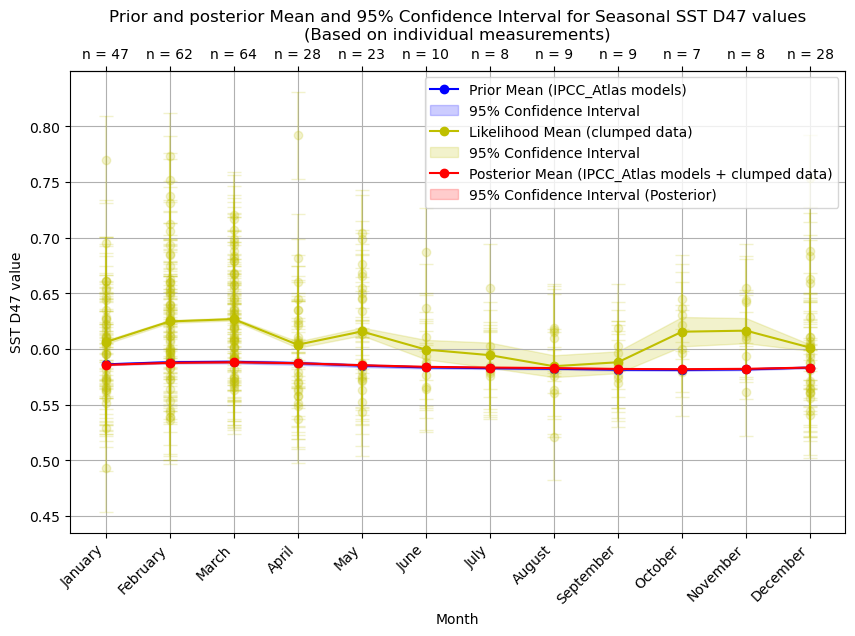

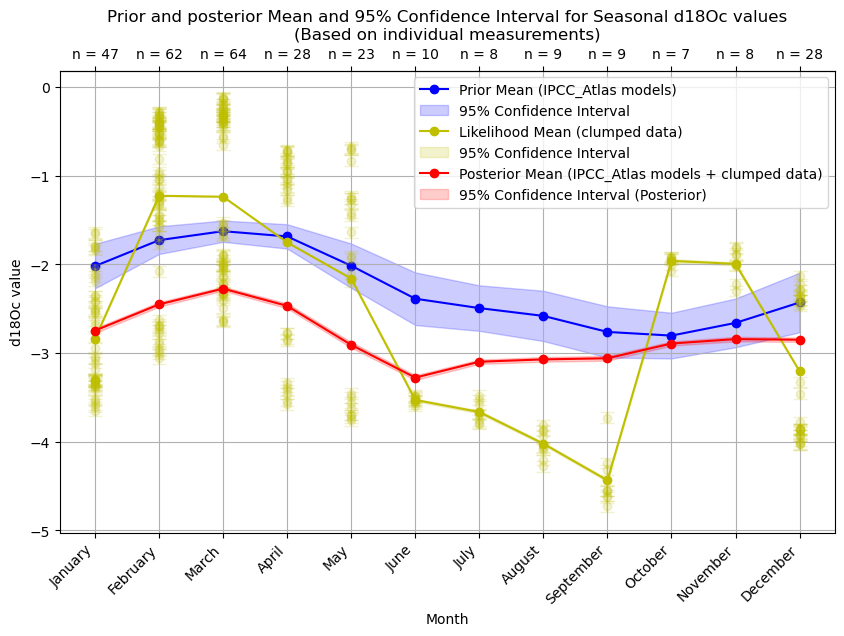

In [128]:
# --- D47 ---

# Plot the updated seasonal posterior for SST_D47
std_post_SST_D47_monthly_aggregated = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated))
std_prior_SST_D47_monthly_original = np.sqrt(np.diag(cov_prior_SST_D47_monthly_original))
var_start_D47_monthly = var_names.index("D47") * num_bins_monthly # Determine the start index for the D47 variable
var_end_D47_monthly = var_start_D47_monthly + num_bins_monthly # Determine the end index for the D47 variable
n_update_monthly_aggregated_D47 = n_update_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly]  # Extract the number of updates for D47

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(months_scale, mu_prior_SST_D47_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
plt.fill_between(
    months_scale,
    mu_prior_SST_D47_monthly_original - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_gridcells_monthly),
    mu_prior_SST_D47_monthly_original + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_gridcells_monthly),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable to parse information from the likelihood statistics
plt.plot(months_scale, mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    months_scale,
    mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly] - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47) * std_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly] / np.sqrt(n_update_monthly_aggregated_D47),
    mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly] + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47) * std_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly] / np.sqrt(n_update_monthly_aggregated_D47),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Caldarescu_data_dict:
    plt.plot(int(measurement["month_score"]) + 1, measurement["D47"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["month_score"]) + 1, measurement["D47"], yerr=measurement["D47_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_aggregated_D47])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(months_scale, mu_post_SST_D47_monthly_aggregated, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
plt.fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_gridcells_monthly)) * std_post_SST_D47_monthly_aggregated / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    mu_post_SST_D47_monthly_aggregated + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_gridcells_monthly)) * std_post_SST_D47_monthly_aggregated / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal SST D47 values\n(Based on individual measurements)')
plt.xlabel('Month')
plt.ylabel('SST D47 value')
plt.legend()
plt.grid(True)
plt.show()

# ---d18Oc---

# Plot the updated seasonal posterior for d18Oc
std_post_d18Oc_monthly_aggregated = np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated))
std_prior_d18Oc_monthly_original = np.sqrt(np.diag(cov_prior_d18Oc_monthly_original))
var_start_d18Oc_monthly = var_names.index("Final_d18Ocarb_VPDB") * num_bins_monthly # Determine the start index for the d18Oc variable
var_end_d18Oc_monthly = var_start_d18Oc_monthly + num_bins_monthly # Determine the end index for the d18Oc variable
n_update_monthly_aggregated_d18Oc = n_update_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly]  # Extract the number of updates for d18Oc

plt.figure(figsize=(10, 6))

# PRIOR
plt.plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
plt.fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_d18Oc_monthly_original / np.sqrt(n_gridcells_monthly),
    mu_prior_d18Oc_monthly_original + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_d18Oc_monthly_original / np.sqrt(n_gridcells_monthly),
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)

# LIKELIHOOD
# Determine the start and end indices for the selected variable
plt.plot(months_scale, mu_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly], label='Likelihood Mean (clumped data)', color='y', marker='o')
plt.fill_between(
    months_scale,
    mu_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_d18Oc) * std_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] / np.sqrt(n_update_monthly_aggregated_d18Oc),
    mu_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_d18Oc) * std_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] / np.sqrt(n_update_monthly_aggregated_d18Oc),
    color='y',
    alpha=0.2,
    label='95% Confidence Interval'
)
for measurement in Caldarescu_data_dict:
    plt.plot(int(measurement["month_score"]) + 1, measurement["Final_d18Ocarb_VPDB"], color="y", marker="o", alpha=0.2)
    plt.errorbar(int(measurement["month_score"]) + 1, measurement["Final_d18Ocarb_VPDB"], yerr=measurement["d18O_SD"], color="y", alpha=0.2, capsize=5)
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_aggregated_d18Oc])
secax.tick_params(axis='x', rotation=0)

# POSTERIOR
plt.plot(months_scale, mu_post_d18Oc_monthly_aggregated, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
plt.fill_between(
    months_scale,
    mu_post_d18Oc_monthly_aggregated - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_d18Oc + n_gridcells_monthly)) * std_post_d18Oc_monthly_aggregated / np.sqrt(n_update_monthly_aggregated_d18Oc + n_gridcells_monthly),
    mu_post_d18Oc_monthly_aggregated + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_d18Oc + n_gridcells_monthly)) * std_post_d18Oc_monthly_aggregated / np.sqrt(n_update_monthly_aggregated_d18Oc + n_gridcells_monthly),
    color='r',
    alpha=0.2,
    label='95% Confidence Interval (Posterior)'
)

plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal d18Oc values\n(Based on individual measurements)')
plt.xlabel('Month')
plt.ylabel('d18Oc value')
plt.legend()
plt.grid(True)
plt.show()

# POSTERIOR - SEASONAL

## Seasonal posterior in temperature and salinity domains with aggregated data
* Assemble data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Aggregate each D47 datapoint into a seasonal bin prior to assembly

### Convert seasonal prior, likelihood and posterior to temperature and salinity and plot

To calculate the covariance matrices for d18Ow based on covariance between d18Oc values for the equations of Grossman and Ku and Lecuyer et al. the following approach is followed:
* Original formula: T = B - A * (d18Oc - d18Ow) (+ 0.27 for Grossman and Ku, but this term is irrelavant for covariance; A and B different per calibration equation)
First solve for d18Ow:
* d18Ow (in VSMOW) = d18Oc - (B - T) / A (+ 0.27)
* Partial derivative 1: d(d18Ow)/d(d18Oc) = 1
* Partial derivative 2: d(d18Ow)/d(T) = 1 / A
* cov(d18Ow) = d(d18Ow)/d(d18Oc) ^ 2 * cov(d18Oc) + d(d18Ow)/d(d18Oc) * d(d18Ow)/d(T) * crosscov(d18Oc, T) * transpose(crosscov(d18Oc, T)) + d(d18Ow)/d(T) ^ 2 * cov(T)

In [129]:
# Function to propagate covariance on d18Ow in case of linear d18Oc-d18Ow-T equation
def propagate_cov_d18Ow_linear(cov_c, cov_T, cov_cT, A):
    """
    Propagate covariance for:
        w = c - (B - T)/A (+ 0.27)
    where A and B are scalars and the term 0.27 is used to convert between SMOW and VSMOW, but only A is relevant for covariance

    Inputs:
        cov_c  : (n,n) covariance matrix of d18Oc
        cov_T  : (n,n) covariance matrix of T
        cov_cT : (n,n) cross-covariance matrix Cov(c,T)
        A      : scalar (slope)

    Returns:
        cov_w : (n,n) covariance matrix of d18Ow
    """

    dwdc = 1.0
    dwdT = 1.0 / A

    cov_w = (
        dwdc**2 * cov_c
        + dwdc * dwdT * (cov_cT + cov_cT.T)
        + dwdT**2 * cov_T
    )

    return cov_w

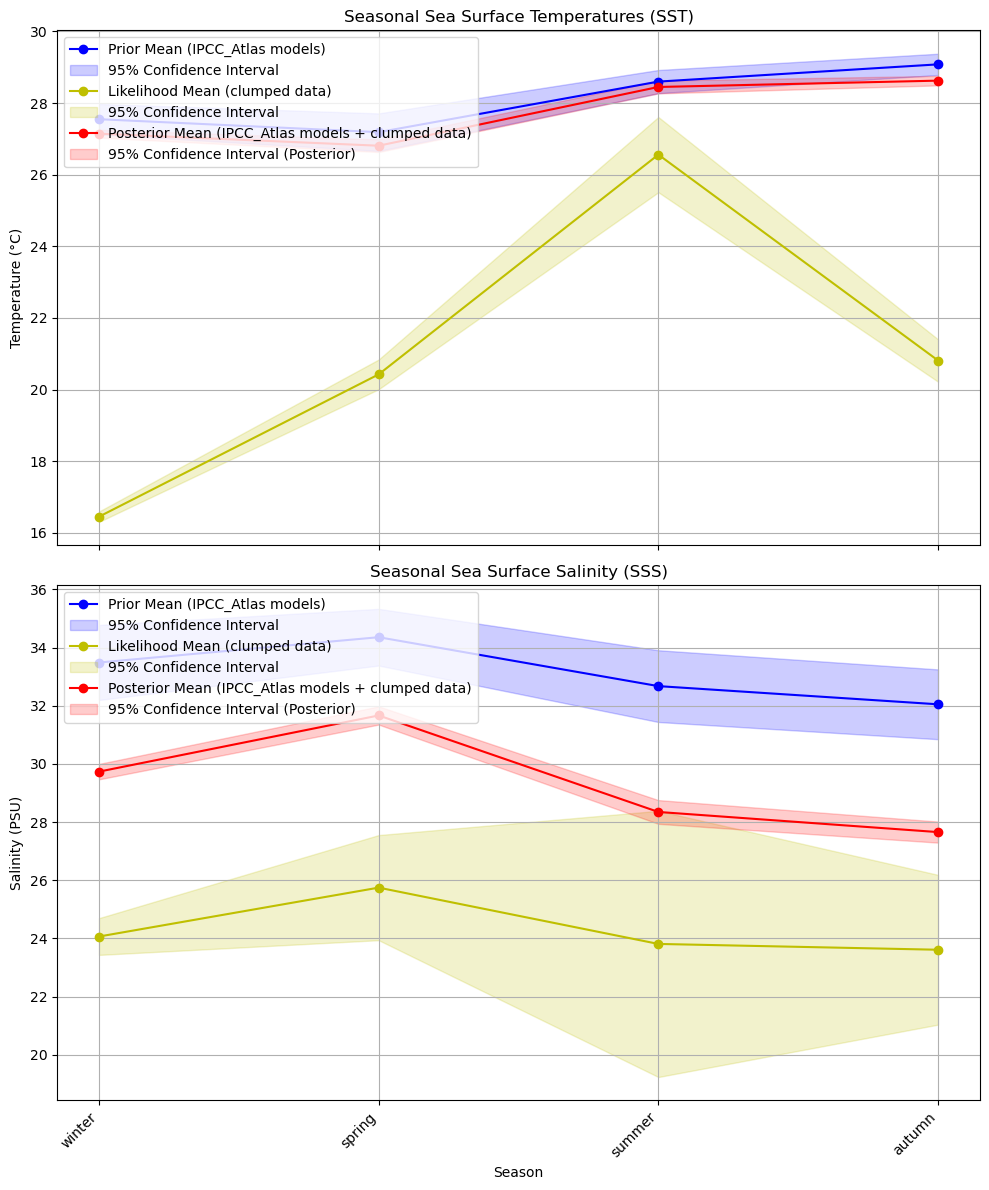

In [130]:
# Convert prior D47 to temp
mu_prior_SST_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_seasonal_original, sD47 = cov_prior_SST_D47_seasonal_original, return_covar = True)[0]
cov_prior_SST_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_seasonal_original, sD47 = cov_prior_SST_D47_seasonal_original, return_covar = True)[1]

# Convert prior d18Oc and temperature to d18Ow
mu_prior_d18Ow_seasonal_T = mu_prior_d18Oc_seasonal_original - (20.6 - mu_prior_SST_D47_seasonal_T) / 4.34 + 0.27
# Calculate d18Oc-SST cross-covariance matrices
cross_cov_prior_d18Oc_SST_seasonal = np.cov(IPCC_Atlas_seasonal[SST_D47_columns_seasonal + d18Oc_columns_seasonal].dropna(), rowvar=False)[len(seasons): 2 * len(seasons), 0 : len(seasons)] # Compute cross covariance matrix between d18Oc and T
# Propagate covariance (use function above for linear equation)
cov_prior_d18Ow_seasonal_T = propagate_cov_d18Ow_linear(cov_prior_d18Oc_seasonal_original, cov_prior_SST_D47_seasonal_T, cross_cov_prior_d18Oc_SST_seasonal, 4.34)

# Convert prior d18Ow to SSS
mu_prior_SSS_d18Ow_seasonal_T = (mu_prior_d18Ow_seasonal_T + 7.89) / 0.23
cov_prior_SSS_d18Ow_seasonal_T = cov_prior_d18Ow_seasonal_T / (0.23 ** 2)

# Convert likelihood D47 to temp
mu_likelihood_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal], sD47 = std_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal], return_covar = True)[0]
cov_likelihood_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal], sD47 = std_likelihood_seasonal_aggregated[var_start_D47_seasonal:var_end_D47_seasonal], return_covar = True)[1]

# Convert likelihood d18Oc and temperature to d18Ow (curently not implemented in data tracking function)
mu_likelihood_d18Ow_seasonal_aggregated_T = mu_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] - (20.6 - mu_likelihood_seasonal_aggregated_T) / 4.34 + 0.27
std_likelihood_d18Ow_seasonal_aggregated_T = np.sqrt(
    np.diag(
        propagate_cov_d18Ow_linear(
            np.diag(std_likelihood_seasonal_aggregated[var_start_d18Oc_seasonal:var_end_d18Oc_seasonal] ** 2), # Covariance matrix of d18Oc is simply a diagonal matrix of variances
            cov_likelihood_seasonal_aggregated_T,
            cross_cov_prior_d18Oc_SST_seasonal,
            4.34
        )
    )
)

# Convert likelihood d18Ow to SSS (currently not implemented in data tracking function)
mu_likelihood_SSS_d18Ow_seasonal_aggregated_T = (mu_likelihood_d18Ow_seasonal_aggregated_T + 7.89) / 0.23
std_likelihood_SSS_d18Ow_seasonal_aggregated_T = std_likelihood_d18Ow_seasonal_aggregated_T / (0.23 ** 2)

# Convert posterior D47 to temp
mu_post_SST_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal_aggregated, sD47 = cov_post_SST_D47_seasonal_aggregated, return_covar = True)[0]
cov_post_SST_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal_aggregated, sD47 = cov_post_SST_D47_seasonal_aggregated, return_covar = True)[1]

# Convert posterior d18Oc and temperature to d18Ow
mu_post_d18Ow_seasonal_aggregated_T = mu_post_d18Oc_seasonal_aggregated - (20.6 - mu_post_SST_D47_seasonal_aggregated_T) / 4.34 + 0.27
cov_post_d18Ow_seasonal_aggregated_T = propagate_cov_d18Ow_linear(
    cov_post_d18Oc_seasonal_aggregated,
    cov_post_SST_D47_seasonal_aggregated_T,
    cross_cov_prior_d18Oc_SST_seasonal,
    4.34
)

# Convert posterior d18Ow to SSS
mu_post_SSS_d18Ow_seasonal_aggregated_T = (mu_post_d18Ow_seasonal_aggregated_T + 7.89) / 0.23
cov_post_SSS_d18Ow_seasonal_aggregated_T = cov_post_d18Ow_seasonal_aggregated_T / (0.23 ** 2)

# Plot in temperature domain
std_prior_SST_D47_seasonal_T = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_T))
std_prior_SSS_d18Ow_seasonal_T = np.sqrt(np.diag(cov_prior_SSS_d18Ow_seasonal_T))
std_likelihood_seasonal_aggregated_T = np.sqrt(np.diag(cov_likelihood_seasonal_aggregated_T))
std_post_SST_D47_seasonal_aggregated_T = np.sqrt(np.diag(cov_post_SST_D47_seasonal_aggregated_T))
std_post_SSS_d18Ow_seasonal_aggregated_T = np.sqrt(np.diag(cov_post_SSS_d18Ow_seasonal_aggregated_T))
# Initiate plot
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# FIRST PANEL: SST Results
# PRIOR
axs[0].plot(seasons_scale, mu_prior_SST_D47_seasonal_T, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
axs[0].fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_gridcells_seasonal),
    mu_prior_SST_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_gridcells_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[0].plot(seasons_scale, mu_likelihood_seasonal_aggregated_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[0].fill_between(seasons_scale,
    mu_likelihood_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47),
    mu_likelihood_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[0].plot(seasons_scale, mu_post_SST_D47_seasonal_aggregated_T, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axs[0].fill_between(seasons_scale,
    mu_post_SST_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    mu_post_SST_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SST panel
axs[0].set_title('Seasonal Sea Surface Temperatures (SST)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='upper left')
axs[0].grid(True)

# SECOND PANEL: SSS Results
# PRIOR
axs[1].plot(seasons_scale, mu_prior_SSS_d18Ow_seasonal_T, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
axs[1].fill_between(seasons_scale,
    mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_gridcells_seasonal),
    mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_gridcells_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[1].plot(seasons_scale, mu_likelihood_SSS_d18Ow_seasonal_aggregated_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[1].fill_between(seasons_scale,
    mu_likelihood_SSS_d18Ow_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_d18Oc) * std_likelihood_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_d18Oc),
    mu_likelihood_SSS_d18Ow_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_d18Oc) * std_likelihood_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_d18Oc),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[1].plot(seasons_scale, mu_post_SSS_d18Ow_seasonal_aggregated_T, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axs[1].fill_between(seasons_scale,
    mu_post_SSS_d18Ow_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_d18Oc + n_gridcells_seasonal)) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_d18Oc + n_gridcells_seasonal),
    mu_post_SSS_d18Ow_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_d18Oc + n_gridcells_seasonal)) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_d18Oc + n_gridcells_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SSS panel
axs[1].set_title('Seasonal Sea Surface Salinity (SSS)')
axs[1].set_xlabel('Season')
axs[1].set_ylabel('Salinity (PSU)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Shared x-axis labels
plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Plot SAT and precipitation prior and posterior

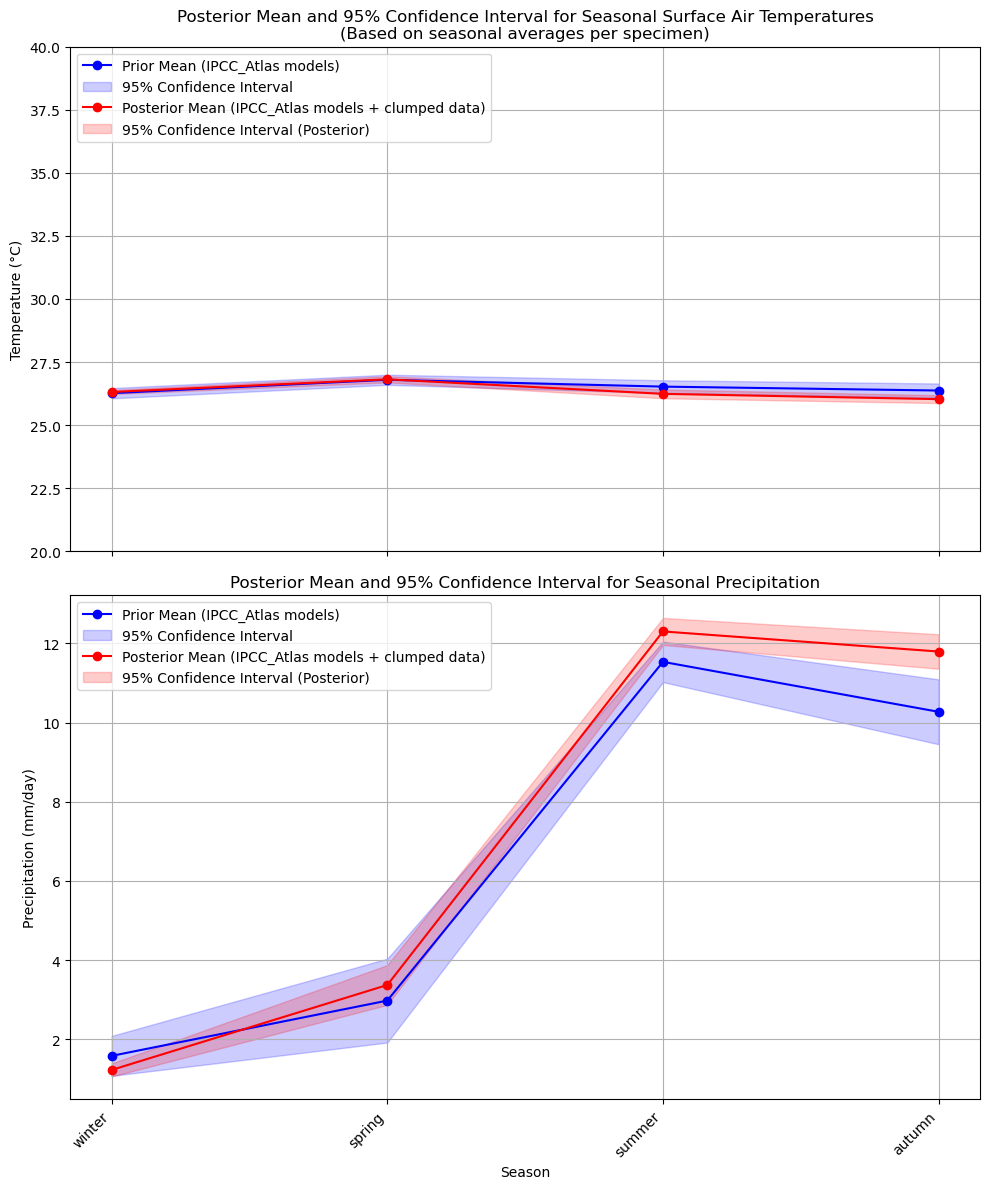

In [131]:
# Convert posterior D47 to temp
mu_post_SAT_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal_aggregated, sD47 = cov_post_SAT_D47_seasonal_aggregated, return_covar = True)[0]
cov_post_SAT_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal_aggregated, sD47 = cov_post_SAT_D47_seasonal_aggregated, return_covar = True)[1]

# Convert posterior SAT-D47 back to temperature
std_post_SAT_D47_seasonal_aggregated_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_seasonal_aggregated_T)))

fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# --- SAT prior and posterior ---
# PRIOR
axs[0].plot(seasons_scale, mu_prior_SAT_seasonal_original, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
axs[0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_gridcells_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[0].plot(seasons_scale, mu_post_SAT_D47_seasonal_aggregated_T, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axs[0].fill_between(
    seasons_scale,
    mu_post_SAT_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    mu_post_SAT_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[0].set_title('Posterior Mean and 95% Confidence Interval for Seasonal Surface Air Temperatures\n(Based on seasonal averages per specimen)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_ylim(20, 40)
axs[0].legend(loc='upper left')
axs[0].grid(True)

# --- Precipitation prior and posterior ---
# PRIOR
axs[1].plot(seasons_scale, mu_prior_precip_seasonal_original, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
axs[1].fill_between(
    seasons_scale,
    mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[1].plot(seasons_scale, mu_post_precip_seasonal_aggregated, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axs[1].fill_between(
    seasons_scale,
    mu_post_precip_seasonal_aggregated - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    mu_post_precip_seasonal_aggregated + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal Precipitation')
axs[1].set_xlabel('Season')
axs[1].set_ylabel('Precipitation (mm/day)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

plt.xticks(seasons_scale, seasons, rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation posterior

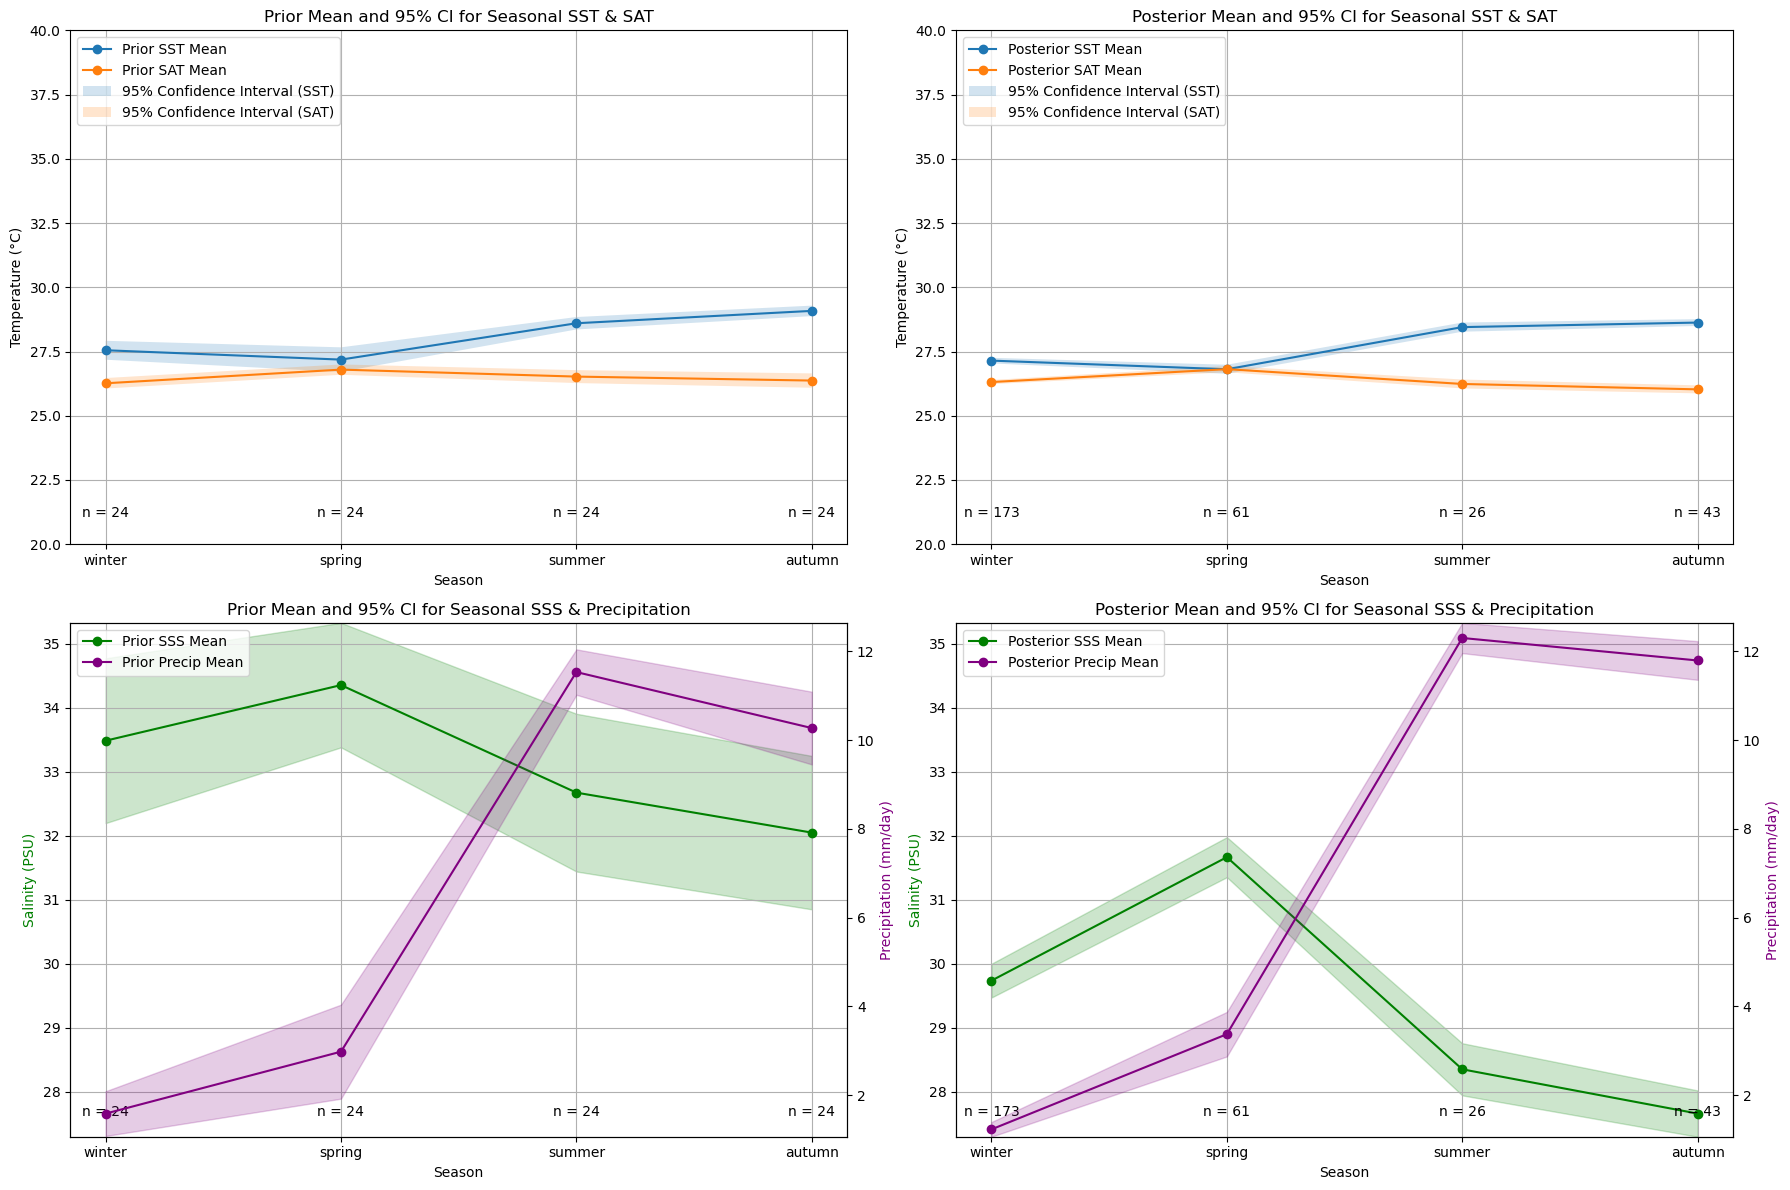

In [132]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o')
axes[0, 0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SST_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_gridcells_seasonal),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 0].set_xticks(seasons_scale)
axes[0, 0].set_xticklabels(seasons)
axes[0, 0].set_title('Prior Mean and 95% CI for Seasonal SST & SAT')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(20, 40)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(seasons_scale, mu_post_SST_D47_seasonal_aggregated_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(seasons_scale, mu_post_SAT_D47_seasonal_aggregated_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SST_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    mu_post_SST_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SAT_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    mu_post_SAT_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 1].set_xticks(seasons_scale)
axes[0, 1].set_xticklabels(seasons)
axes[0, 1].set_title('Posterior Mean and 95% CI for Seasonal SST & SAT')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(20, 40)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_gridcells_seasonal)),
              np.min(mu_post_SSS_d18Ow_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)))
sss_max = max(np.max(mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_gridcells_seasonal)),
              np.max(mu_post_SSS_d18Ow_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)))
precip_min = min(np.min(mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal)),
                 np.min(mu_post_precip_seasonal_aggregated - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)))
precip_max = max(np.max(mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal)),
                 np.max(mu_post_precip_seasonal_aggregated + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal)))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_prior_SSS_d18Ow_seasonal_T, label='Prior SSS Mean', marker='o', color="green")
ax1.fill_between(
    seasons_scale,
    mu_prior_SSS_d18Ow_seasonal_T - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_gridcells_seasonal),
    mu_prior_SSS_d18Ow_seasonal_T + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_SSS_d18Ow_seasonal_T / np.sqrt(n_gridcells_seasonal),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_prior_precip_seasonal_original, label='Prior Precip Mean', marker='o', color="purple")
ax2.fill_between(
    seasons_scale,
    mu_prior_precip_seasonal_original - stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    mu_prior_precip_seasonal_original + stats.t.ppf(1 - 0.025, n_gridcells_seasonal) * std_prior_precip_seasonal / np.sqrt(n_gridcells_seasonal),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Prior Mean and 95% CI for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + lns2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_post_SSS_d18Ow_seasonal_aggregated_T, label='Posterior SSS Mean', marker='o', color="green")
ax1.fill_between(
    seasons_scale,
    mu_post_SSS_d18Ow_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    mu_post_SSS_d18Ow_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * std_post_SSS_d18Ow_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_post_precip_seasonal_aggregated, label='Posterior Precip Mean', marker='o', color="purple")
ax2.fill_between(
    seasons_scale,
    mu_post_precip_seasonal_aggregated - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    mu_post_precip_seasonal_aggregated + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated_D47 + n_gridcells_seasonal) * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated_D47 + n_gridcells_seasonal),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Posterior Mean and 95% CI for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + lns2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# Add "n = x" labels below each x-tick for each subplot to show the number of model values or updates
# Prior SST & SAT
for i, season in enumerate(seasons):
    axes[0, 0].text(
        seasons_scale[i], axes[0, 0].get_ylim()[0] + 1.5, # adjust location as needed
        f"n = {n_gridcells_seasonal[i] if hasattr(n_gridcells_seasonal, '__getitem__') else n_gridcells_seasonal}",
        ha='center', va='top', fontsize=10
    )

# Posterior SST & SAT
for i, season in enumerate(seasons):
    axes[0, 1].text(
        seasons_scale[i], axes[0, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_seasonal_aggregated_D47[i]) if hasattr(n_update_seasonal_aggregated_D47, '__getitem__') else n_update_seasonal_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

# Prior SSS & Precipitation
for i, season in enumerate(seasons):
    axes[1, 0].text(
        seasons_scale[i], axes[1, 0].get_ylim()[0] + 0.5,
        f"n = {n_gridcells_seasonal[i] if hasattr(n_gridcells_seasonal, '__getitem__') else n_gridcells_seasonal}",
        ha='center', va='top', fontsize=10
    )

# Posterior SSS & Precipitation
for i, season in enumerate(seasons):
    axes[1, 1].text(
        seasons_scale[i], axes[1, 1].get_ylim()[0] + 0.5,
        f"n = {int(n_update_seasonal_aggregated_D47[i]) if hasattr(n_update_seasonal_aggregated_D47, '__getitem__') else n_update_seasonal_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation posterior with uncertainties as 2 SD

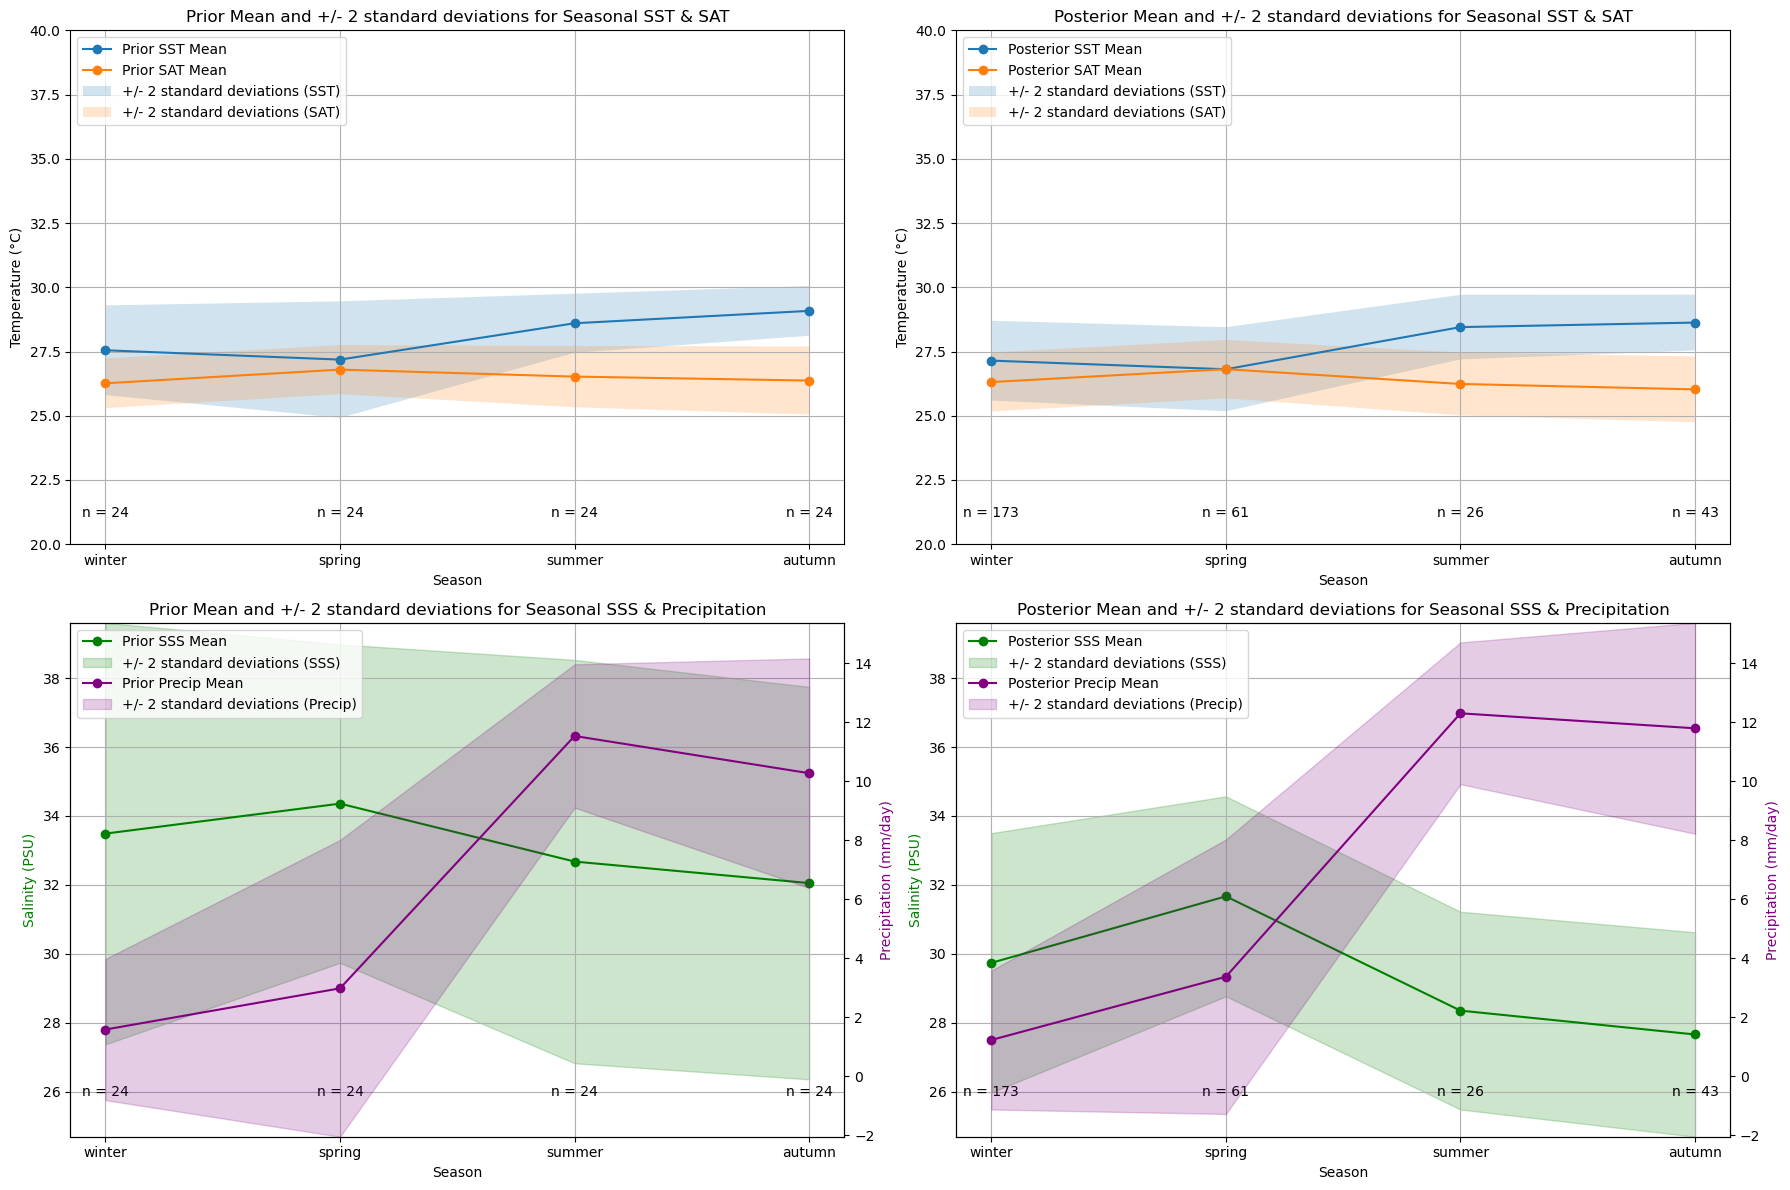

In [133]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o')
axes[0, 0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SST_seasonal - 2 * std_prior_SST_seasonal,
    mu_prior_SST_seasonal + 2 * std_prior_SST_seasonal,
    alpha=0.2, label='+/- 2 standard deviations (SST)'
)
axes[0, 0].fill_between(
    seasons_scale,
    mu_prior_SAT_seasonal - 2 * std_prior_SAT_seasonal,
    mu_prior_SAT_seasonal + 2 * std_prior_SAT_seasonal,
    alpha=0.2, label='+/- 2 standard deviations (SAT)'
)
axes[0, 0].set_xticks(seasons_scale)
axes[0, 0].set_xticklabels(seasons)
axes[0, 0].set_title('Prior Mean and +/- 2 standard deviations for Seasonal SST & SAT')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(20, 40)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(seasons_scale, mu_post_SST_D47_seasonal_aggregated_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(seasons_scale, mu_post_SAT_D47_seasonal_aggregated_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SST_D47_seasonal_aggregated_T - 2 * std_post_SST_D47_seasonal_aggregated_T,
    mu_post_SST_D47_seasonal_aggregated_T + 2 * std_post_SST_D47_seasonal_aggregated_T,
    alpha=0.2, label='+/- 2 standard deviations (SST)'
)
axes[0, 1].fill_between(
    seasons_scale,
    mu_post_SAT_D47_seasonal_aggregated_T - 2 * std_post_SAT_D47_seasonal_aggregated_T,
    mu_post_SAT_D47_seasonal_aggregated_T + 2 * std_post_SAT_D47_seasonal_aggregated_T,
    alpha=0.2, label='+/- 2 standard deviations (SAT)'
)
axes[0, 1].set_xticks(seasons_scale)
axes[0, 1].set_xticklabels(seasons)
axes[0, 1].set_title('Posterior Mean and +/- 2 standard deviations for Seasonal SST & SAT')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(20, 40)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_seasonal_T - 2 * std_prior_SSS_d18Ow_seasonal_T),
              np.min(mu_post_SSS_d18Ow_seasonal_aggregated_T - 2 * std_post_SSS_d18Ow_seasonal_aggregated_T))
sss_max = max(np.max(mu_prior_SSS_d18Ow_seasonal_T + 2 * std_prior_SSS_d18Ow_seasonal_T),
              np.max(mu_post_SSS_d18Ow_seasonal_aggregated_T + 2 * std_post_SSS_d18Ow_seasonal_aggregated_T))
precip_min = min(np.min(mu_prior_precip_seasonal_original - 2 * std_prior_precip_seasonal),
                 np.min(mu_post_precip_seasonal_aggregated - 2 * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated))))
precip_max = max(np.max(mu_prior_precip_seasonal_original + 2 * std_prior_precip_seasonal),
                 np.max(mu_post_precip_seasonal_aggregated + 2 * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated))))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_prior_SSS_d18Ow_seasonal_T, label='Prior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    seasons_scale,
    mu_prior_SSS_d18Ow_seasonal_T - 2 * std_prior_SSS_d18Ow_seasonal_T,
    mu_prior_SSS_d18Ow_seasonal_T + 2 * std_prior_SSS_d18Ow_seasonal_T,
    color="green", alpha=0.2, label='+/- 2 standard deviations (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_prior_precip_seasonal_original, label='Prior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    seasons_scale,
    mu_prior_precip_seasonal_original - 2 * std_prior_precip_seasonal,
    mu_prior_precip_seasonal_original + 2 * std_prior_precip_seasonal,
    color="purple", alpha=0.2, label='+/- 2 standard deviations (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Prior Mean and +/- 2 standard deviations for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(seasons_scale, mu_post_SSS_d18Ow_seasonal_aggregated_T, label='Posterior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    seasons_scale,
    mu_post_SSS_d18Ow_seasonal_aggregated_T - 2 * std_post_SSS_d18Ow_seasonal_aggregated_T,
    mu_post_SSS_d18Ow_seasonal_aggregated_T + 2 * std_post_SSS_d18Ow_seasonal_aggregated_T,
    color="green", alpha=0.2, label='+/- 2 standard deviations (SSS)'
)
lns2 = ax2.plot(seasons_scale, mu_post_precip_seasonal_aggregated, label='Posterior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    seasons_scale,
    mu_post_precip_seasonal_aggregated - 2 * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)),
    mu_post_precip_seasonal_aggregated + 2 * np.sqrt(np.diag(cov_post_precip_seasonal_aggregated)),
    color="purple", alpha=0.2, label='+/- 2 standard deviations (Precip)'
)
ax1.set_xticks(seasons_scale)
ax1.set_xticklabels(seasons)
ax1.set_title('Posterior Mean and +/- 2 standard deviations for Seasonal SSS & Precipitation')
ax1.set_xlabel('Season')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# Add "n = x" labels below each x-tick for each subplot to show the number of model values or updates
# Prior SST & SAT
for i, season in enumerate(seasons):
    axes[0, 0].text(
        seasons_scale[i], axes[0, 0].get_ylim()[0] + 1.5,  # adjust location as needed
        f"n = {n_gridcells_seasonal[i] if hasattr(n_gridcells_seasonal, '__getitem__') else n_gridcells_seasonal}",
        ha='center', va='top', fontsize=10
    )

# Posterior SST & SAT
for i, season in enumerate(seasons):
    axes[0, 1].text(
        seasons_scale[i], axes[0, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_seasonal_aggregated_D47[i]) if hasattr(n_update_seasonal_aggregated_D47, '__getitem__') else n_update_seasonal_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

# Prior SSS & Precipitation
for i, season in enumerate(seasons):
    axes[1, 0].text(
        seasons_scale[i], axes[1, 0].get_ylim()[0] + 1.5,
        f"n = {n_gridcells_seasonal[i] if hasattr(n_gridcells_seasonal, '__getitem__') else n_gridcells_seasonal}",
        ha='center', va='top', fontsize=10
    )

# Posterior SSS & Precipitation
for i, season in enumerate(seasons):
    axes[1, 1].text(
        seasons_scale[i], axes[1, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_seasonal_aggregated_D47[i]) if hasattr(n_update_seasonal_aggregated_D47, '__getitem__') else n_update_seasonal_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

plt.tight_layout()
plt.show()

# POSTERIOR - MONTHLY

## Monthly posterior in temperature and salinity domains with aggregated data
* Data and model outcomes assembled per month
* Ignore sclero-dating uncertainty
* D47 data aggregated in monthly bins prior to assembly

### Convert monthly prior, likelihood and posterior to temperature and salinity and plot

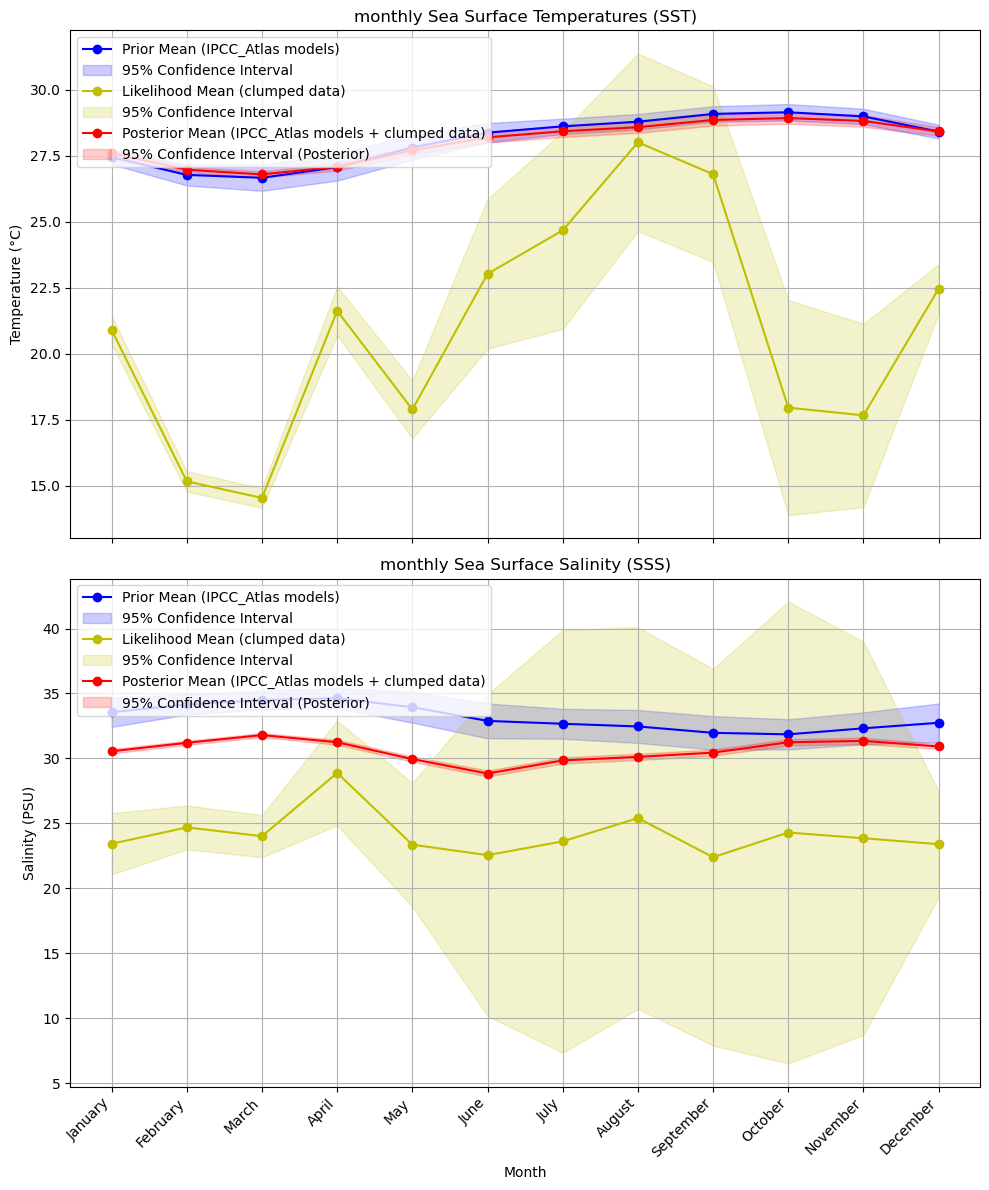

In [134]:
# Convert prior D47 to temp
mu_prior_SST_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_monthly_original, sD47 = cov_prior_SST_D47_monthly_original, return_covar = True)[0]
cov_prior_SST_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_monthly_original, sD47 = cov_prior_SST_D47_monthly_original, return_covar = True)[1]

# Convert prior d18Oc and temperature to d18Ow
mu_prior_d18Ow_monthly_T = mu_prior_d18Oc_monthly_original - (20.6 - mu_prior_SST_D47_monthly_T) / 4.34 + 0.27
# Calculate d18Oc-SST cross-covariance matrices
cross_cov_prior_d18Oc_SST_monthly = np.cov(IPCC_Atlas[SST_D47_columns_monthly + d18Oc_columns_monthly].dropna(), rowvar=False)[len(months): 2 * len(months), 0 : len(months)] # Compute cross covariance matrix between d18Oc and T
# Propagate covariance (use function above for linear equation)
cov_prior_d18Ow_monthly_T = propagate_cov_d18Ow_linear(cov_prior_d18Oc_monthly_original, cov_prior_SST_D47_monthly_T, cross_cov_prior_d18Oc_SST_monthly, 4.34)

# Convert prior d18Ow to SSS
mu_prior_SSS_d18Ow_monthly_T = (mu_prior_d18Ow_monthly_T + 7.89) / 0.23
cov_prior_SSS_d18Ow_monthly_T = cov_prior_d18Ow_monthly_T / (0.23 ** 2)

# Convert likelihood D47 to temp
mu_likelihood_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly], sD47 = std_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly], return_covar = True)[0]
cov_likelihood_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly], sD47 = std_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly], return_covar = True)[1]

# Convert likelihood d18Oc and temperature to d18Ow (curently not implemented in data tracking function)
mu_likelihood_d18Ow_monthly_aggregated_T = mu_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] - (20.6 - mu_likelihood_monthly_aggregated_T) / 4.34 + 0.27
std_likelihood_d18Ow_monthly_aggregated_T = np.sqrt(
    np.diag(
        propagate_cov_d18Ow_linear(
            np.diag(std_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] ** 2), # Covariance matrix of d18Oc is simply a diagonal matrix of variances
            cov_likelihood_monthly_aggregated_T,
            cross_cov_prior_d18Oc_SST_monthly,
            4.34
        )
    )
)

# Convert likelihood d18Ow to SSS (currently not implemented in data tracking function)
mu_likelihood_SSS_d18Ow_monthly_aggregated_T = (mu_likelihood_d18Ow_monthly_aggregated_T + 7.89) / 0.23
std_likelihood_SSS_d18Ow_monthly_aggregated_T = std_likelihood_d18Ow_monthly_aggregated_T / (0.23 ** 2)

# Convert posterior D47 to temp
mu_post_SST_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthly_aggregated, sD47 = cov_post_SST_D47_monthly_aggregated, return_covar = True)[0]
cov_post_SST_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthly_aggregated, sD47 = cov_post_SST_D47_monthly_aggregated, return_covar = True)[1]

# Convert posterior d18Oc and temperature to d18Ow
mu_post_d18Ow_monthly_aggregated_T = mu_post_d18Oc_monthly_aggregated - (20.6 - mu_post_SST_D47_monthly_aggregated_T) / 4.34 + 0.27
cov_post_d18Ow_monthly_aggregated_T = propagate_cov_d18Ow_linear(
    cov_post_d18Oc_monthly_aggregated,
    cov_post_SST_D47_monthly_aggregated_T,
    cross_cov_prior_d18Oc_SST_monthly,
    4.34
)

# Convert posterior d18Ow to SSS
mu_post_SSS_d18Ow_monthly_aggregated_T = (mu_post_d18Ow_monthly_aggregated_T + 7.89) / 0.23
cov_post_SSS_d18Ow_monthly_aggregated_T = cov_post_d18Ow_monthly_aggregated_T / (0.23 ** 2)

# Plot in temperature domain
std_prior_SST_D47_monthly_T = np.sqrt(np.diag(cov_prior_SST_D47_monthly_T))
std_prior_SSS_d18Ow_monthly_T = np.sqrt(np.diag(cov_prior_SSS_d18Ow_monthly_T))
std_likelihood_monthly_aggregated_T = np.sqrt(np.diag(cov_likelihood_monthly_aggregated_T))
std_post_SST_D47_monthly_aggregated_T = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_T))
std_post_SSS_d18Ow_monthly_aggregated_T = np.sqrt(np.diag(cov_post_SSS_d18Ow_monthly_aggregated_T))

# Initiate plot
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# FIRST PANEL: SST Results
# PRIOR
axs[0].plot(months_scale, mu_prior_SST_D47_monthly_T, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
axs[0].fill_between(months_scale,
    mu_prior_SST_D47_monthly_T - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_gridcells_monthly),
    mu_prior_SST_D47_monthly_T + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_gridcells_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[0].plot(months_scale, mu_likelihood_monthly_aggregated_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[0].fill_between(months_scale,
    mu_likelihood_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47) * std_likelihood_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47),
    mu_likelihood_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47) * std_likelihood_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[0].plot(months_scale, mu_post_SST_D47_monthly_aggregated_T, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axs[0].fill_between(months_scale,
    mu_post_SST_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_gridcells_monthly)) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    mu_post_SST_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_gridcells_monthly)) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SST panel
axs[0].set_title('monthly Sea Surface Temperatures (SST)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='upper left')
axs[0].grid(True)

# SECOND PANEL: SSS Results
# PRIOR
axs[1].plot(months_scale, mu_prior_SSS_d18Ow_monthly_T, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
axs[1].fill_between(months_scale,
    mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_gridcells_monthly),
    mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_gridcells_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval')

# LIKELIHOOD
axs[1].plot(months_scale, mu_likelihood_SSS_d18Ow_monthly_aggregated_T, label='Likelihood Mean (clumped data)', color='y', marker='o')
axs[1].fill_between(months_scale,
    mu_likelihood_SSS_d18Ow_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_d18Oc) * std_likelihood_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_d18Oc),
    mu_likelihood_SSS_d18Ow_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_d18Oc) * std_likelihood_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_d18Oc),
    color='y', alpha=0.2, label='95% Confidence Interval')

# POSTERIOR
axs[1].plot(months_scale, mu_post_SSS_d18Ow_monthly_aggregated_T, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axs[1].fill_between(months_scale,
    mu_post_SSS_d18Ow_monthly_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_d18Oc + n_gridcells_monthly)) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_d18Oc + n_gridcells_monthly),
    mu_post_SSS_d18Ow_monthly_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_d18Oc + n_gridcells_monthly)) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_d18Oc + n_gridcells_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)')

# Layout for SSS panel
axs[1].set_title('monthly Sea Surface Salinity (SSS)')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Salinity (PSU)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Shared x-axis labels
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Plot SAT and precipitation prior and posterior

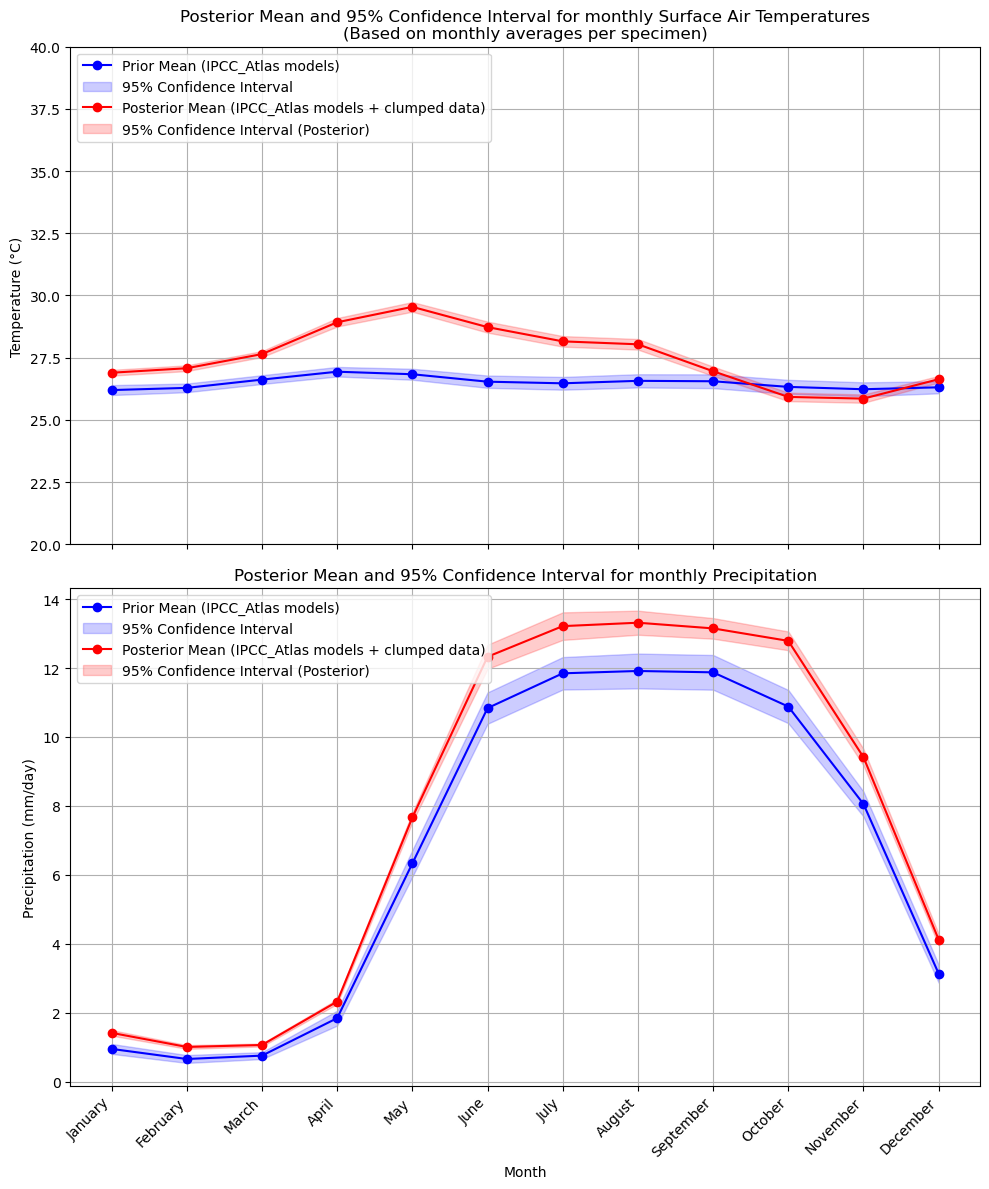

In [135]:
# Convert posterior D47 to temp
mu_post_SAT_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthly_aggregated, sD47 = cov_post_SAT_D47_monthly_aggregated, return_covar = True)[0]
cov_post_SAT_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthly_aggregated, sD47 = cov_post_SAT_D47_monthly_aggregated, return_covar = True)[1]

# Convert posterior SAT-D47 back to temperature
std_post_SAT_D47_monthly_aggregated_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_monthly_aggregated_T)))

fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# --- SAT prior and posterior ---
# PRIOR
axs[0].plot(months_scale, mu_prior_SAT_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
axs[0].fill_between(
    months_scale,
    mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_monthly / np.sqrt(n_gridcells_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[0].plot(months_scale, mu_post_SAT_D47_monthly_aggregated_T, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axs[0].fill_between(
    months_scale,
    mu_post_SAT_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_gridcells_monthly)) * std_post_SAT_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    mu_post_SAT_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_gridcells_monthly)) * std_post_SAT_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[0].set_title('Posterior Mean and 95% Confidence Interval for monthly Surface Air Temperatures\n(Based on monthly averages per specimen)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_ylim(20, 40)
axs[0].legend(loc='upper left')
axs[0].grid(True)

# --- Precipitation prior and posterior ---
# PRIOR
axs[1].plot(months_scale, mu_prior_precip_monthly_original, label='Prior Mean (IPCC_Atlas models)', color='b', marker='o')
axs[1].fill_between(
    months_scale,
    mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
    color='b', alpha=0.2, label='95% Confidence Interval'
)

# POSTERIOR
axs[1].plot(months_scale, mu_post_precip_monthly_aggregated, label='Posterior Mean (IPCC_Atlas models + clumped data)', color='r', marker='o')
axs[1].fill_between(
    months_scale,
    mu_post_precip_monthly_aggregated - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_gridcells_monthly)) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    mu_post_precip_monthly_aggregated + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated_D47 + n_gridcells_monthly)) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    color='r', alpha=0.2, label='95% Confidence Interval (Posterior)'
)

axs[1].set_title('Posterior Mean and 95% Confidence Interval for monthly Precipitation')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Precipitation (mm/day)')
axs[1].legend(loc='upper left')
axs[1].grid(True)

plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation posterior

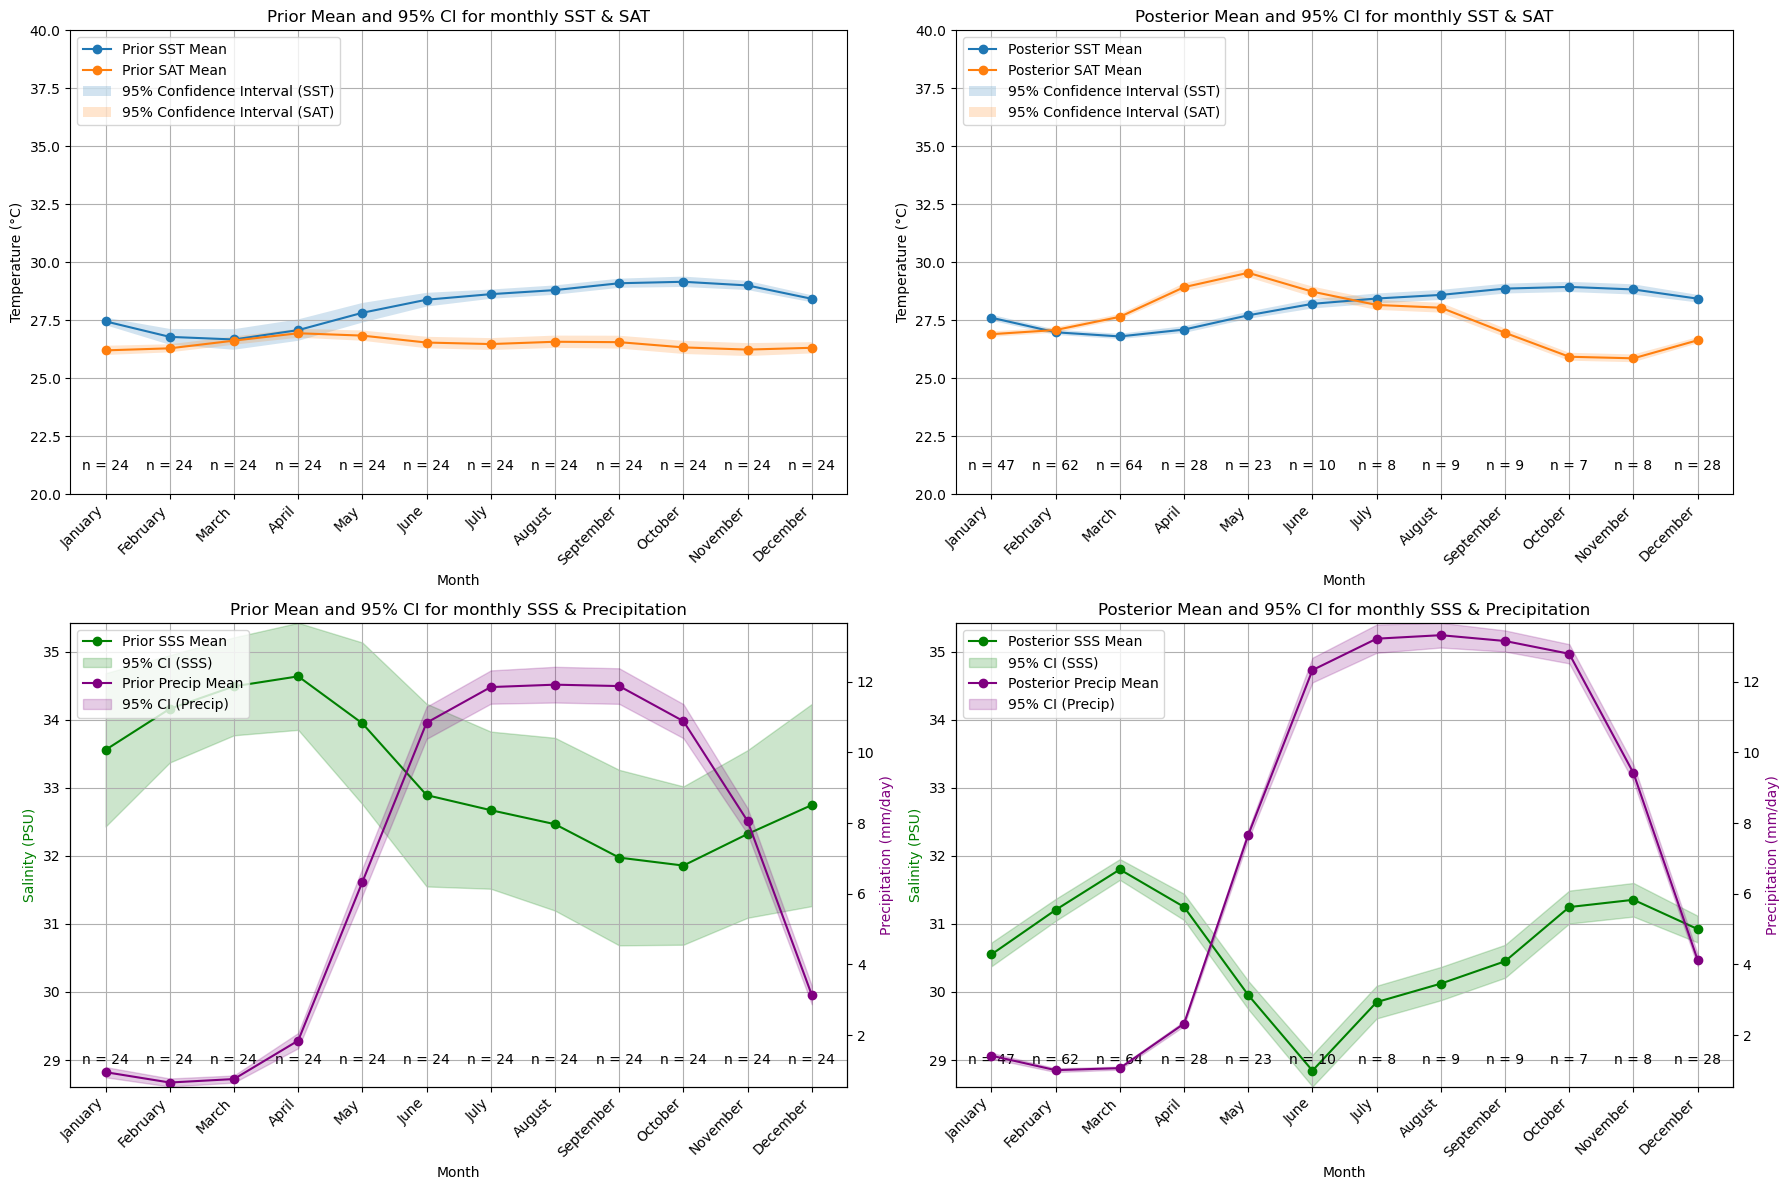

In [136]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o')
axes[0, 0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SST_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SAT_monthly / np.sqrt(n_gridcells_monthly),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Prior Mean and 95% CI for monthly SST & SAT')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(20, 40)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(months_scale, mu_post_SAT_D47_monthly_aggregated_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    mu_post_SST_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    alpha=0.2, label='95% Confidence Interval (SST)'
)
axes[0, 1].fill_between(
    months_scale,
    mu_post_SAT_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * std_post_SAT_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    mu_post_SAT_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * std_post_SAT_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    alpha=0.2, label='95% Confidence Interval (SAT)'
)
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Posterior Mean and 95% CI for monthly SST & SAT')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(20, 40)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_gridcells_monthly)),
              np.min(mu_post_SSS_d18Ow_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly)))
sss_max = max(np.max(mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_gridcells_monthly)),
              np.max(mu_post_SSS_d18Ow_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly)))
precip_min = min(np.min(mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly)),
                 np.min(mu_post_precip_monthly_aggregated - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly)))
precip_max = max(np.max(mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly)),
                 np.max(mu_post_precip_monthly_aggregated + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly)))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_prior_SSS_d18Ow_monthly_T, label='Prior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    months_scale,
    mu_prior_SSS_d18Ow_monthly_T - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_gridcells_monthly),
    mu_prior_SSS_d18Ow_monthly_T + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_SSS_d18Ow_monthly_T / np.sqrt(n_gridcells_monthly),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(months_scale, mu_prior_precip_monthly_original, label='Prior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly_original - stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
    mu_prior_precip_monthly_original + stats.t.ppf(1 - 0.025, n_gridcells_monthly) * std_prior_precip_monthly / np.sqrt(n_gridcells_monthly),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Prior Mean and 95% CI for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_post_SSS_d18Ow_monthly_aggregated_T, label='Posterior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    months_scale,
    mu_post_SSS_d18Ow_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    mu_post_SSS_d18Ow_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * std_post_SSS_d18Ow_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    color="green", alpha=0.2, label='95% CI (SSS)'
)
lns2 = ax2.plot(months_scale, mu_post_precip_monthly_aggregated, label='Posterior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    months_scale,
    mu_post_precip_monthly_aggregated - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    mu_post_precip_monthly_aggregated + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated_D47 + n_gridcells_monthly) * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)) / np.sqrt(n_update_monthly_aggregated_D47 + n_gridcells_monthly),
    color="purple", alpha=0.2, label='95% CI (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Posterior Mean and 95% CI for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# Add "n = x" labels below each x-tick for each subplot to show the number of model values or updates
# Prior SST & SAT
for i, month in enumerate(month_names):
    axes[0, 0].text(
        months_scale[i], axes[0, 0].get_ylim()[0] + 1.5,  # adjust location as needed
        f"n = {n_gridcells_monthly[i] if hasattr(n_gridcells_monthly, '__getitem__') else n_gridcells_monthly}",
        ha='center', va='top', fontsize=10
    )

# Posterior SST & SAT
for i, month in enumerate(month_names):
    axes[0, 1].text(
        months_scale[i], axes[0, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_monthly_aggregated_D47[i]) if hasattr(n_update_monthly_aggregated_D47, '__getitem__') else n_update_monthly_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

# Prior SSS & Precipitation
for i, month in enumerate(month_names):
    axes[1, 0].text(
        months_scale[i], axes[1, 0].get_ylim()[0] + 0.5,
        f"n = {n_gridcells_monthly[i] if hasattr(n_gridcells_monthly, '__getitem__') else n_gridcells_monthly}",
        ha='center', va='top', fontsize=10
    )

# Posterior SSS & Precipitation
for i, month in enumerate(month_names):
    axes[1, 1].text(
        months_scale[i], axes[1, 1].get_ylim()[0] + 0.5,
        f"n = {int(n_update_monthly_aggregated_D47[i]) if hasattr(n_update_monthly_aggregated_D47, '__getitem__') else n_update_monthly_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

plt.tight_layout()
plt.show()

### Plot SAT, SST, SSS and precipitation posterior with SDs instead of 95% confidence levels

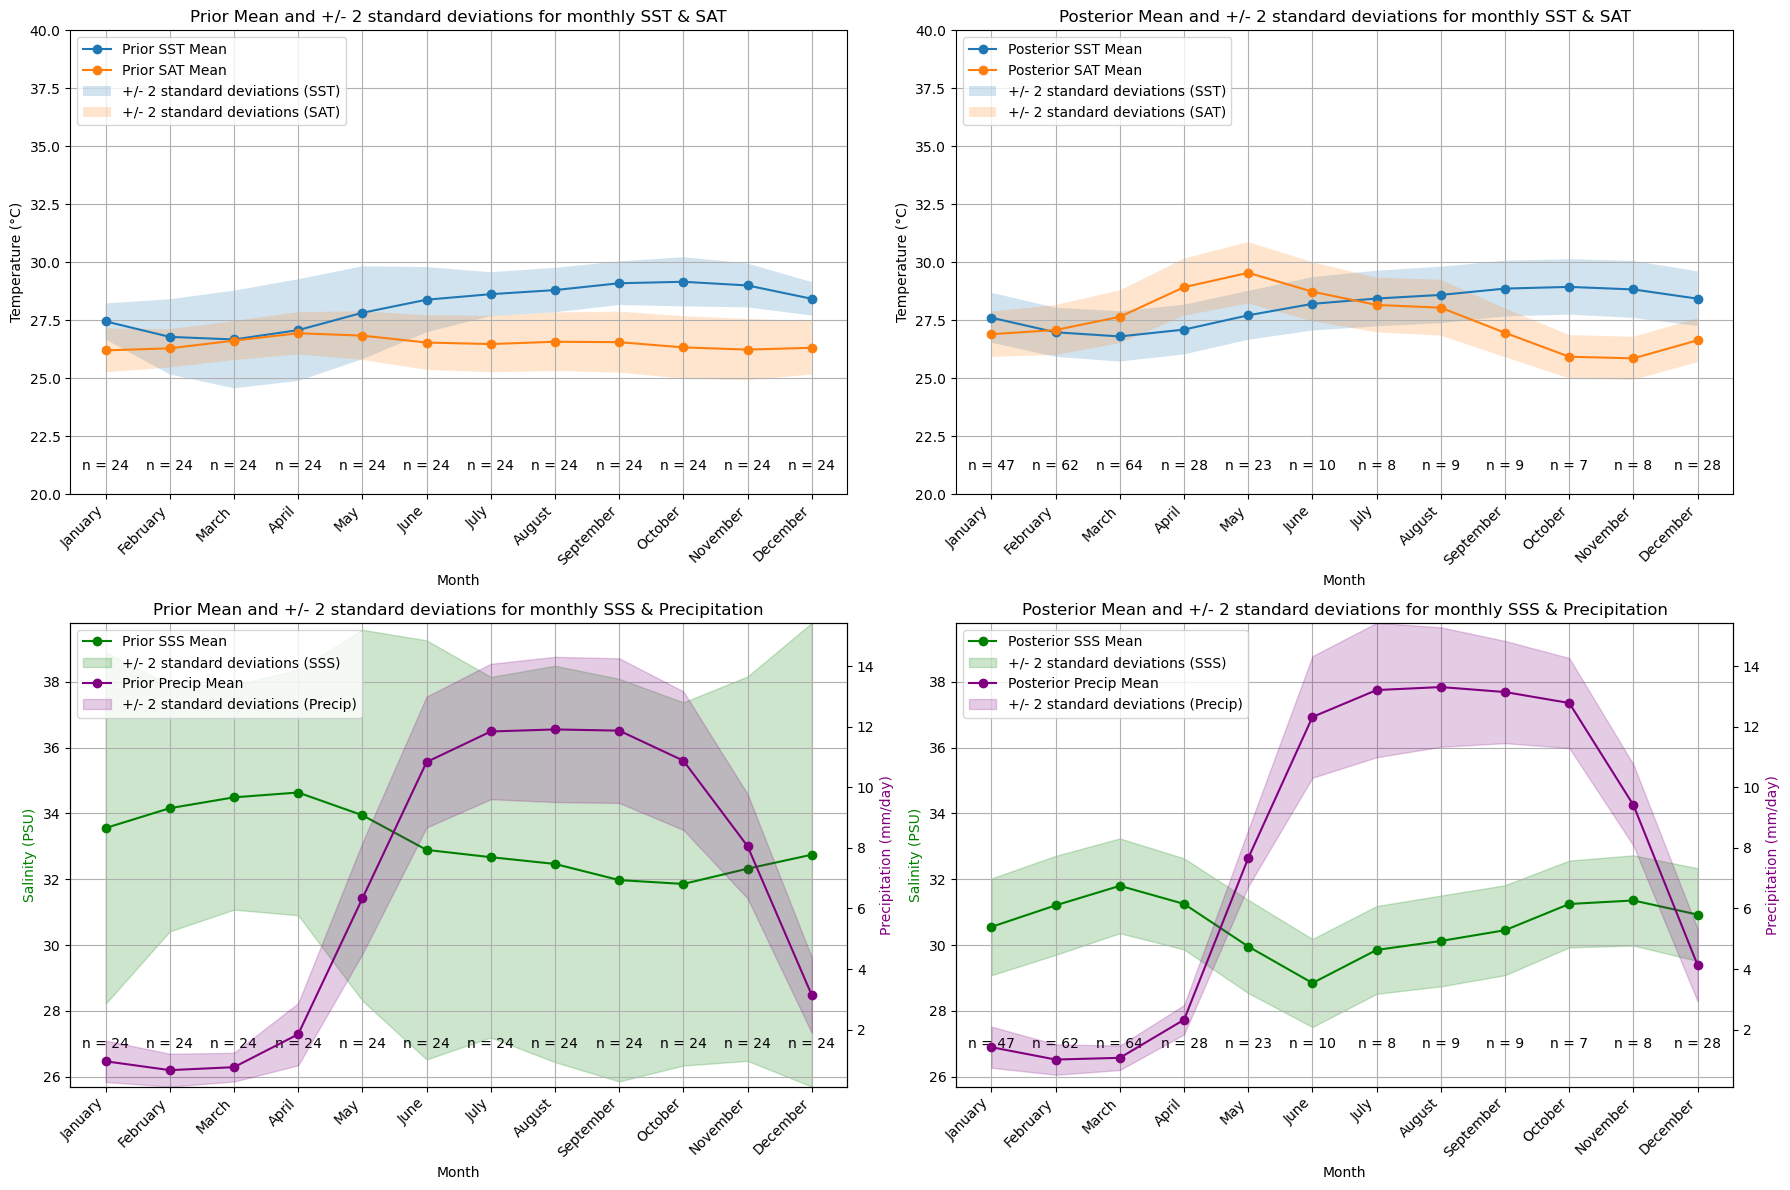

In [137]:
# Create a figure with two rows and two columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- SST & SAT Prior and Posterior ---
# Prior SST & SAT
axes[0, 0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o')
axes[0, 0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SST_monthly - 2 * std_prior_SST_monthly,
    mu_prior_SST_monthly + 2 * std_prior_SST_monthly,
    alpha=0.2, label='+/- 2 standard deviations (SST)'
)
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - 2 * std_prior_SAT_monthly,
    mu_prior_SAT_monthly + 2 * std_prior_SAT_monthly,
    alpha=0.2, label='+/- 2 standard deviations (SAT)'
)
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_title('Prior Mean and +/- 2 standard deviations for monthly SST & SAT')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_ylim(20, 40)
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Posterior SST & SAT
axes[0, 1].plot(months_scale, mu_post_SST_D47_monthly_aggregated_T, label='Posterior SST Mean', marker='o')
axes[0, 1].plot(months_scale, mu_post_SAT_D47_monthly_aggregated_T, label='Posterior SAT Mean', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated_T - 2 * std_post_SST_D47_monthly_aggregated_T,
    mu_post_SST_D47_monthly_aggregated_T + 2 * std_post_SST_D47_monthly_aggregated_T,
    alpha=0.2, label='+/- 2 standard deviations (SST)'
)
axes[0, 1].fill_between(
    months_scale,
    mu_post_SAT_D47_monthly_aggregated_T - 2 * std_post_SAT_D47_monthly_aggregated_T,
    mu_post_SAT_D47_monthly_aggregated_T + 2 * std_post_SAT_D47_monthly_aggregated_T,
    alpha=0.2, label='+/- 2 standard deviations (SAT)'
)
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_title('Posterior Mean and +/- 2 standard deviations for monthly SST & SAT')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Temperature (°C)')
axes[0, 1].set_ylim(20, 40)
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True)

# --- SSS & Precipitation Prior and Posterior (Shared Plot, Twin Axes) ---

# Get y-limits for SSS and precipitation (prior and posterior) to keep them consistent
sss_min = min(np.min(mu_prior_SSS_d18Ow_monthly_T - 2 * std_prior_SSS_d18Ow_monthly_T),
              np.min(mu_post_SSS_d18Ow_monthly_aggregated_T - 2 * std_post_SSS_d18Ow_monthly_aggregated_T))
sss_max = max(np.max(mu_prior_SSS_d18Ow_monthly_T + 2 * std_prior_SSS_d18Ow_monthly_T),
              np.max(mu_post_SSS_d18Ow_monthly_aggregated_T + 2 * std_post_SSS_d18Ow_monthly_aggregated_T))
precip_min = min(np.min(mu_prior_precip_monthly_original - 2 * std_prior_precip_monthly),
                 np.min(mu_post_precip_monthly_aggregated - 2 * np.sqrt(np.diag(cov_post_precip_monthly_aggregated))))
precip_max = max(np.max(mu_prior_precip_monthly_original + 2 * std_prior_precip_monthly),
                 np.max(mu_post_precip_monthly_aggregated + 2 * np.sqrt(np.diag(cov_post_precip_monthly_aggregated))))

# --- Prior SSS & Precipitation ---
ax1 = axes[1, 0]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_prior_SSS_d18Ow_monthly_T, label='Prior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    months_scale,
    mu_prior_SSS_d18Ow_monthly_T - 2 * std_prior_SSS_d18Ow_monthly_T,
    mu_prior_SSS_d18Ow_monthly_T + 2 * std_prior_SSS_d18Ow_monthly_T,
    color="green", alpha=0.2, label='+/- 2 standard deviations (SSS)'
)
lns2 = ax2.plot(months_scale, mu_prior_precip_monthly_original, label='Prior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly_original - 2 * std_prior_precip_monthly,
    mu_prior_precip_monthly_original + 2 * std_prior_precip_monthly,
    color="purple", alpha=0.2, label='+/- 2 standard deviations (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Prior Mean and +/- 2 standard deviations for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# --- Posterior SSS & Precipitation ---
ax1 = axes[1, 1]
ax2 = ax1.twinx()
lns1 = ax1.plot(months_scale, mu_post_SSS_d18Ow_monthly_aggregated_T, label='Posterior SSS Mean', marker='o', color="green")
fill1 = ax1.fill_between(
    months_scale,
    mu_post_SSS_d18Ow_monthly_aggregated_T - 2 * std_post_SSS_d18Ow_monthly_aggregated_T,
    mu_post_SSS_d18Ow_monthly_aggregated_T + 2 * std_post_SSS_d18Ow_monthly_aggregated_T,
    color="green", alpha=0.2, label='+/- 2 standard deviations (SSS)'
)
lns2 = ax2.plot(months_scale, mu_post_precip_monthly_aggregated, label='Posterior Precip Mean', marker='o', color="purple")
fill2 = ax2.fill_between(
    months_scale,
    mu_post_precip_monthly_aggregated - 2 * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)),
    mu_post_precip_monthly_aggregated + 2 * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)),
    color="purple", alpha=0.2, label='+/- 2 standard deviations (Precip)'
)
ax1.set_xticks(months_scale)
ax1.set_xticklabels(month_names, rotation=45, ha="right")
ax1.set_title('Posterior Mean and +/- 2 standard deviations for monthly SSS & Precipitation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Salinity (PSU)', color="green")
ax2.set_ylabel('Precipitation (mm/day)', color="purple")
ax1.set_ylim(sss_min, sss_max)
ax2.set_ylim(precip_min, precip_max)
lns = lns1 + [fill1] + lns2 + [fill2]
labels = [l.get_label() for l in lns1] + [fill1.get_label()] + [l.get_label() for l in lns2] + [fill2.get_label()]
ax1.legend(lns, labels, loc='upper left')
ax1.grid(True)

# Add "n = x" labels below each x-tick for each subplot to show the number of model values or updates
# Prior SST & SAT
for i, month in enumerate(month_names):
    axes[0, 0].text(
        months_scale[i], axes[0, 0].get_ylim()[0] + 1.5,  # adjust location as needed
        f"n = {n_gridcells_monthly[i] if hasattr(n_gridcells_monthly, '__getitem__') else n_gridcells_monthly}",
        ha='center', va='top', fontsize=10
    )

# Posterior SST & SAT
for i, month in enumerate(month_names):
    axes[0, 1].text(
        months_scale[i], axes[0, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_monthly_aggregated_D47[i]) if hasattr(n_update_monthly_aggregated_D47, '__getitem__') else n_update_monthly_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

# Prior SSS & Precipitation
for i, month in enumerate(month_names):
    axes[1, 0].text(
        months_scale[i], axes[1, 0].get_ylim()[0] + 1.5,
        f"n = {n_gridcells_monthly[i] if hasattr(n_gridcells_monthly, '__getitem__') else n_gridcells_monthly}",
        ha='center', va='top', fontsize=10
    )

# Posterior SSS & Precipitation
for i, month in enumerate(month_names):
    axes[1, 1].text(
        months_scale[i], axes[1, 1].get_ylim()[0] + 1.5,
        f"n = {int(n_update_monthly_aggregated_D47[i]) if hasattr(n_update_monthly_aggregated_D47, '__getitem__') else n_update_monthly_aggregated_D47}",
        ha='center', va='top', fontsize=10
    )

plt.tight_layout()
plt.show()

# COMPARISON WITH MEASUREMENT DATA

## Load measurement data on SST, SAT, SSS and precipitation

### SST measurement data

In [138]:
sst_measurement_df = pd.read_csv("Modern case/measurement data/isla_senoritasst3_5_summary.csv")
sst_measurement_df.head()

# Calculate mean and std for each month across all years (skip 'Year' column)
mu_measurement_SST_monthly = sst_measurement_df.loc[:, sst_measurement_df.columns != 'Year'].mean(axis=0, skipna=True).values
std_measurement_SST_monthly = sst_measurement_df.loc[:, sst_measurement_df.columns != 'Year'].std(axis=0, skipna=True).values
print(mu_measurement_SST_monthly)
print(std_measurement_SST_monthly)

[26.05397715 22.93767813 22.17705242 25.16571014 27.72303465 28.34105633
 28.21574736 28.1912413  28.23161188 27.94042177 27.66587677 27.19749893]
[0.85420343 1.0662528  2.00874825 1.49485497 0.61468902 0.33940817
 0.30035706 0.29329485 0.28079002 0.33481732 0.46196816 0.73687447]


### SSS measurement data

### Load SSS ESA satellite data

In [139]:
# Load ESA SSS data as prior and show data structure
ESA_SSS = pd.read_csv('Modern case/SSS_Panama_all.csv')  # Load the data into Python and in the Jupyter environment.
# Convert 'timeseries' column to datetime
ESA_SSS['date'] = pd.to_datetime(ESA_SSS['date'], format='%Y%m%d')
# Rename longitude and latitude columns to 'lon' and 'lat'
ESA_SSS = ESA_SSS.rename(columns={'longitude': 'lon', 'latitude': 'lat'})

# Extract month as two-letter code
month_abbr = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']
ESA_SSS['month'] = ESA_SSS['date'].dt.month.apply(lambda x: month_abbr[x-1])

# Group by lat, lon, and month, then calculate the mean salinity for each group
ESA_SSS = ESA_SSS.groupby(['lat', 'lon', 'month'], as_index=False)['salinity'].mean()

# Pivot to make one column per month, keeping all data
ESA_SSS = ESA_SSS.pivot(index=['lat', 'lon'], columns='month', values='salinity').reset_index()

ESA_SSS.head()

month  lat   lon         ag         ar         dc         fb         ja  \
0      7.0 -81.5  31.136181  33.602102  29.170102  32.022884  30.418702   
1      7.0 -80.0  30.547831  33.757785  29.370818  33.184081  31.357592   
2      7.0 -79.5  30.542582  33.867599  29.344715  33.139511  31.427747   
3      7.0 -79.0  30.390912  33.637158  29.144642  32.730496  31.008538   
4      7.0 -78.5  30.493174  33.578397  29.022538  32.151029  30.534165   

month         jl         jn         mr         my         nv         ot  \
0      31.581640  32.324151  33.077173  33.040741  29.530418  30.622286   
1      30.910315  31.892236  33.637193  33.068963  29.336099  29.891578   
2      31.004266  31.869194  33.656158  33.013782  29.361235  29.827726   
3      31.002376  31.710107  33.398851  32.775925  29.262633  29.721688   
4      31.075004  31.585485  33.202158  32.854144  29.120639  29.612904   

month         sp  
0      30.665430  
1      29.889138  
2      30.019896  
3      29.765914  
4      29.680376

### Extract monthly and seasonal measurement data

In [140]:
# Create list of month names
months = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

mu_measurement_SSS_monthly = np.array(ESA_SSS[[f"{month}" for month in months]].mean(axis=0, skipna=True))
cov_measurement_SSS_monthly = np.cov(ESA_SSS[[f"{month}" for month in months]].dropna(), rowvar=False)
std_measurement_SSS_monthly = np.sqrt(np.diag(cov_measurement_SSS_monthly))

# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

mu_measurement_SSS_seasonal = np.array([ESA_SSS[seasons[season]].mean(axis=1, skipna=True).mean() for season in seasons])
cov_measurement_SSS_seasonal = np.cov([ESA_SSS[seasons[season]].mean(axis=1, skipna=True) for season in seasons], rowvar=True)
std_measurement_SSS_seasonal = np.sqrt(np.diag(cov_measurement_SSS_seasonal))

### SAT measurement data

In [141]:
sat_measurement_df = pd.read_csv("Modern case/measurement data/culebra_SAT_summary.csv")
sat_measurement_df.head()

# Calculate mean and std for each month across all years (skip 'Year' column)
mu_measurement_SAT_monthly = sat_measurement_df.loc[:, sat_measurement_df.columns != 'Year'].mean(axis=0, skipna=True).values
std_measurement_SAT_monthly = sat_measurement_df.loc[:, sat_measurement_df.columns != 'Year'].std(axis=0, skipna=True).values
print(mu_measurement_SAT_monthly)
print(std_measurement_SAT_monthly)

[27.21333333 27.09333333 27.16       27.4        27.65333333 27.44666667
 27.30666667 27.24666667 27.22666667 27.03333333 26.64666667 27.09333333]
[0.54754865 0.46053799 0.52345009 0.4840307  0.35429339 0.44859569
 0.47429145 0.34819261 0.36735865 0.41518785 0.55660536 0.81544612]


### Precipitation measurement data

In [142]:
precip_measurement_df = pd.read_csv("Modern case/measurement data/culebra_precip_summary.csv")
# Convert from mm/month to mm/day by dividing by the number of days per month
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
for i, col in enumerate(month_abbr):
    precip_measurement_df[col] = precip_measurement_df[col] / days_per_month[i]
precip_measurement_df.head()

# Calculate mean and std for each month across all years (skip 'Year' column)
mu_measurement_precip_monthly = precip_measurement_df.loc[:, precip_measurement_df.columns != 'Year'].mean(axis=0, skipna=True).values
std_measurement_precip_monthly = precip_measurement_df.loc[:, precip_measurement_df.columns != 'Year'].std(axis=0, skipna=True).values
print(mu_measurement_precip_monthly)
print(std_measurement_precip_monthly)

[0.83193548 0.24839286 0.67225806 1.649      5.48822581 6.66116667
 5.12903226 5.50230415 6.34936508 6.50076805 7.35904762 3.10875576]
[1.10390764 0.40655457 0.63890035 1.18891228 2.18837908 2.38718687
 2.5753094  2.89484492 2.61863124 1.68515274 2.42597887 1.91788101]


## Plot together with seasonal and monthly posteriors (aggregated)

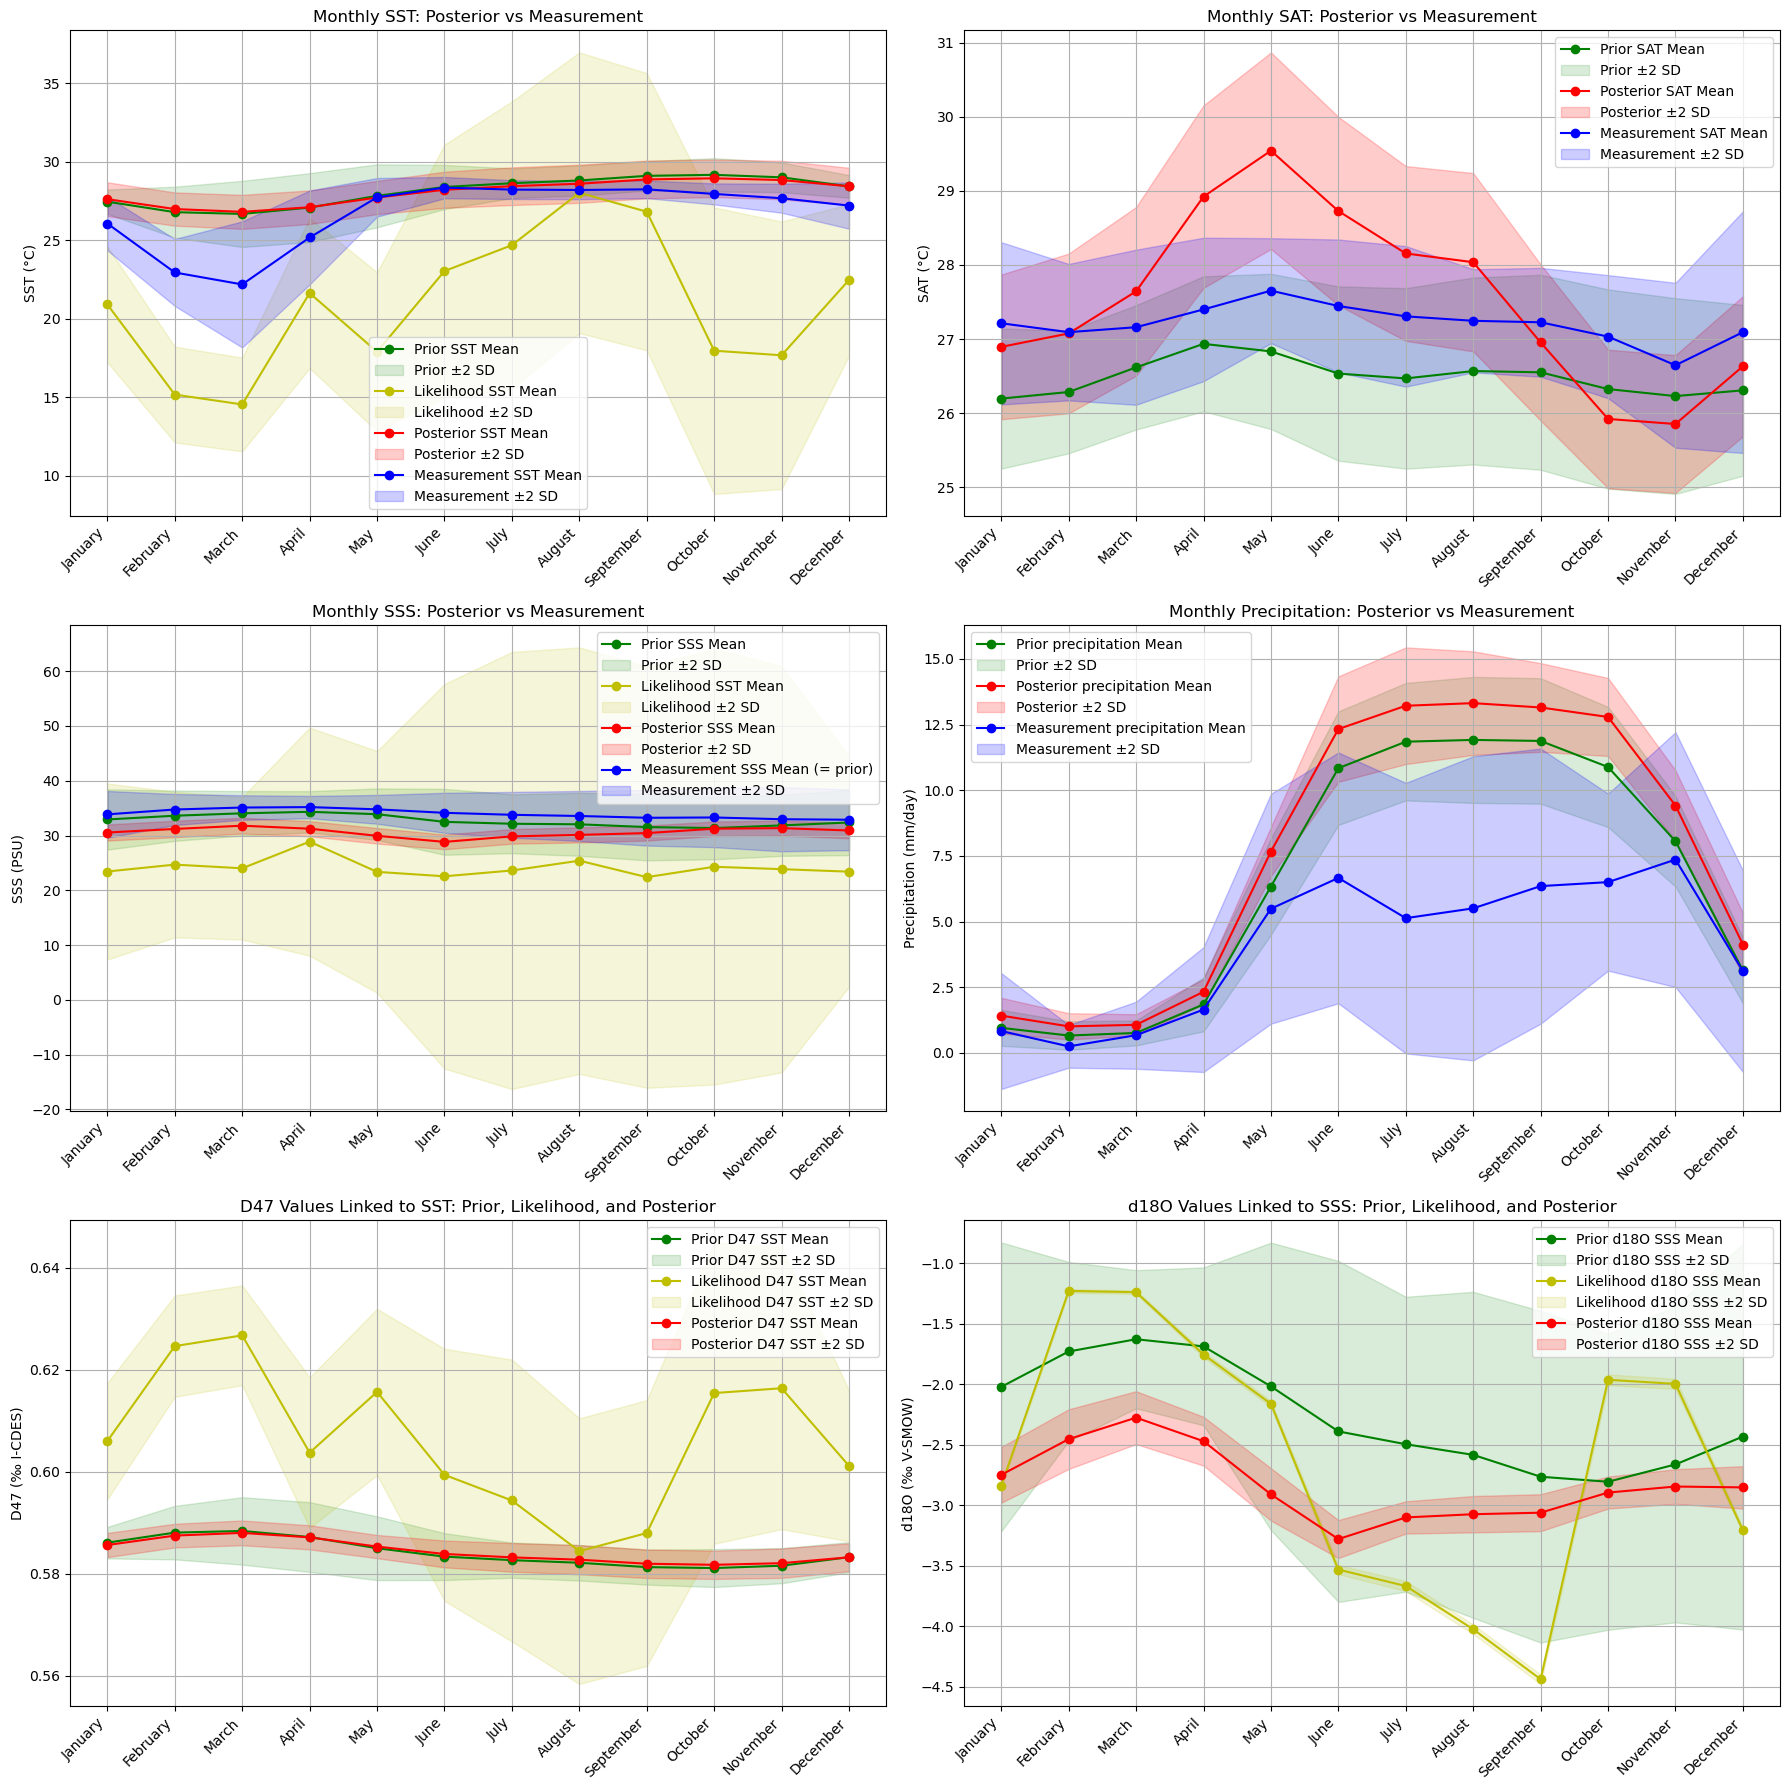

In [143]:
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Panel 1: SST
# Plot prior mean and ±2 SD
axes[0, 0].plot(months_scale, mu_prior_SST_monthly_original, label='Prior SST Mean', color='g', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_prior_SST_monthly_original - 2 * std_prior_SST_monthly,
    mu_prior_SST_monthly_original + 2 * std_prior_SST_monthly,
    color='g', alpha=0.15, label='Prior ±2 SD'
)
# Plot likelihood mean and ±2 SD
axes[0, 0].plot(months_scale, mu_likelihood_monthly_aggregated_T, label='Likelihood SST Mean', color='y', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_aggregated_T - 2 * std_likelihood_monthly_aggregated_T,
    mu_likelihood_monthly_aggregated_T + 2 * std_likelihood_monthly_aggregated_T,
    color='y', alpha=0.15, label='Likelihood ±2 SD'
)
# Plot posterior mean and ±2 SD
axes[0, 0].plot(months_scale, mu_post_SST_D47_monthly_aggregated_T, label='Posterior SST Mean', color='r', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated_T - 2 * std_post_SST_D47_monthly_aggregated_T,
    mu_post_SST_D47_monthly_aggregated_T + 2 * std_post_SST_D47_monthly_aggregated_T,
    color='r', alpha=0.2, label='Posterior ±2 SD'
)
# Plot measurement mean and ±2 SD
axes[0, 0].plot(months_scale, mu_measurement_SST_monthly, label='Measurement SST Mean', color='b', marker='o')
axes[0, 0].fill_between(
    months_scale,
    mu_measurement_SST_monthly - 2 * std_measurement_SST_monthly,
    mu_measurement_SST_monthly + 2 * std_measurement_SST_monthly,
    color='b', alpha=0.2, label='Measurement ±2 SD'
)
axes[0, 0].set_xticks(months_scale)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 0].set_ylabel('SST (°C)')
axes[0, 0].set_title('Monthly SST: Posterior vs Measurement')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Panel 2: SAT
# Plot prior mean and ±2 SD for SAT
axes[0, 1].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', color='g', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_prior_SAT_monthly - 2 * std_prior_SAT_monthly,
    mu_prior_SAT_monthly + 2 * std_prior_SAT_monthly,
    color='g', alpha=0.15, label='Prior ±2 SD'
)
# Plot posterior mean and ±2 SD
axes[0, 1].plot(months_scale, mu_post_SAT_D47_monthly_aggregated_T, label='Posterior SAT Mean', color='r', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_post_SAT_D47_monthly_aggregated_T - 2 * std_post_SAT_D47_monthly_aggregated_T,
    mu_post_SAT_D47_monthly_aggregated_T + 2 * std_post_SAT_D47_monthly_aggregated_T,
    color='r', alpha=0.2, label='Posterior ±2 SD'
)
# Plot measurement mean and ±2 SD
axes[0, 1].plot(months_scale, mu_measurement_SAT_monthly, label='Measurement SAT Mean', color='b', marker='o')
axes[0, 1].fill_between(
    months_scale,
    mu_measurement_SAT_monthly - 2 * std_measurement_SAT_monthly,
    mu_measurement_SAT_monthly + 2 * std_measurement_SAT_monthly,
    color='b', alpha=0.2, label='Measurement ±2 SD'
)
axes[0, 1].set_xticks(months_scale)
axes[0, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[0, 1].set_ylabel('SAT (°C)')
axes[0, 1].set_title('Monthly SAT: Posterior vs Measurement')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Panel 3: SSS
# Plot prior mean and ±2 SD for SAT
axes[1, 0].plot(months_scale, mu_prior_SSS_monthly, label='Prior SSS Mean', color='g', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_prior_SSS_monthly - 2 * std_prior_SSS_monthly,
    mu_prior_SSS_monthly + 2 * std_prior_SSS_monthly,
    color='g', alpha=0.15, label='Prior ±2 SD'
)
# Plot likelihood mean and ±2 SD
axes[1, 0].plot(months_scale, mu_likelihood_SSS_d18Ow_monthly_aggregated_T, label='Likelihood SST Mean', color='y', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_likelihood_SSS_d18Ow_monthly_aggregated_T - 2 * std_likelihood_SSS_d18Ow_monthly_aggregated_T,
    mu_likelihood_SSS_d18Ow_monthly_aggregated_T + 2 * std_likelihood_SSS_d18Ow_monthly_aggregated_T,
    color='y', alpha=0.15, label='Likelihood ±2 SD'
)
# Plot posterior mean and ±2 SD
axes[1, 0].plot(months_scale, mu_post_SSS_d18Ow_monthly_aggregated_T, label='Posterior SSS Mean', color='r', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_post_SSS_d18Ow_monthly_aggregated_T - 2 * std_post_SSS_d18Ow_monthly_aggregated_T,
    mu_post_SSS_d18Ow_monthly_aggregated_T + 2 * std_post_SSS_d18Ow_monthly_aggregated_T,
    color='r', alpha=0.2, label='Posterior ±2 SD'
)
# Plot measurement mean and ±2 SD
axes[1, 0].plot(months_scale, mu_measurement_SSS_monthly, label='Measurement SSS Mean (= prior)', color='b', marker='o')
axes[1, 0].fill_between(
    months_scale,
    mu_measurement_SSS_monthly - 2 * std_measurement_SSS_monthly,
    mu_measurement_SSS_monthly + 2 * std_measurement_SSS_monthly,
    color='b', alpha=0.2, label='Measurement ±2 SD'
)
axes[1, 0].set_xticks(months_scale)
axes[1, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 0].set_ylabel('SSS (PSU)')
axes[1, 0].set_title('Monthly SSS: Posterior vs Measurement')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Panel 4: Precipitation
# Plot prior mean and ±2 SD for SAT
axes[1, 1].plot(months_scale, mu_prior_precip_monthly, label='Prior precipitation Mean', color='g', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_prior_precip_monthly - 2 * std_prior_precip_monthly,
    mu_prior_precip_monthly + 2 * std_prior_precip_monthly,
    color='g', alpha=0.15, label='Prior ±2 SD'
)
# Plot posterior mean and ±2 SD
axes[1, 1].plot(months_scale, mu_post_precip_monthly_aggregated, label='Posterior precipitation Mean', color='r', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_post_precip_monthly_aggregated - 2 * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)),
    mu_post_precip_monthly_aggregated + 2 * np.sqrt(np.diag(cov_post_precip_monthly_aggregated)),
    color='r', alpha=0.2, label='Posterior ±2 SD'
)
# Plot measurement mean and ±2 SD
axes[1, 1].plot(months_scale, mu_measurement_precip_monthly, label='Measurement precipitation Mean', color='b', marker='o')
axes[1, 1].fill_between(
    months_scale,
    mu_measurement_precip_monthly - 2 * std_measurement_precip_monthly,
    mu_measurement_precip_monthly + 2 * std_measurement_precip_monthly,
    color='b', alpha=0.2, label='Measurement ±2 SD'
)
axes[1, 1].set_xticks(months_scale)
axes[1, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1, 1].set_ylabel('Precipitation (mm/day)')
axes[1, 1].set_title('Monthly Precipitation: Posterior vs Measurement')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Panel 5: D47 values linked to SST
# Plot prior mean and ±2 SD for D47 values linked to SST
axes[2, 0].plot(months_scale, mu_prior_SST_D47_monthly, label='Prior D47 SST Mean', color='g', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_prior_SST_D47_monthly - 2 * std_prior_SST_D47_monthly,
    mu_prior_SST_D47_monthly + 2 * std_prior_SST_D47_monthly,
    color='g', alpha=0.15, label='Prior D47 SST ±2 SD'
)
# Plot likelihood mean and ±2 SD for D47 values linked to SST
axes[2, 0].plot(months_scale, mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly], label='Likelihood D47 SST Mean', color='y', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly] - 2 * std_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly],
    mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly] + 2 * std_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly],
    color='y', alpha=0.15, label='Likelihood D47 SST ±2 SD'
)
# Plot posterior mean and ±2 SD for D47 values linked to SST
axes[2, 0].plot(months_scale, mu_post_SST_D47_monthly_aggregated, label='Posterior D47 SST Mean', color='r', marker='o')
axes[2, 0].fill_between(
    months_scale,
    mu_post_SST_D47_monthly_aggregated - 2 * std_post_SST_D47_monthly_aggregated,
    mu_post_SST_D47_monthly_aggregated + 2 * std_post_SST_D47_monthly_aggregated,
    color='r', alpha=0.2, label='Posterior D47 SST ±2 SD'
)
axes[2, 0].set_xticks(months_scale)
axes[2, 0].set_xticklabels(month_names, rotation=45, ha="right")
axes[2, 0].set_ylabel('D47 (‰ I-CDES)')
axes[2, 0].set_title('D47 Values Linked to SST: Prior, Likelihood, and Posterior')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Panel 6: d18O values linked to SSS
# Plot prior mean and ±2 SD for d18O values linked to SSS
axes[2, 1].plot(months_scale, mu_prior_d18Oc_monthly_original, label='Prior d18O SSS Mean', color='g', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_prior_d18Oc_monthly_original - 2 * std_prior_d18Oc_monthly_original,
    mu_prior_d18Oc_monthly_original + 2 * std_prior_d18Oc_monthly_original,
    color='g', alpha=0.15, label='Prior d18O SSS ±2 SD'
)
# Plot likelihood mean and ±2 SD for d18O values linked to SSS
axes[2, 1].plot(months_scale, mu_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly], label='Likelihood d18O SSS Mean', color='y', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] - 2 * std_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly],
    mu_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly] + 2 * std_likelihood_monthly_aggregated[var_start_d18Oc_monthly:var_end_d18Oc_monthly],
    color='y', alpha=0.15, label='Likelihood d18O SSS ±2 SD'
)
# Plot posterior mean and ±2 SD for d18O values linked to SSS
axes[2, 1].plot(months_scale, mu_post_d18Oc_monthly_aggregated, label='Posterior d18O SSS Mean', color='r', marker='o')
axes[2, 1].fill_between(
    months_scale,
    mu_post_d18Oc_monthly_aggregated - 2 * np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated)),
    mu_post_d18Oc_monthly_aggregated + 2 * np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated)),
    color='r', alpha=0.2, label='Posterior d18O SSS ±2 SD'
)
axes[2, 1].set_xticks(months_scale)
axes[2, 1].set_xticklabels(month_names, rotation=45, ha="right")
axes[2, 1].set_ylabel('d18O (‰ V-SMOW)')
axes[2, 1].set_title('d18O Values Linked to SSS: Prior, Likelihood, and Posterior')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

### Export prior, measurement and posterior data for later plotting

In [144]:
Normal_priors_outcomes = {
    'mu_measurement_SST': mu_measurement_SST_monthly.flatten(),
    'std_measurement_SST': std_measurement_SST_monthly.flatten(),
    'mu_measurement_SAT': mu_measurement_SAT_monthly.flatten(),
    'std_measurement_SAT': std_measurement_SAT_monthly.flatten(),
    'mu_measurement_SSS': mu_measurement_SSS_monthly.flatten(),
    'std_measurement_SSS': std_measurement_SSS_monthly.flatten(),
    'mu_measurement_precip': mu_measurement_precip_monthly.flatten(),
    'std_measurement_precip': std_measurement_precip_monthly.flatten(),
    'mu_prior_SST': mu_prior_SST_monthly.flatten(),
    'std_prior_SST': std_prior_SST_monthly.flatten(),
    'mu_prior_SAT': mu_prior_SAT_monthly.flatten(),
    'std_prior_SAT': std_prior_SAT_monthly.flatten(),
    'mu_prior_SSS': mu_prior_SSS_d18Ow_monthly_T.flatten(),
    'std_prior_SSS': std_prior_SSS_d18Ow_monthly_T.flatten(),
    'mu_prior_precip': mu_prior_precip_monthly_original.flatten(),
    'std_prior_precip': std_prior_precip_monthly.flatten(),
    'mu_prior_d18Oc': mu_prior_d18Oc_monthly_original.flatten(),
    'std_prior_d18Oc': std_prior_d18Oc_monthly_original.flatten(),
    'mu_prior_D47': mu_prior_SST_D47_monthly.flatten(),
    'std_prior_D47': std_prior_SST_D47_monthly.flatten(),
    'mu_likelihood_SST': mu_likelihood_monthly_aggregated_T.flatten(),
    'std_likelihood_SST': std_likelihood_monthly_aggregated_T.flatten(),
    'mu_likelihood_d18Oc': np.repeat('nan', 12),
    'std_likelihood_d18Oc': np.repeat('nan', 12),
    'mu_likelihood_D47': mu_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly].flatten(),
    'std_likelihood_D47': std_likelihood_monthly_aggregated[var_start_D47_monthly:var_end_D47_monthly].flatten(),
    'mu_post_SST': mu_post_SST_D47_monthly_aggregated_T.flatten(),
    'std_post_SST': std_post_SST_D47_monthly_aggregated_T.flatten(),
    'mu_post_SAT': mu_post_SAT_D47_monthly_aggregated_T.flatten(),
    'std_post_SAT': std_post_SAT_D47_monthly_aggregated_T.flatten(),
    'mu_post_SSS': mu_post_SSS_d18Ow_monthly_aggregated_T.flatten(),
    'std_post_SSS': std_post_SSS_d18Ow_monthly_aggregated_T.flatten(),
    'mu_post_precip': mu_post_precip_monthly_aggregated.flatten(),
    'cov_post_precip': np.sqrt(np.diag(cov_post_precip_monthly_aggregated)).flatten(),
    'mu_post_d18Oc': mu_post_d18Oc_monthly_aggregated.flatten(),
    'cov_post_d18Oc': np.sqrt(np.diag(cov_post_d18Oc_monthly_aggregated)).flatten(),
    'mu_post_D47': mu_post_SST_D47_monthly_aggregated.flatten(),
    'std_post_D47': std_post_SST_D47_monthly_aggregated.flatten(),
}

# Create the Pandas DataFrame
Normal_priors_outcomes_df = pd.DataFrame(Normal_priors_outcomes)

# Export the table to a CSV file
Normal_priors_outcomes_df.to_csv("Sensitivity_SSS_SST_measurements_as_priors/Model_priors_outcomes.csv")